In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import dump, load
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'plotly_white'
plot_template = dict(
    layout=go.Layout({
        'font_size': 8,
        'xaxis_title_font_size': 8,
        'yaxis_title_font_size': 8,
        }   
))
import warnings
warnings.filterwarnings('ignore')

import os
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from datetime import datetime

In [2]:
def tuner(trial, x_train, y_train,x_test,y_test):
    """
        Hyperparameter tuning function for XGBoost model.
        Uses optuna to search for best hyperparameters.
        Returns RMSE of the model.
    """
    # x_train,x_test,y_train,y_test=train_test_split(X, Y, test_size = test_size, random_state = 21)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000,step=50),
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_child_weight': trial.suggest_int('min_child_weight', 7, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0,log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0),
        'gamma': trial.suggest_float('gamma', 0.7, 1.0,step=0.1),

    }

    model = XGBRegressor(
        **params,
        n_jobs=-1,
        objective='reg:squarederror',
        tree_method='gpu_hist',
        gpu_id=0,
    )

    model.fit(        
        x_train, 
        y_train, 
        early_stopping_rounds=500, 
        eval_set=[(x_test,y_test)],        
        verbose=0)
    
    y_hat = model.predict(x_test)

    return np.sqrt(mean_squared_error(y_test, y_hat))

def timer(start_time=None):
    """ 
        Helps  to keep track of time elapsed while training.
        start time: if none then start time tracking
                    if not none tracks time from start time         
    """
    if not start_time:
        print(datetime.now())
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print("Time taken: %i hours %i minutes and %s seconds." % (thour, tmin, round(tsec, 2)))

def rebuild(study,x_train,y_train,x_test,y_test):
    final_xgb_params = study.best_params
    XGBmodel = XGBRegressor(
        **final_xgb_params,
        n_jobs=-1, 
        tree_method='gpu_hist', 
        gpu_id=0
    )
    
    XGBmodel.fit(
        x_train,
        y_train, 
        early_stopping_rounds=500, 
        eval_set=[(x_test,y_test)],
        verbose=0)
    
    train_nse = r2_score(
                y_true=y_train,
                y_pred = XGBmodel.predict(x_train)
    )

    val_nse = r2_score(
        y_true=y_test,
        y_pred = XGBmodel.predict(x_test)
    )
    
    print('train nse:',train_nse)
    print('val nse:',val_nse)
    return XGBmodel,train_nse,val_nse

# def fill_missing_values(model,df,df_raw,target,input_columns):
#     for time in df.index:
#         predictors = df.loc[time,input_columns]
#         if pd.isnull(df.loc[time,target]) and not pd.isnull(predictors).any():
#             df.loc[time,target] = model.predict(
#                 df.loc[time,input_columns].values.reshape(1,-1)
#             )

#     msno.matrix(df)
#     fig = px.line(pd.DataFrame({
#         'pred': df[target].values,
#         'real': df_raw[target].values,
#     },index=df.index), labels={'time': '时间', 'value': '值'}, title='填充后的数据对比')
#     fig.update_layout(
#         template=plot_template,legend=dict(orientation='h',x=0,y=1.1))
#     fig.show()

<Axes: >

<Figure size 640x480 with 0 Axes>

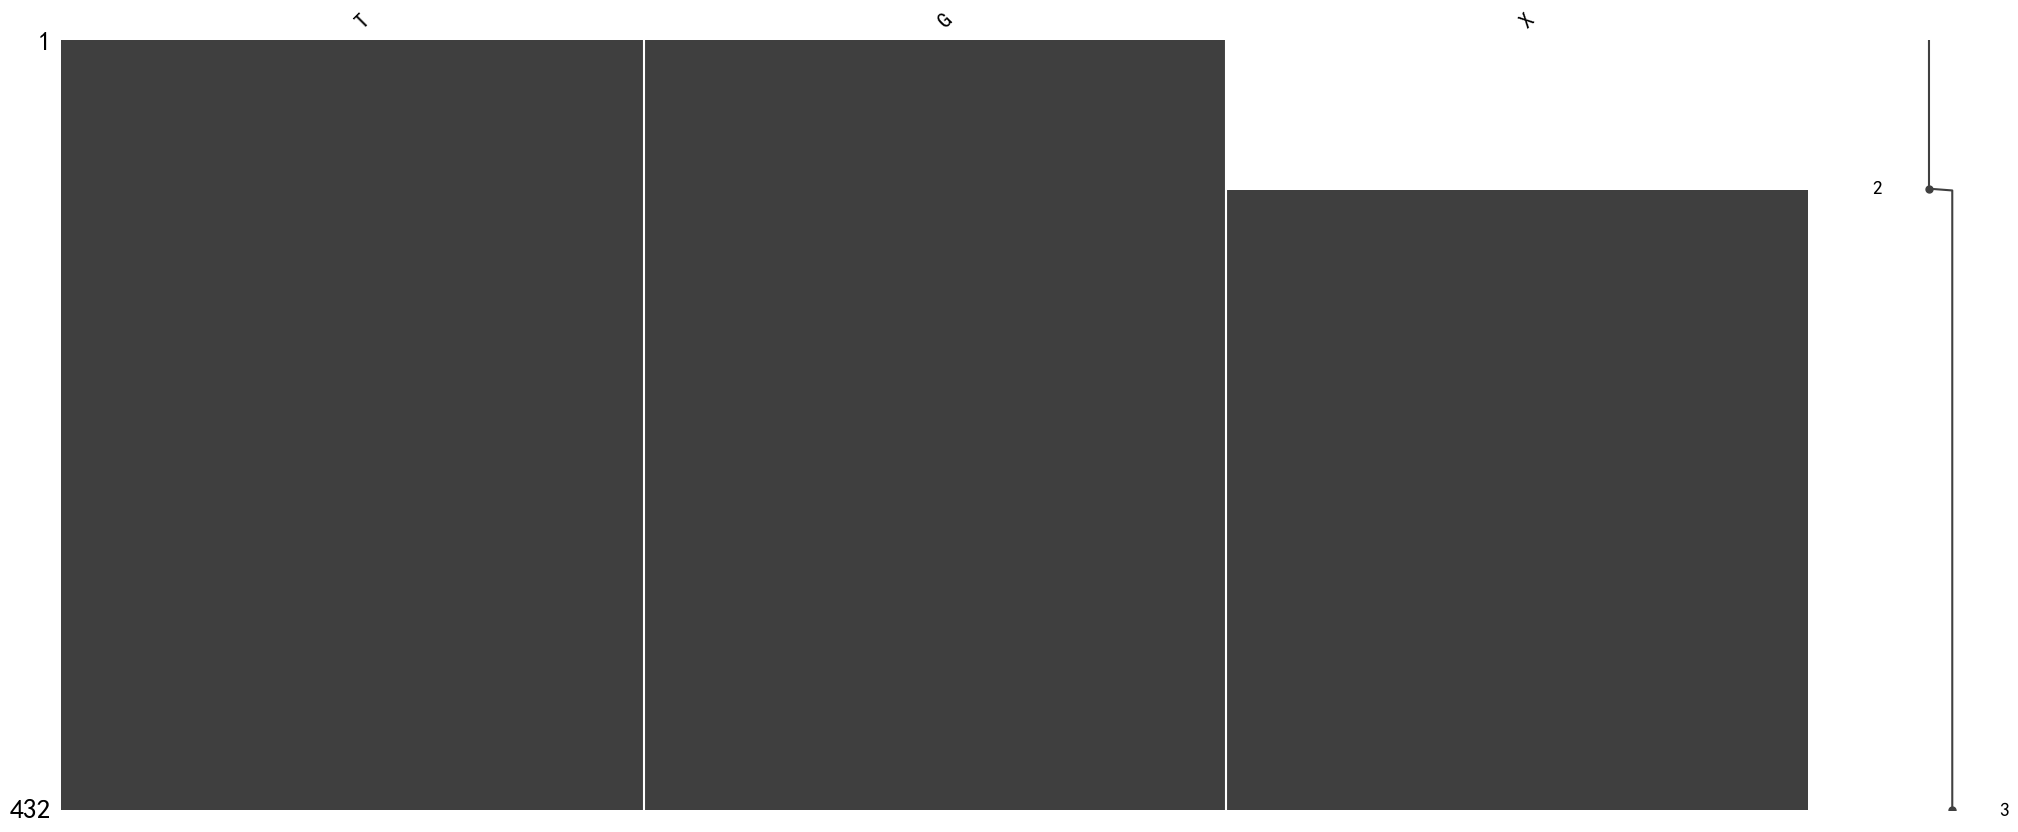

<Figure size 640x480 with 0 Axes>

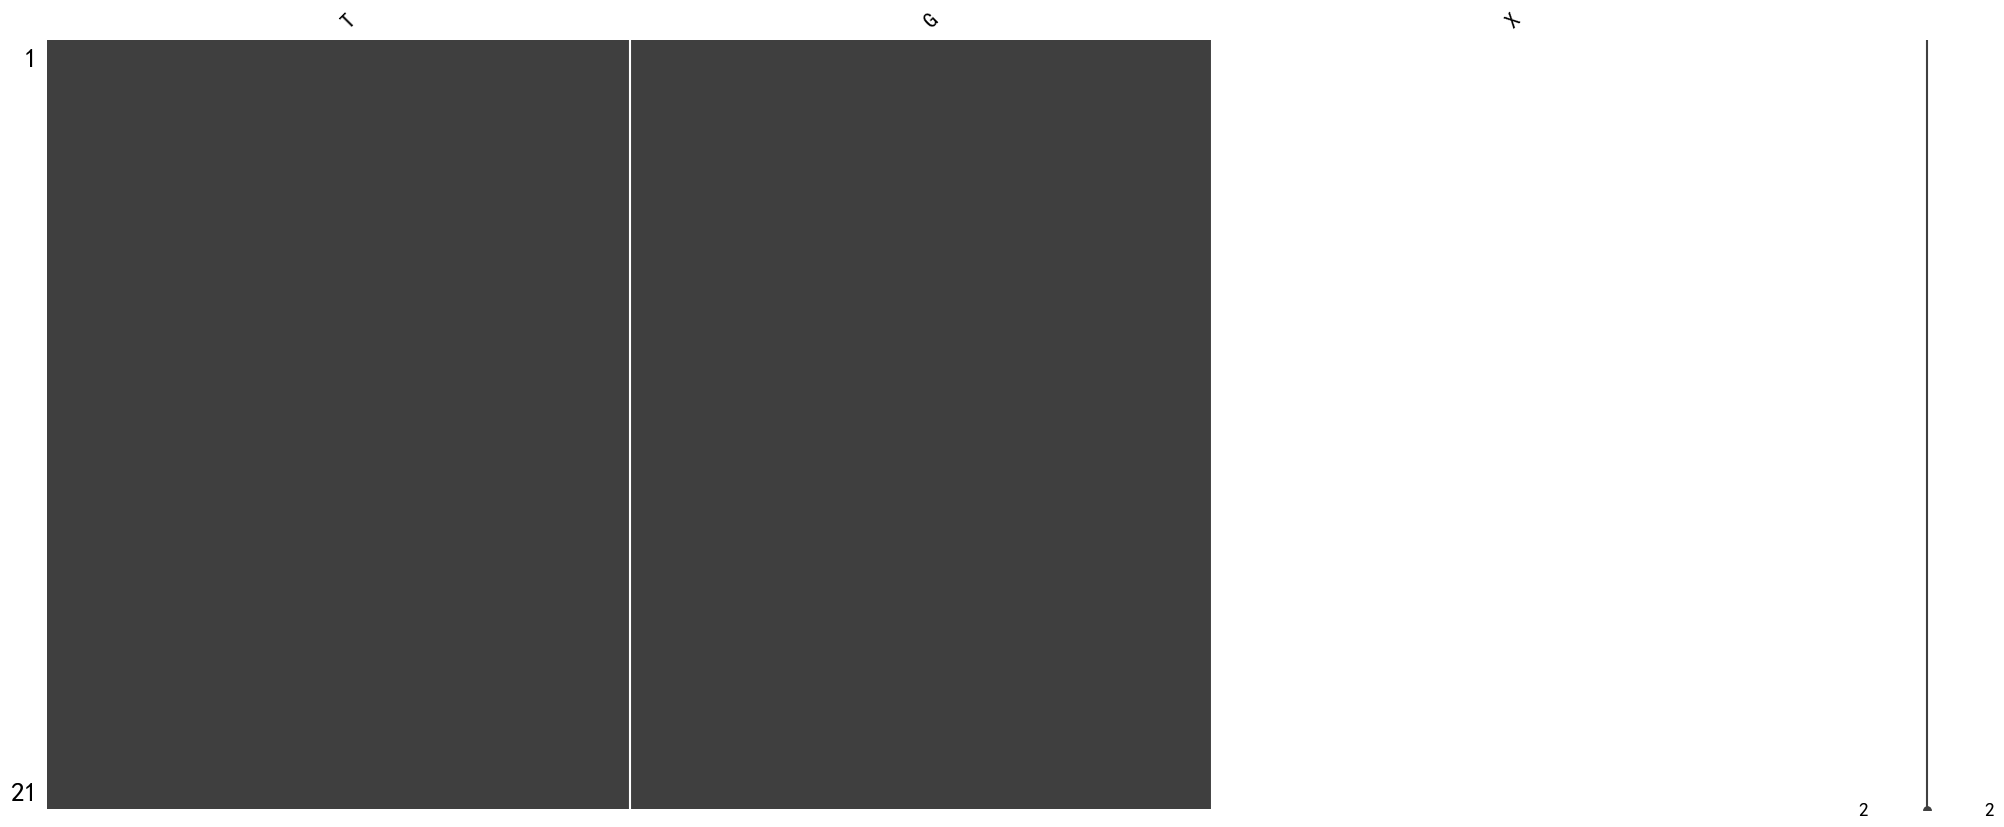

<Figure size 640x480 with 0 Axes>

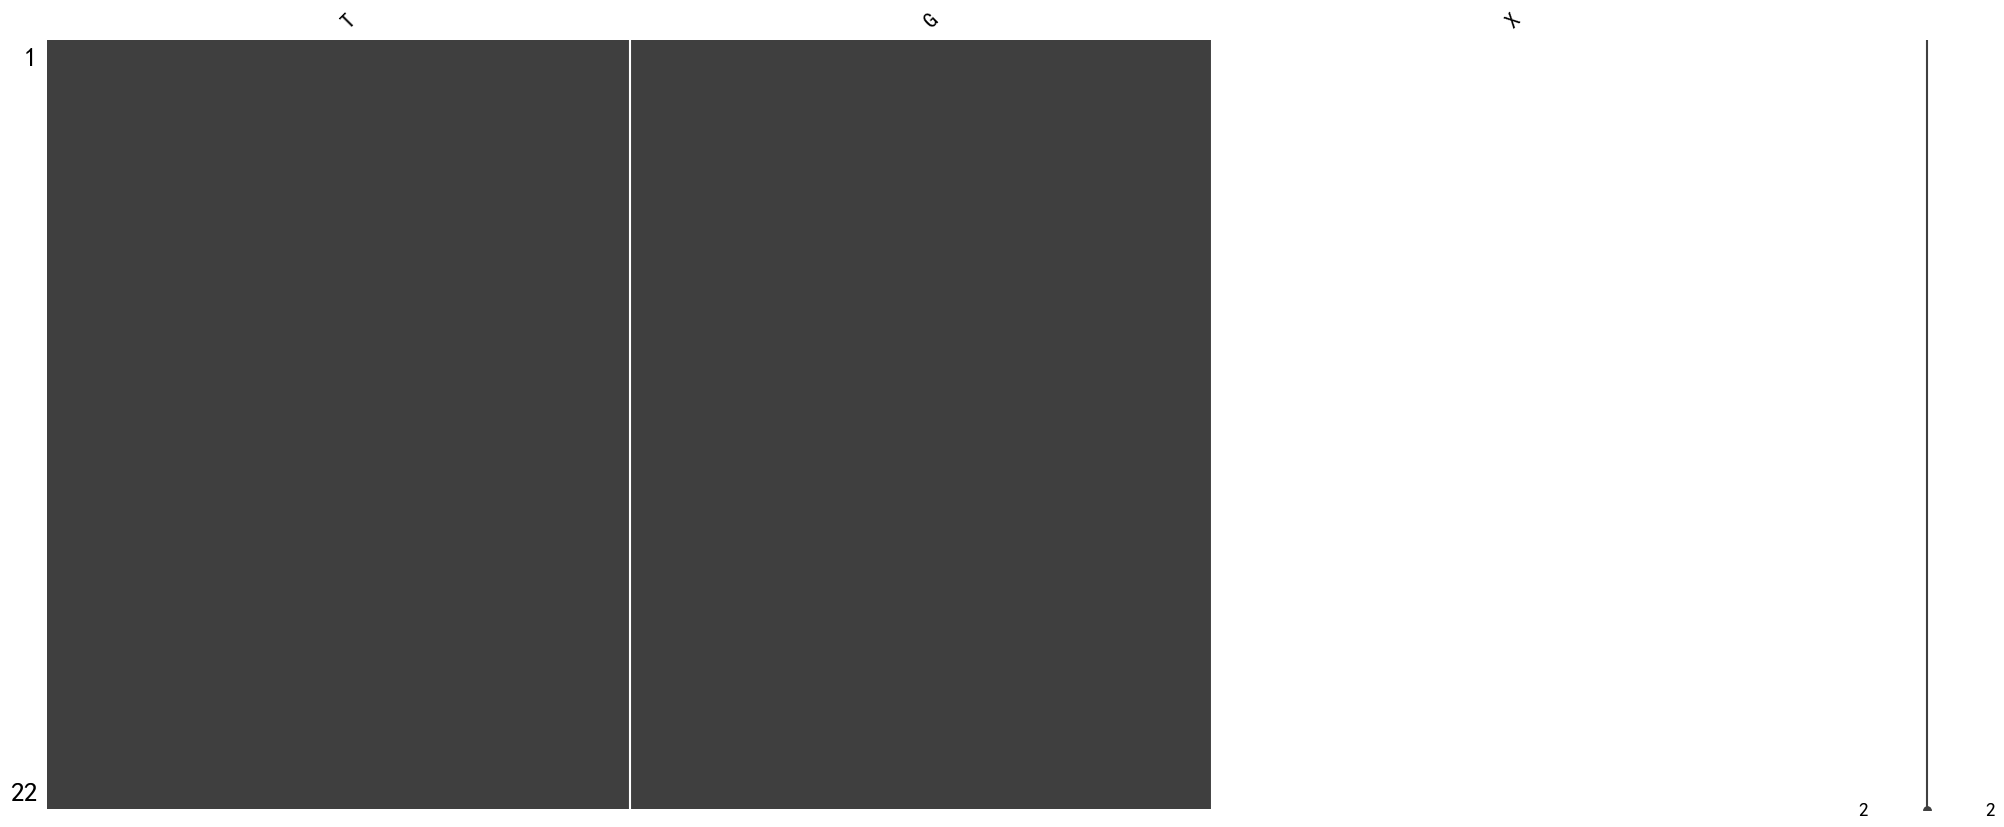

<Figure size 640x480 with 0 Axes>

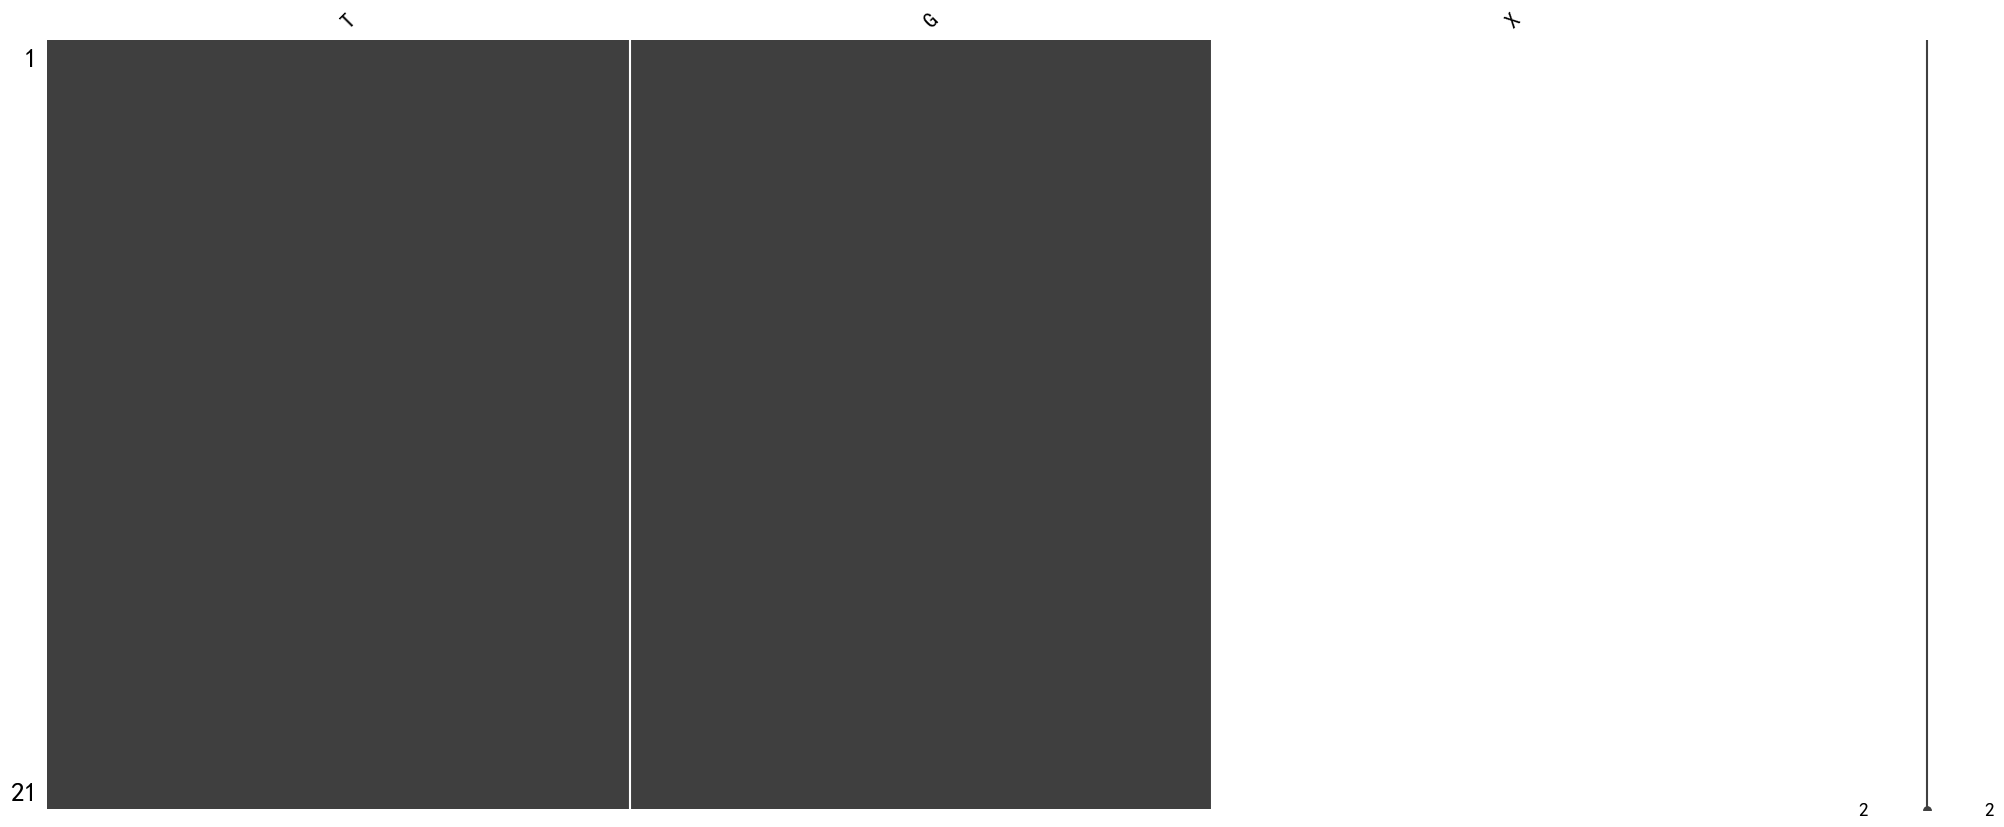

<Figure size 640x480 with 0 Axes>

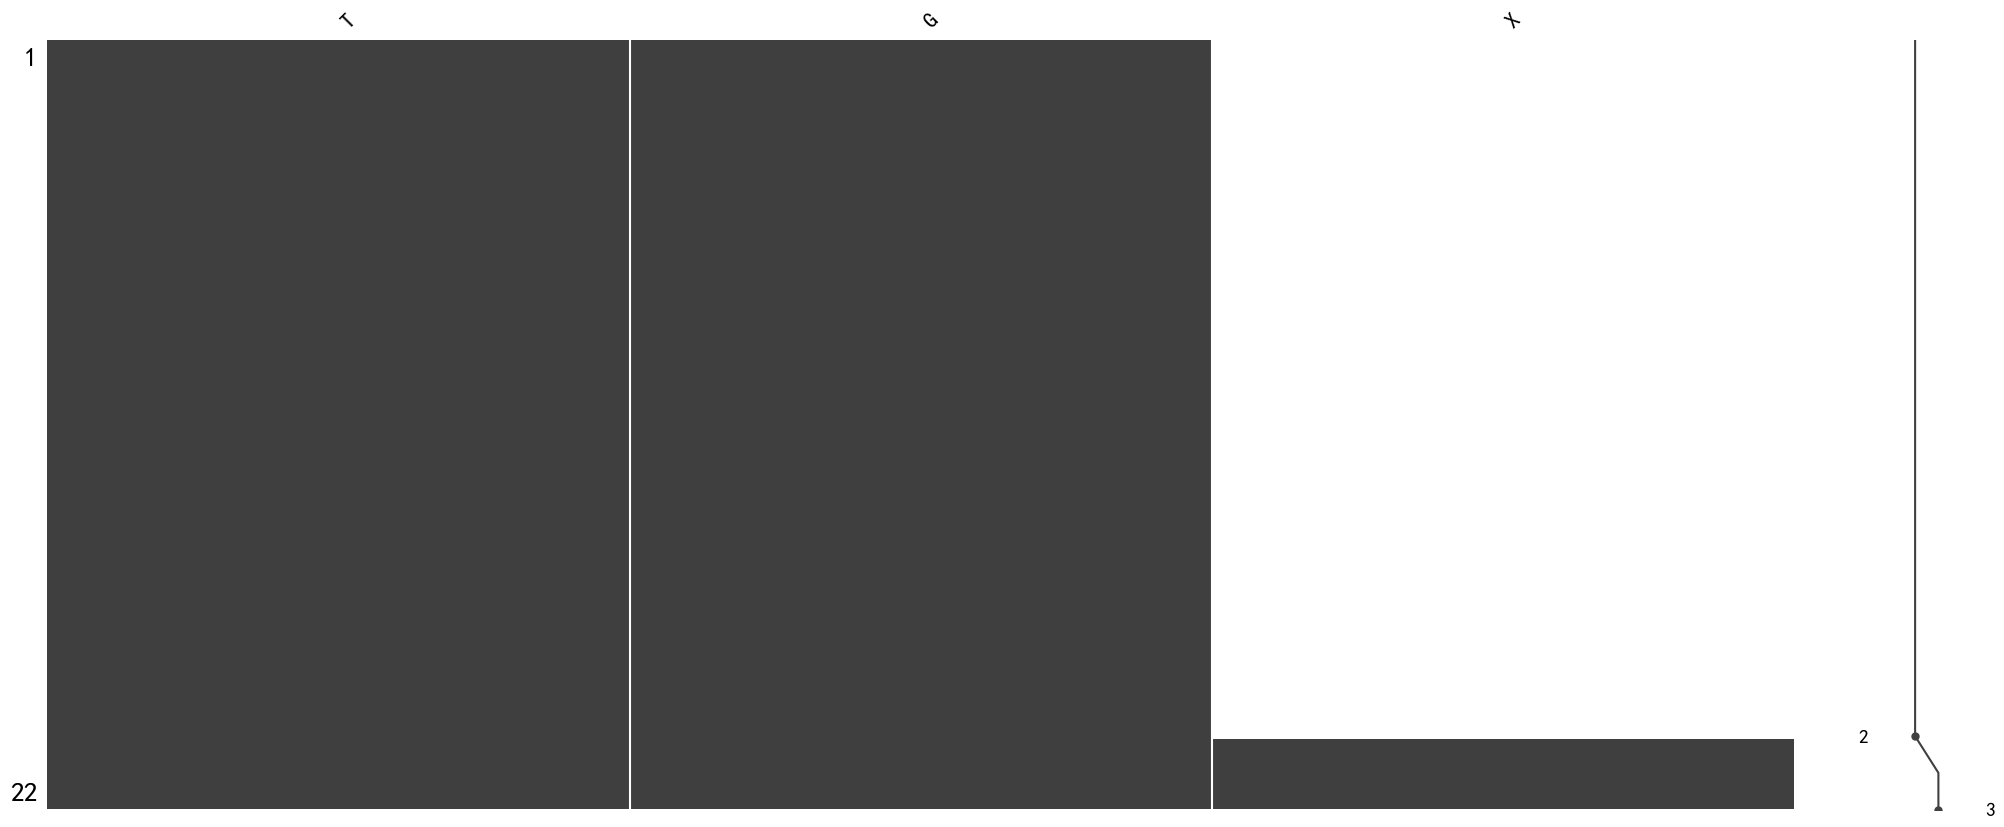

<Figure size 640x480 with 0 Axes>

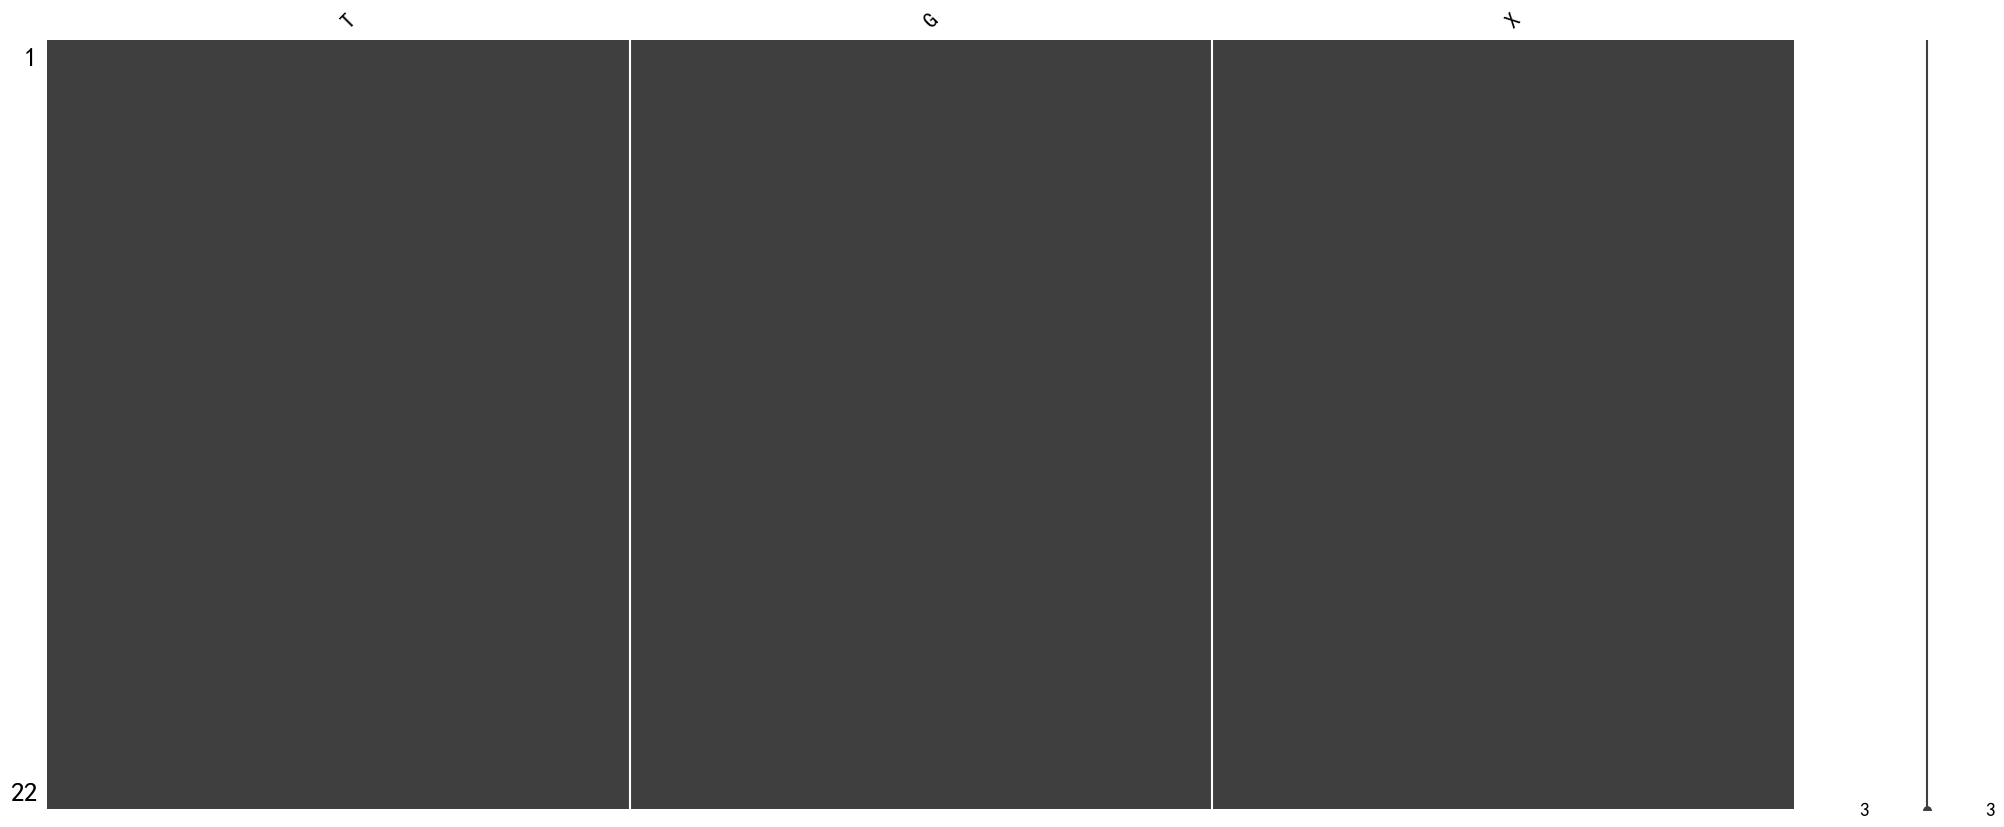

<Figure size 640x480 with 0 Axes>

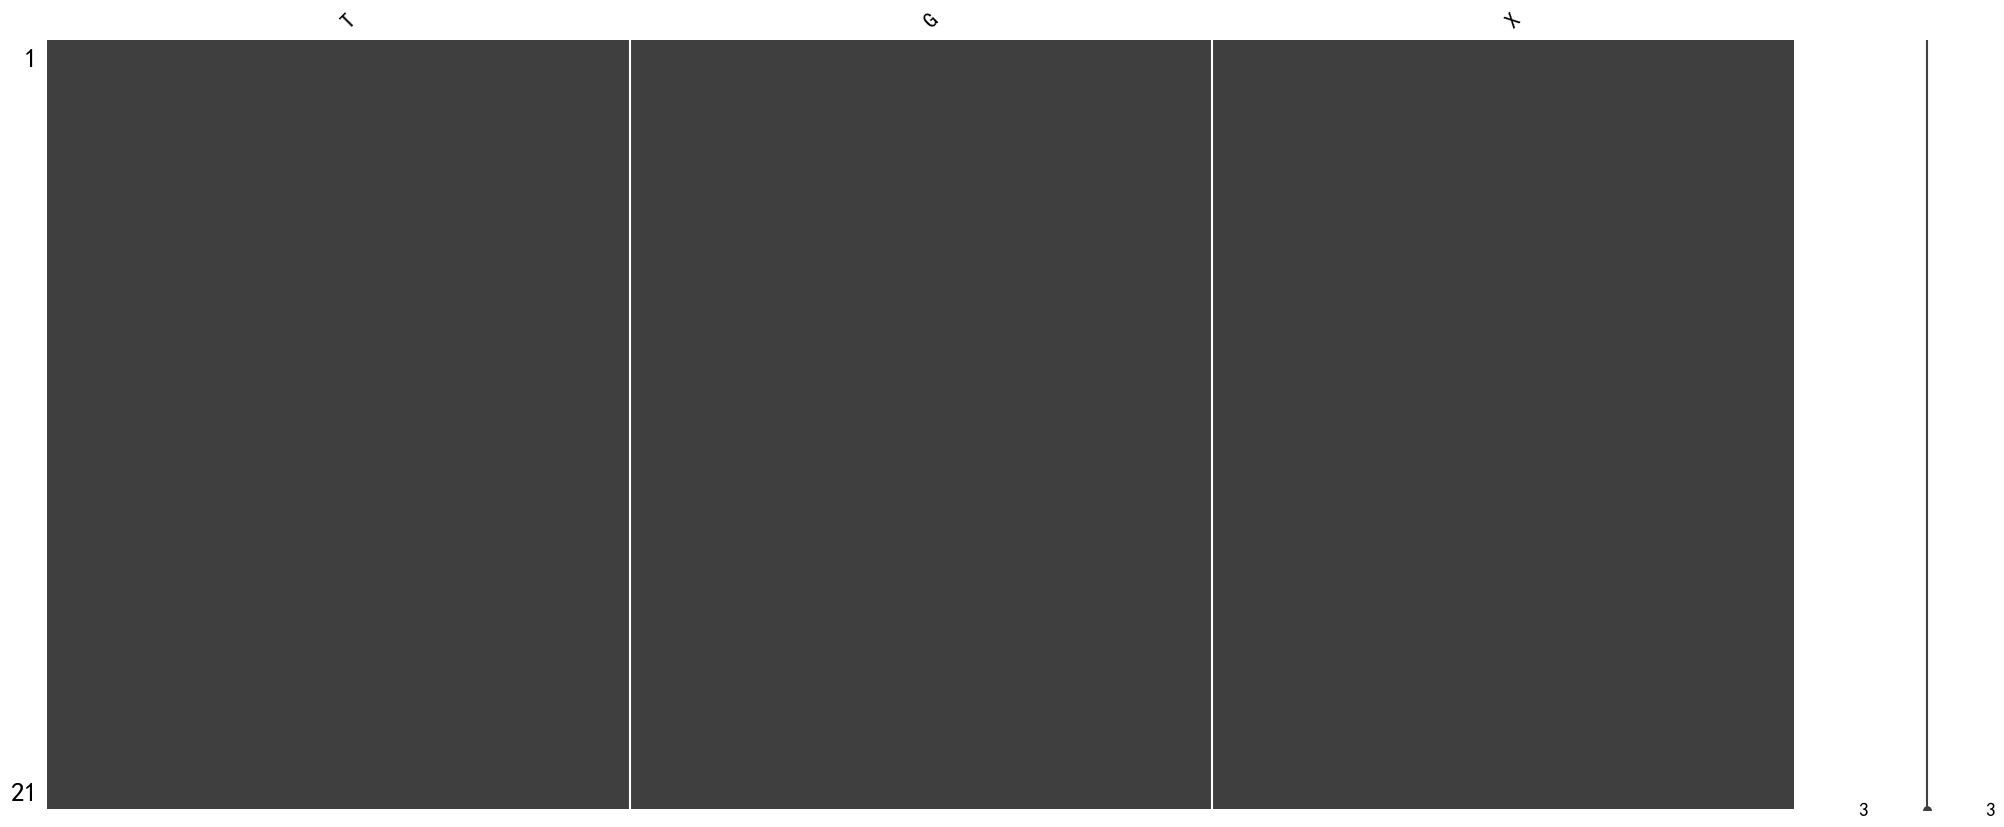

<Figure size 640x480 with 0 Axes>

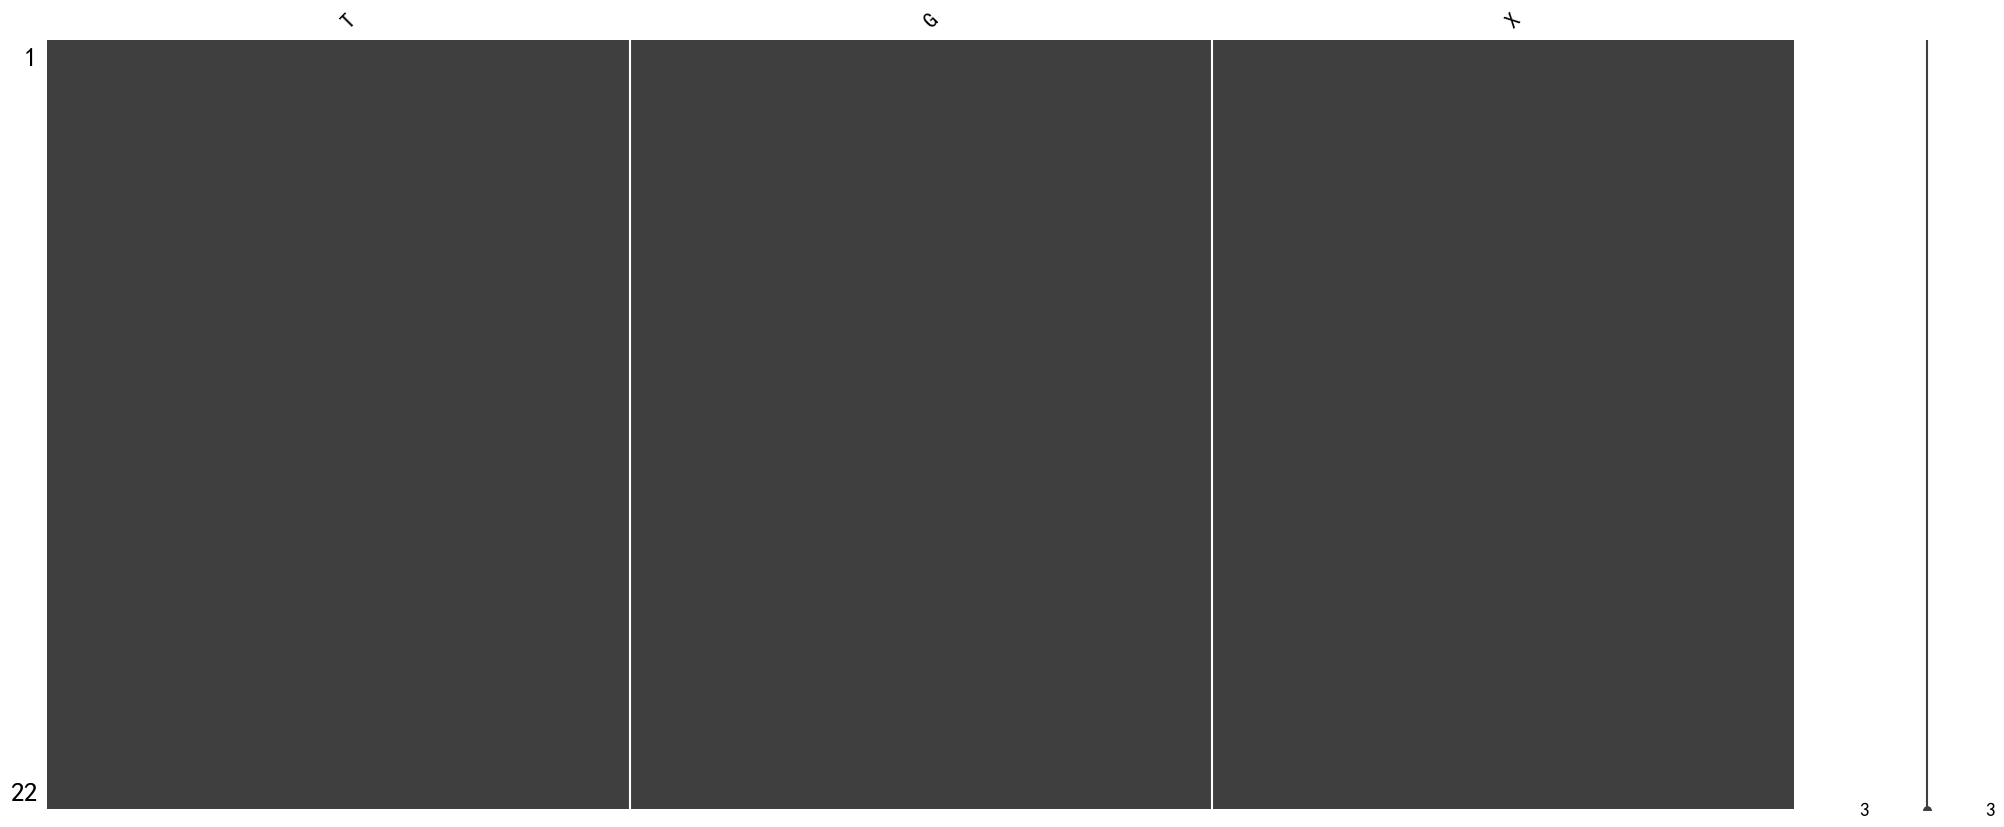

<Figure size 640x480 with 0 Axes>

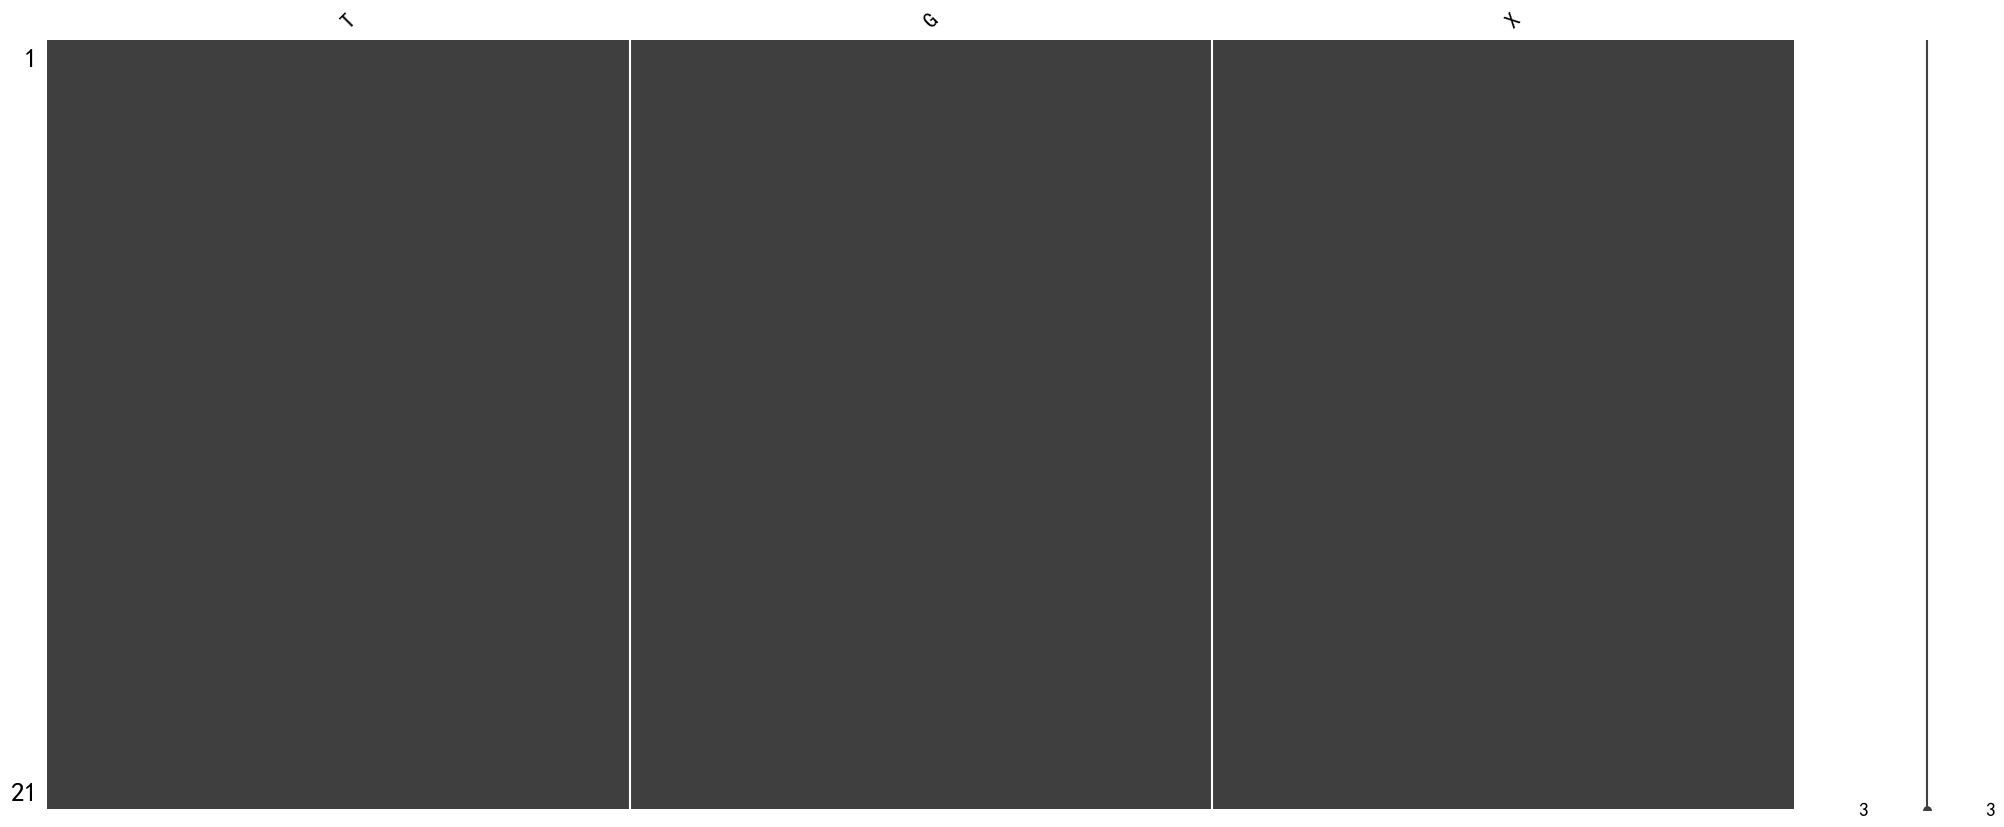

<Figure size 640x480 with 0 Axes>

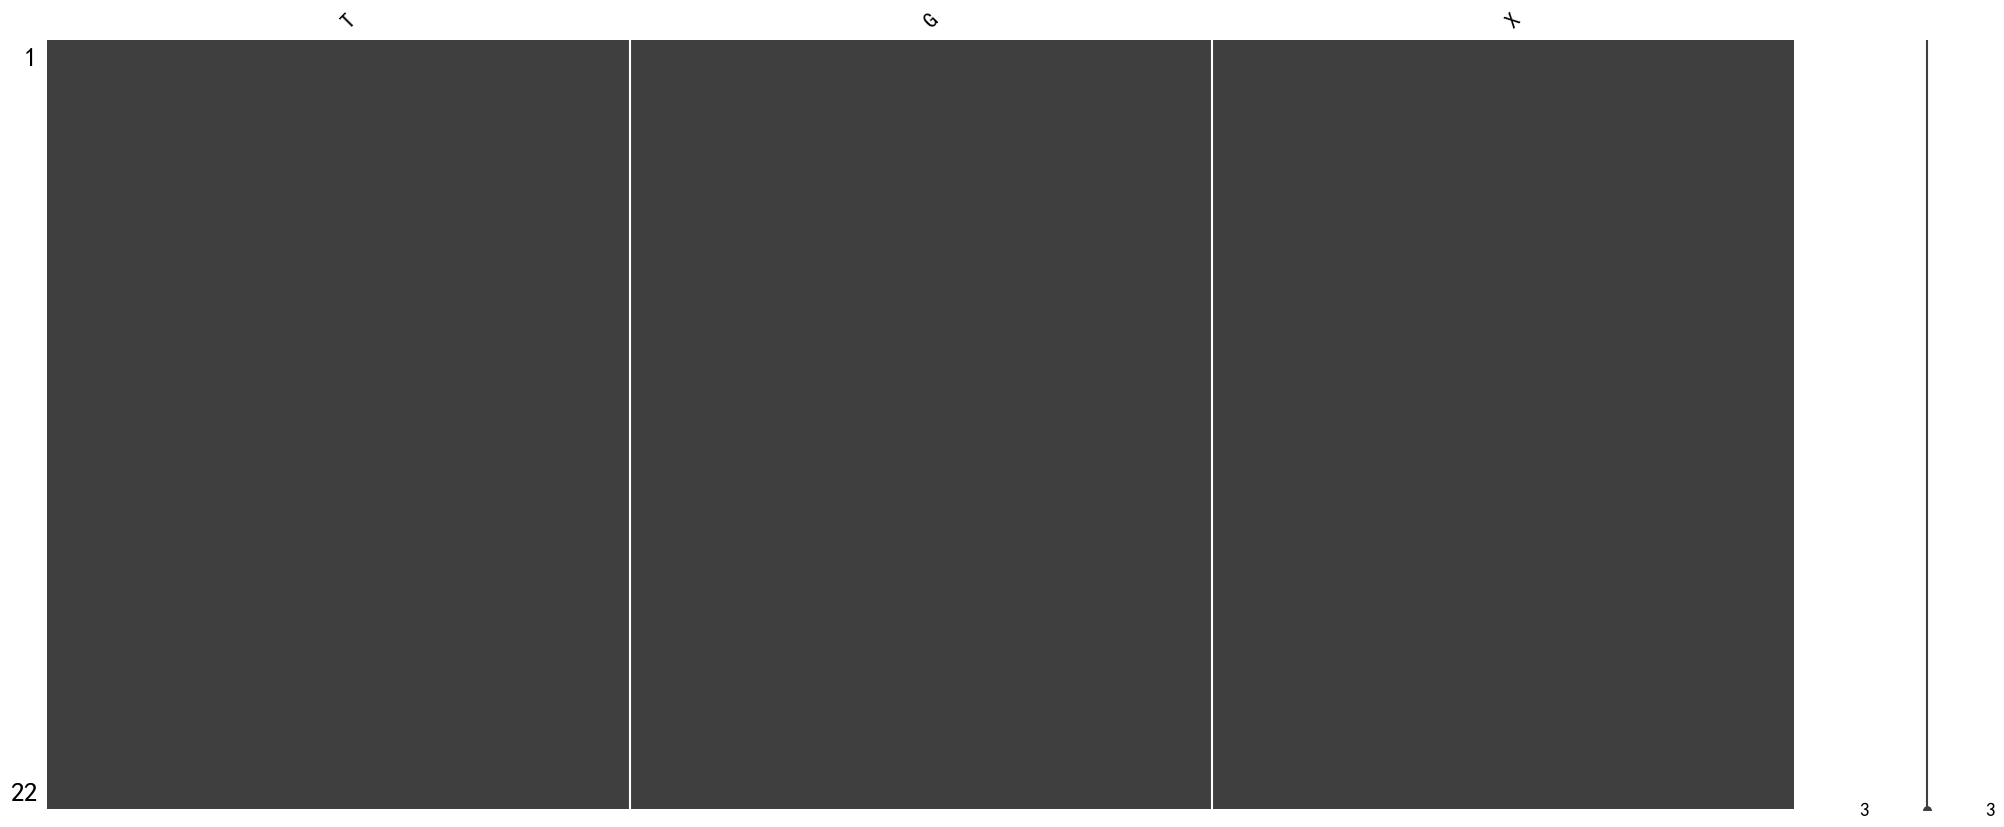

<Figure size 640x480 with 0 Axes>

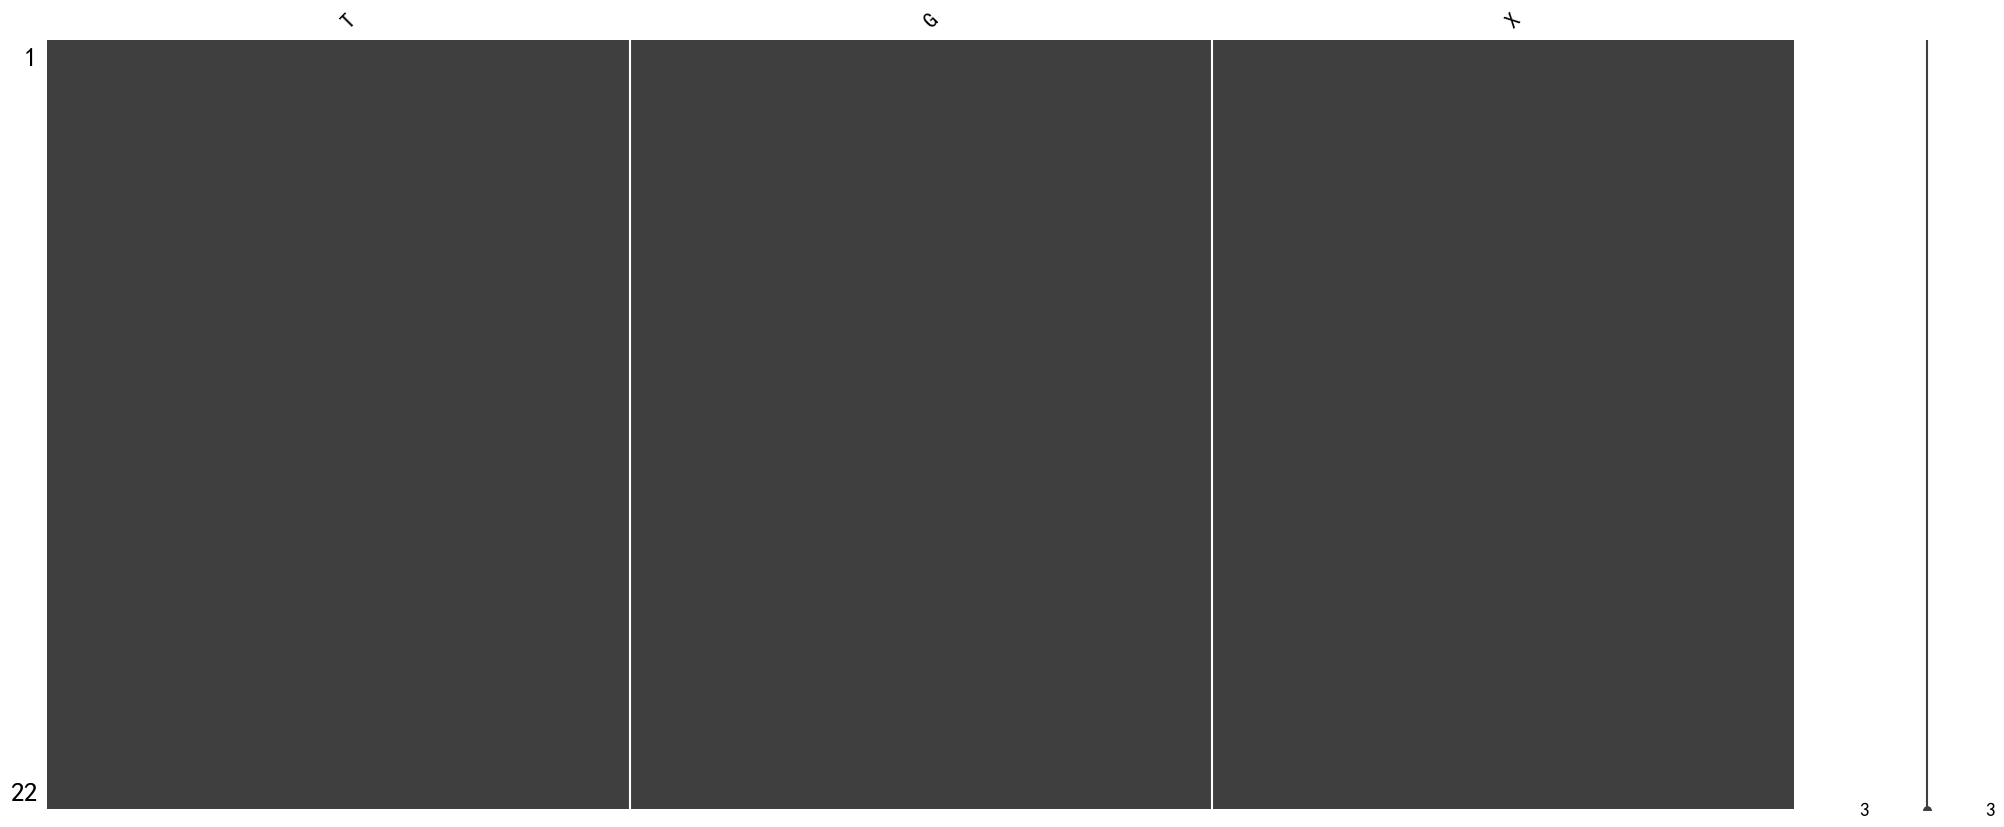

<Figure size 640x480 with 0 Axes>

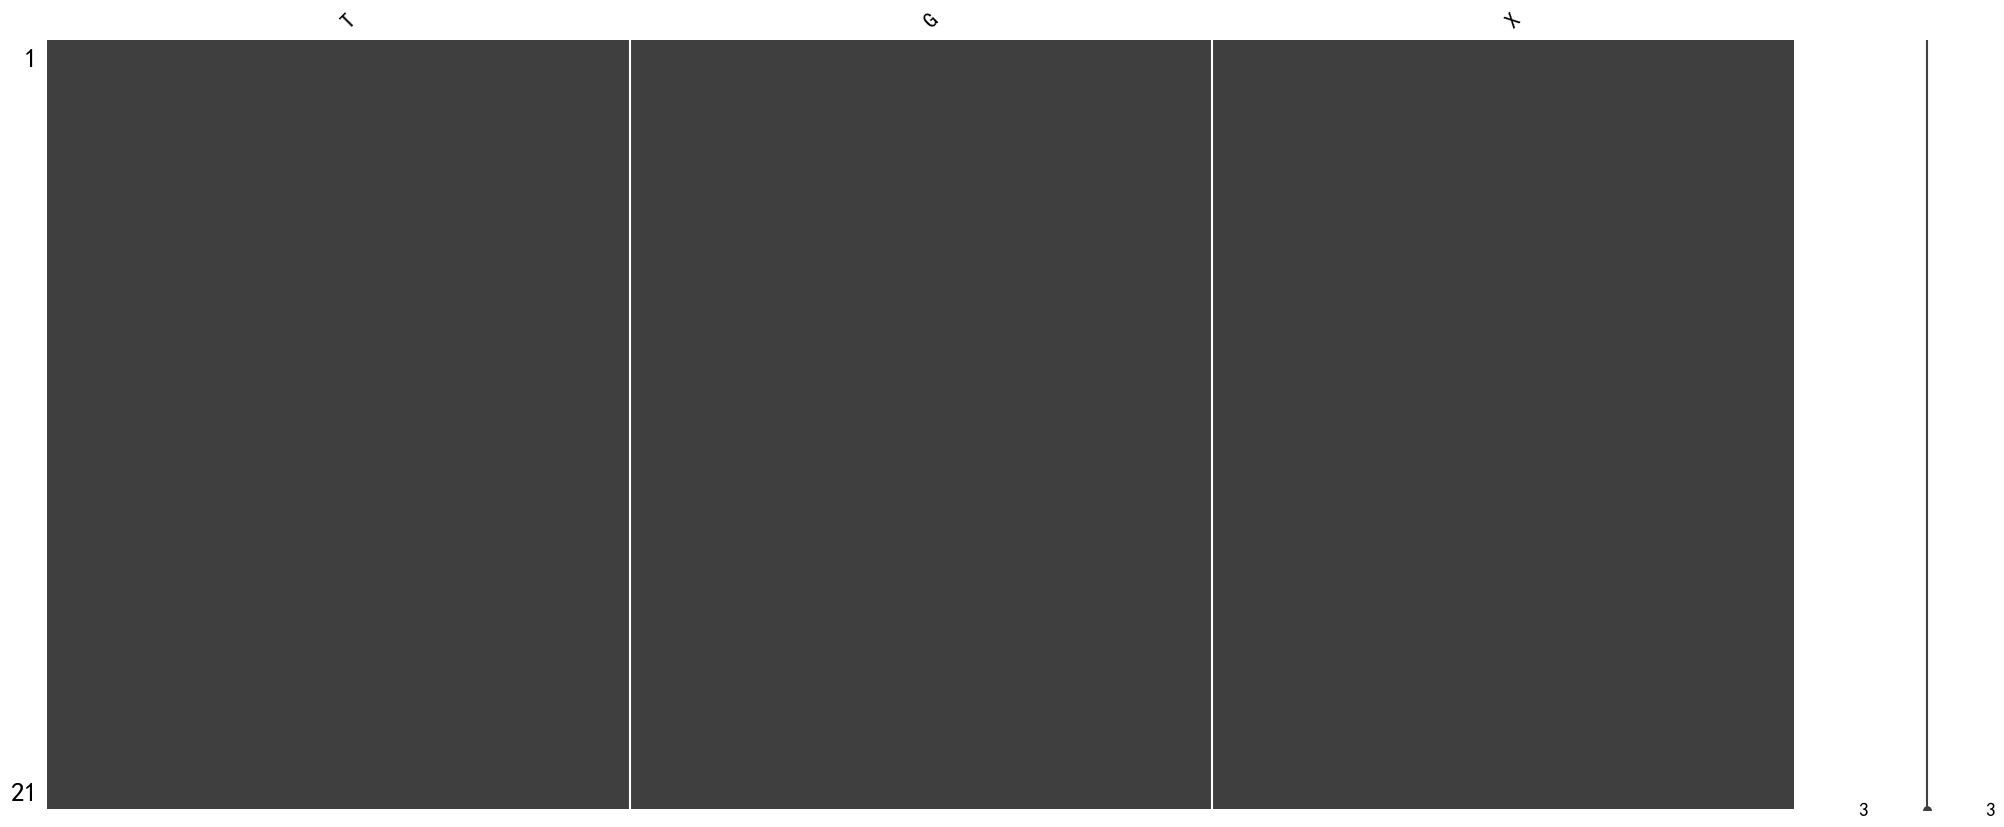

<Figure size 640x480 with 0 Axes>

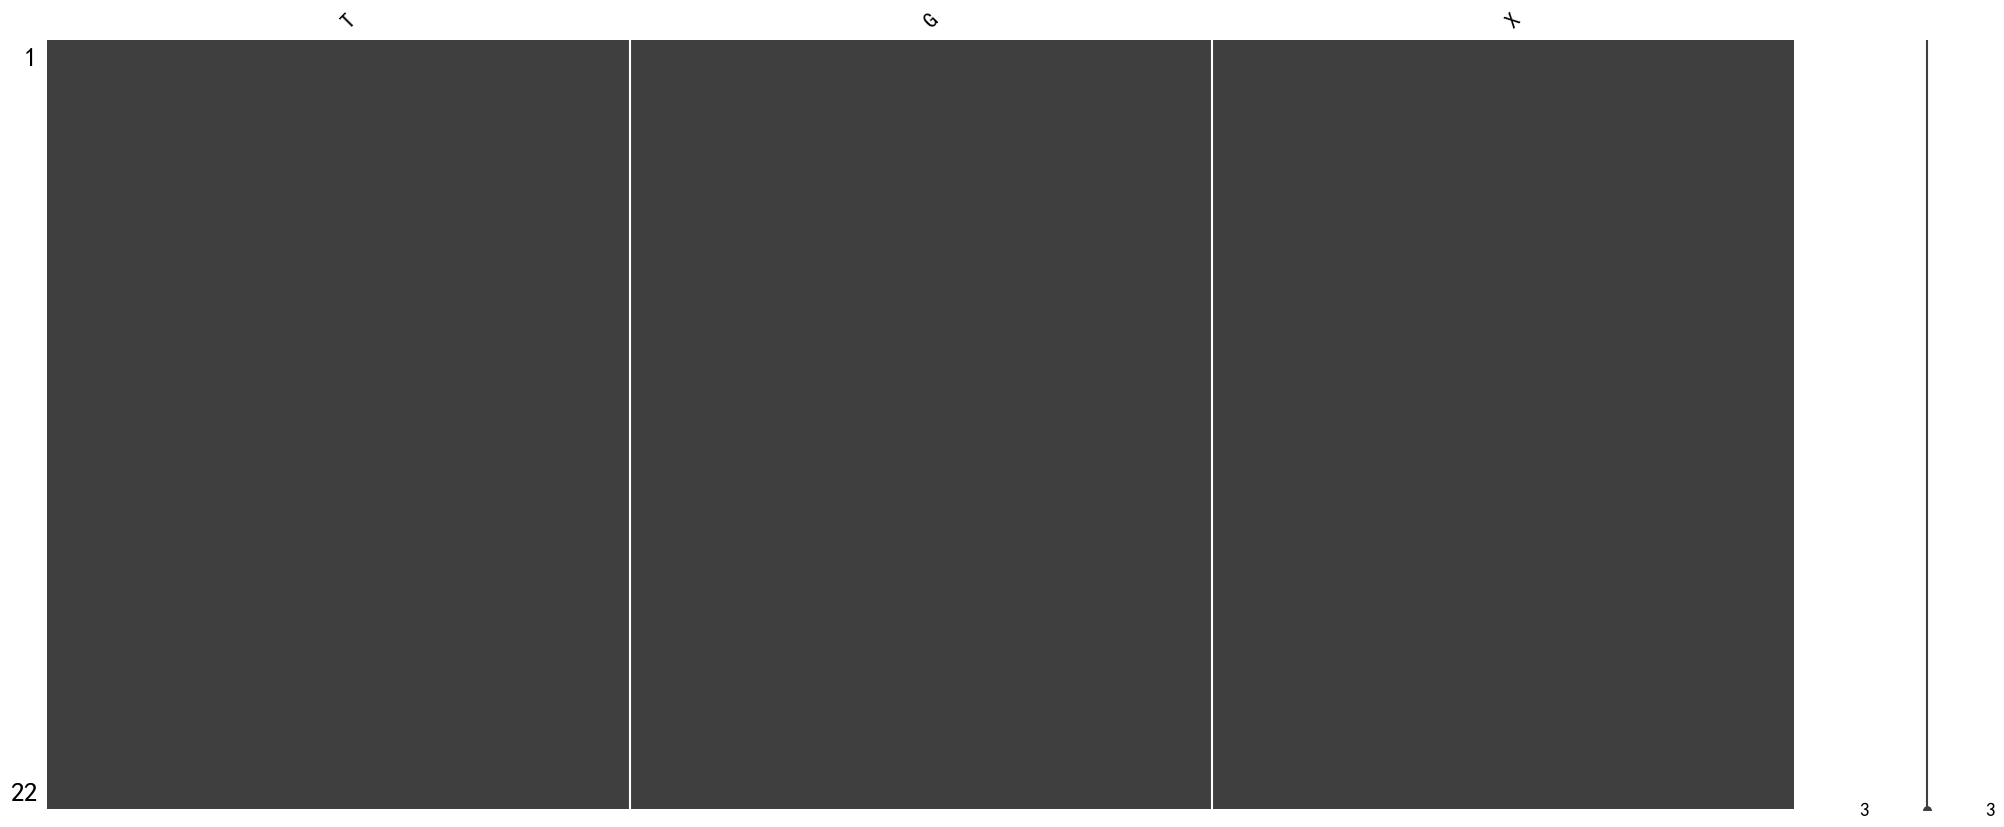

<Figure size 640x480 with 0 Axes>

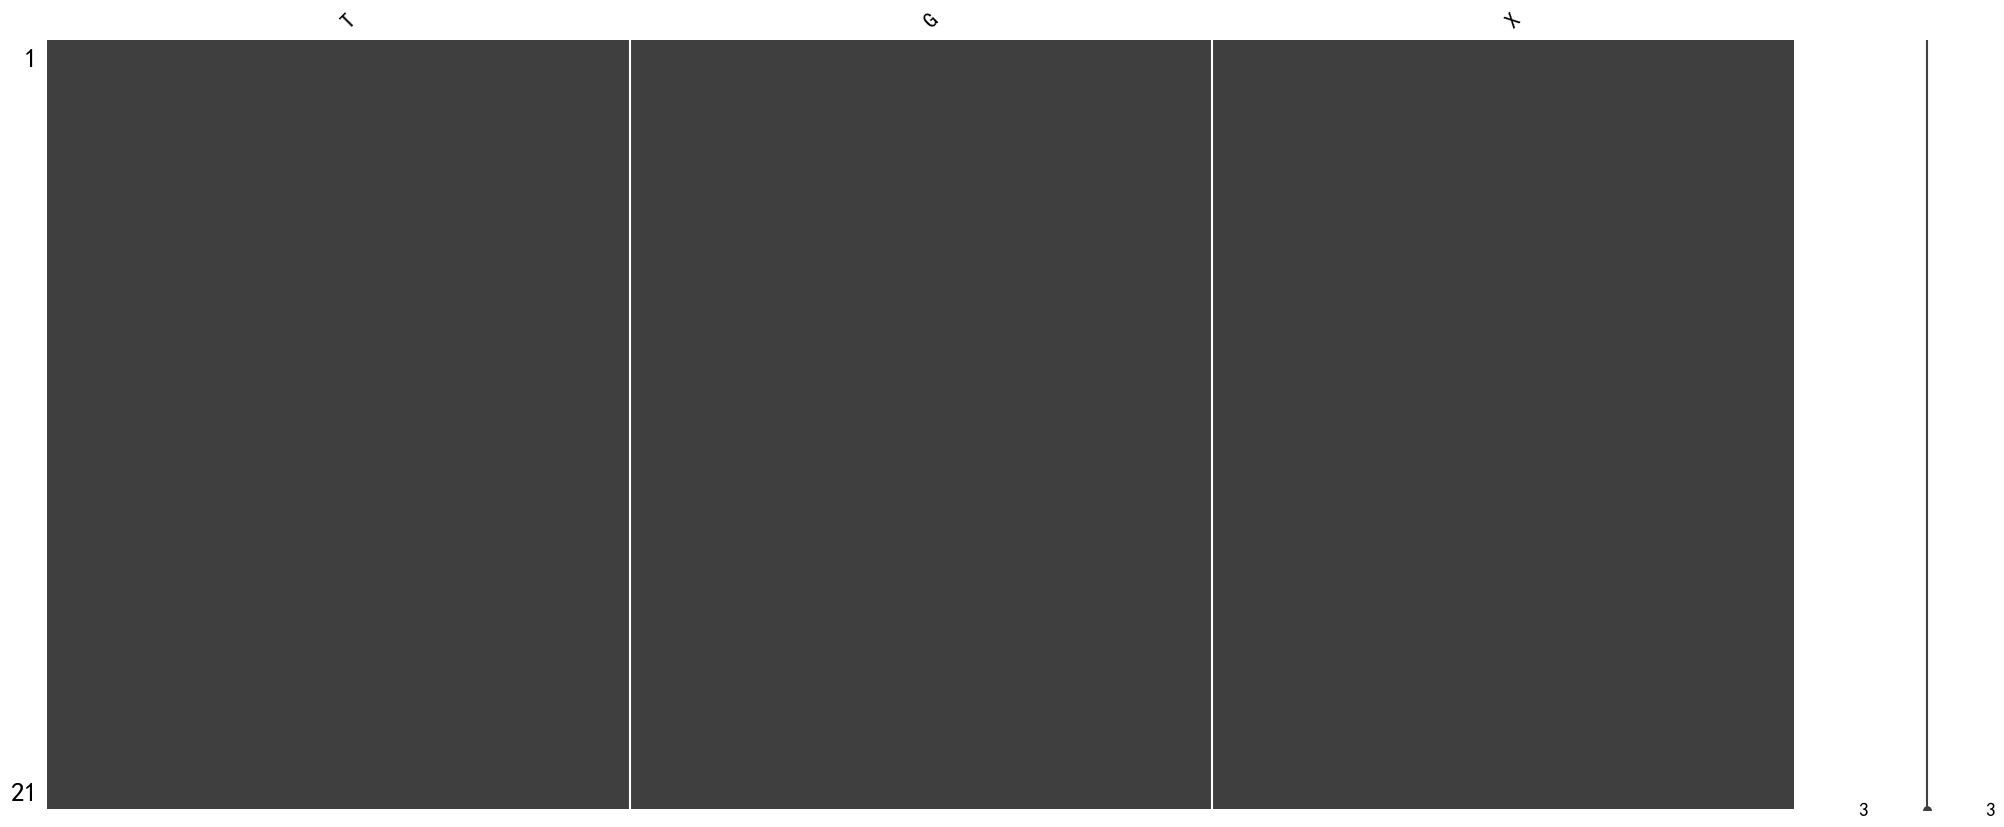

<Figure size 640x480 with 0 Axes>

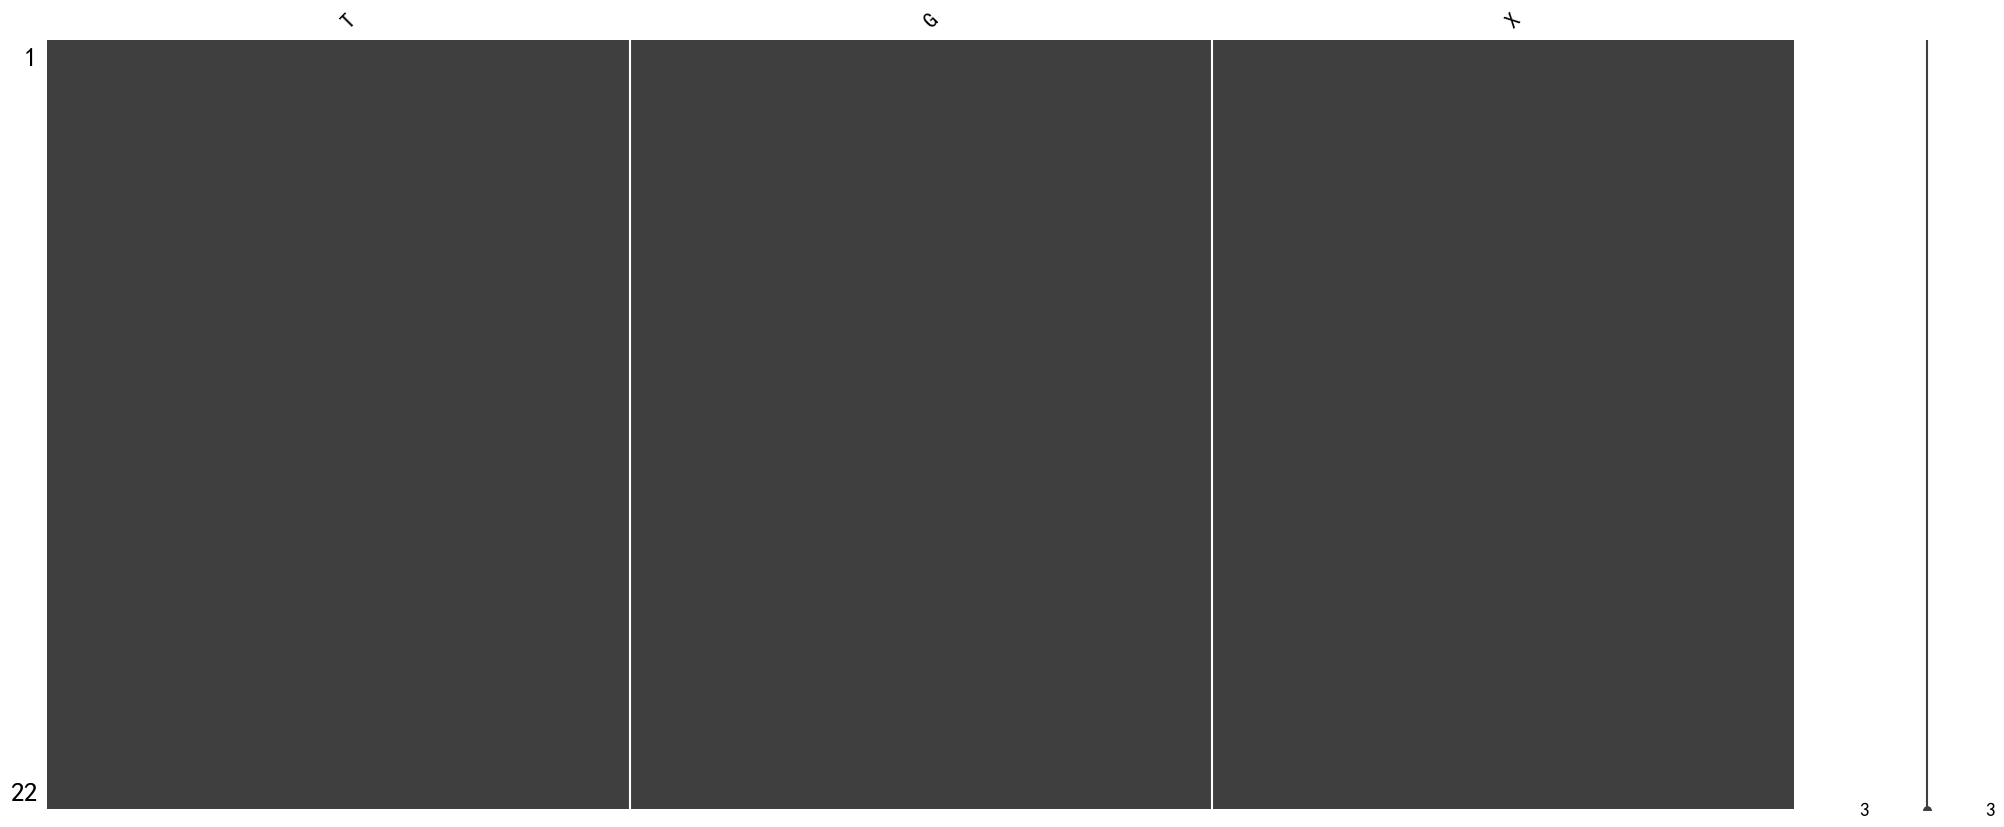

<Figure size 640x480 with 0 Axes>

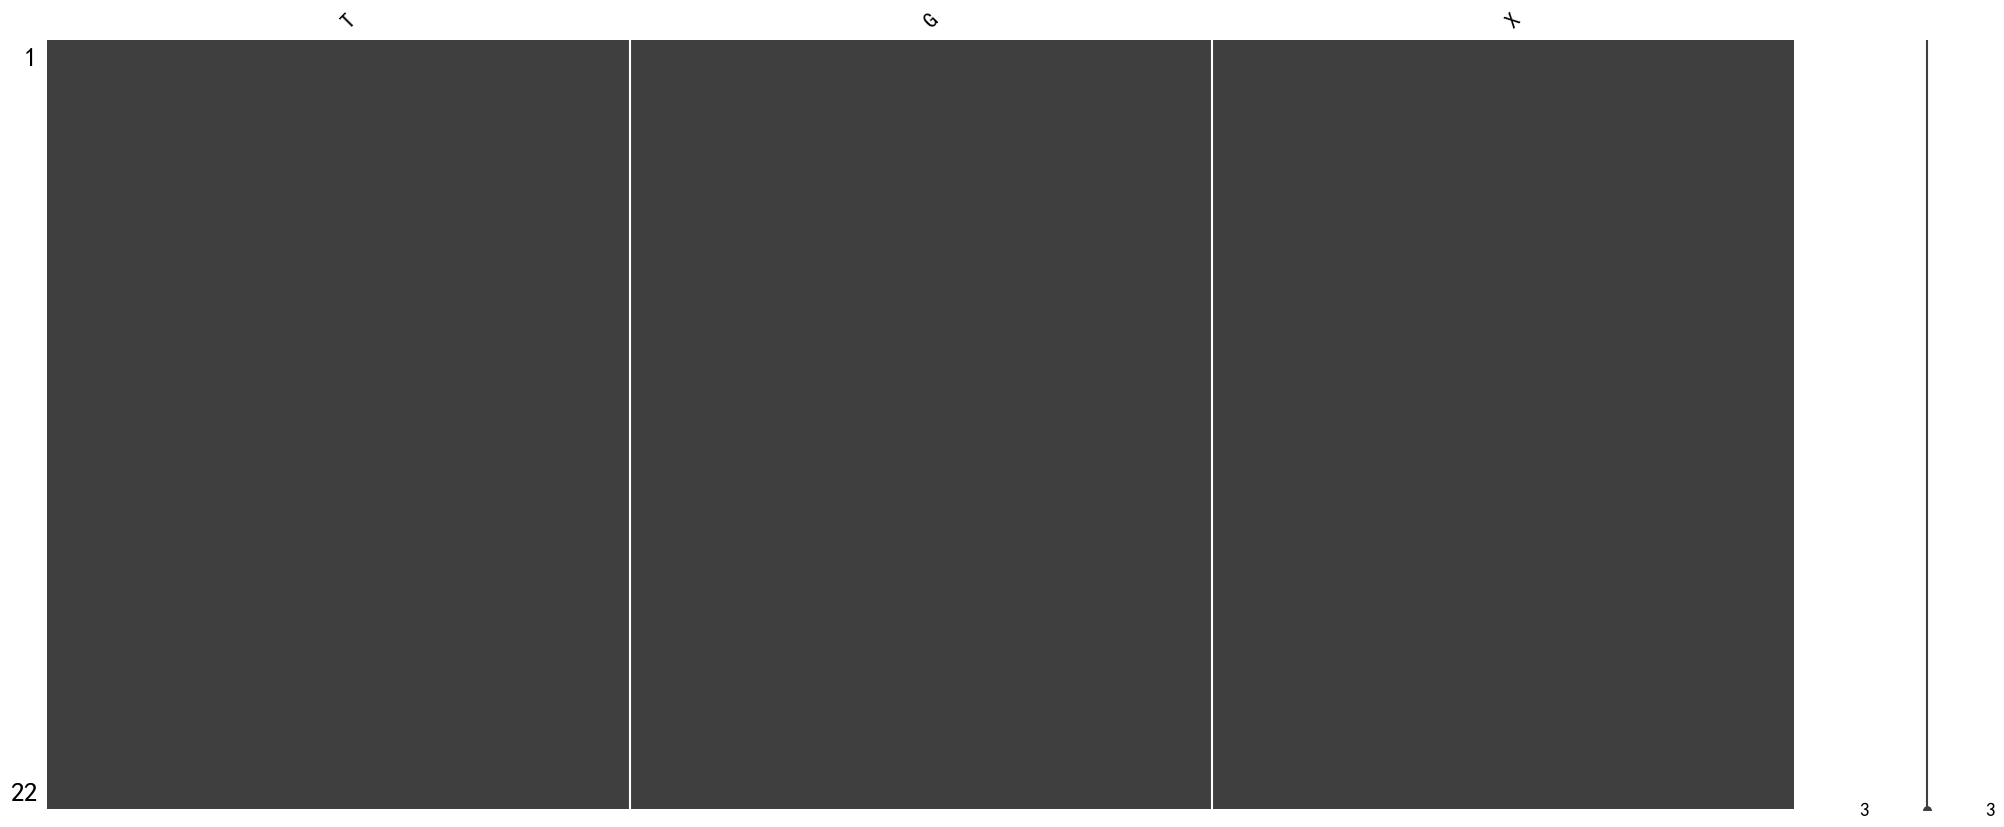

<Figure size 640x480 with 0 Axes>

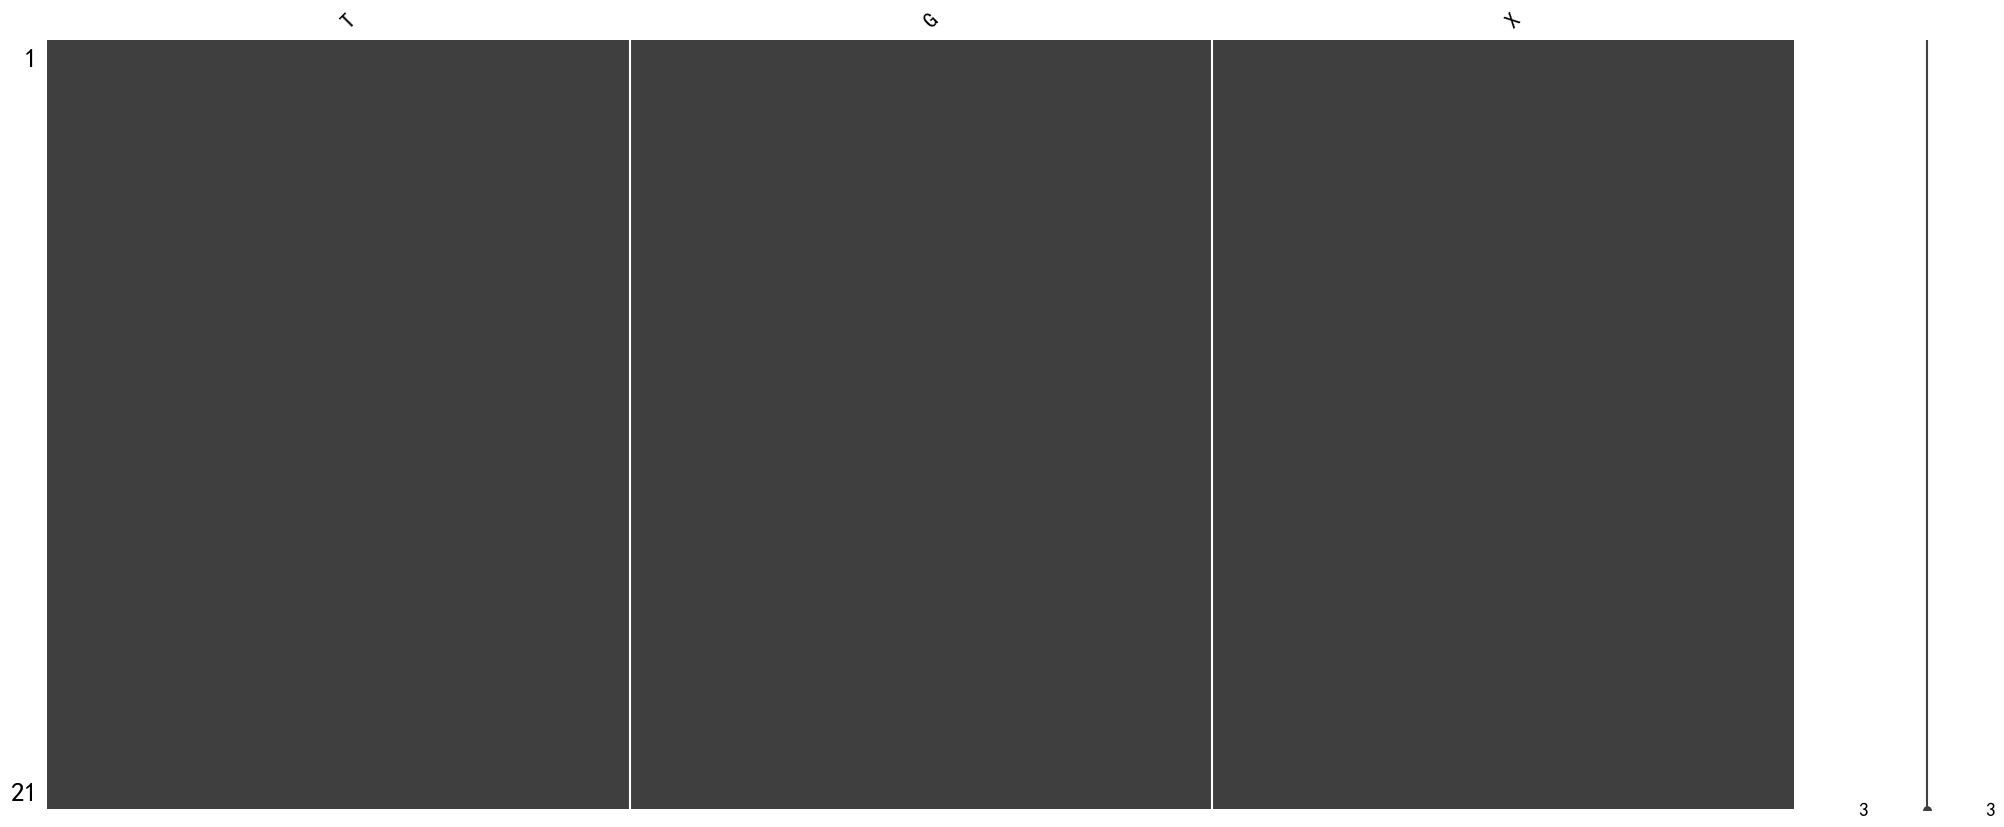

<Figure size 640x480 with 0 Axes>

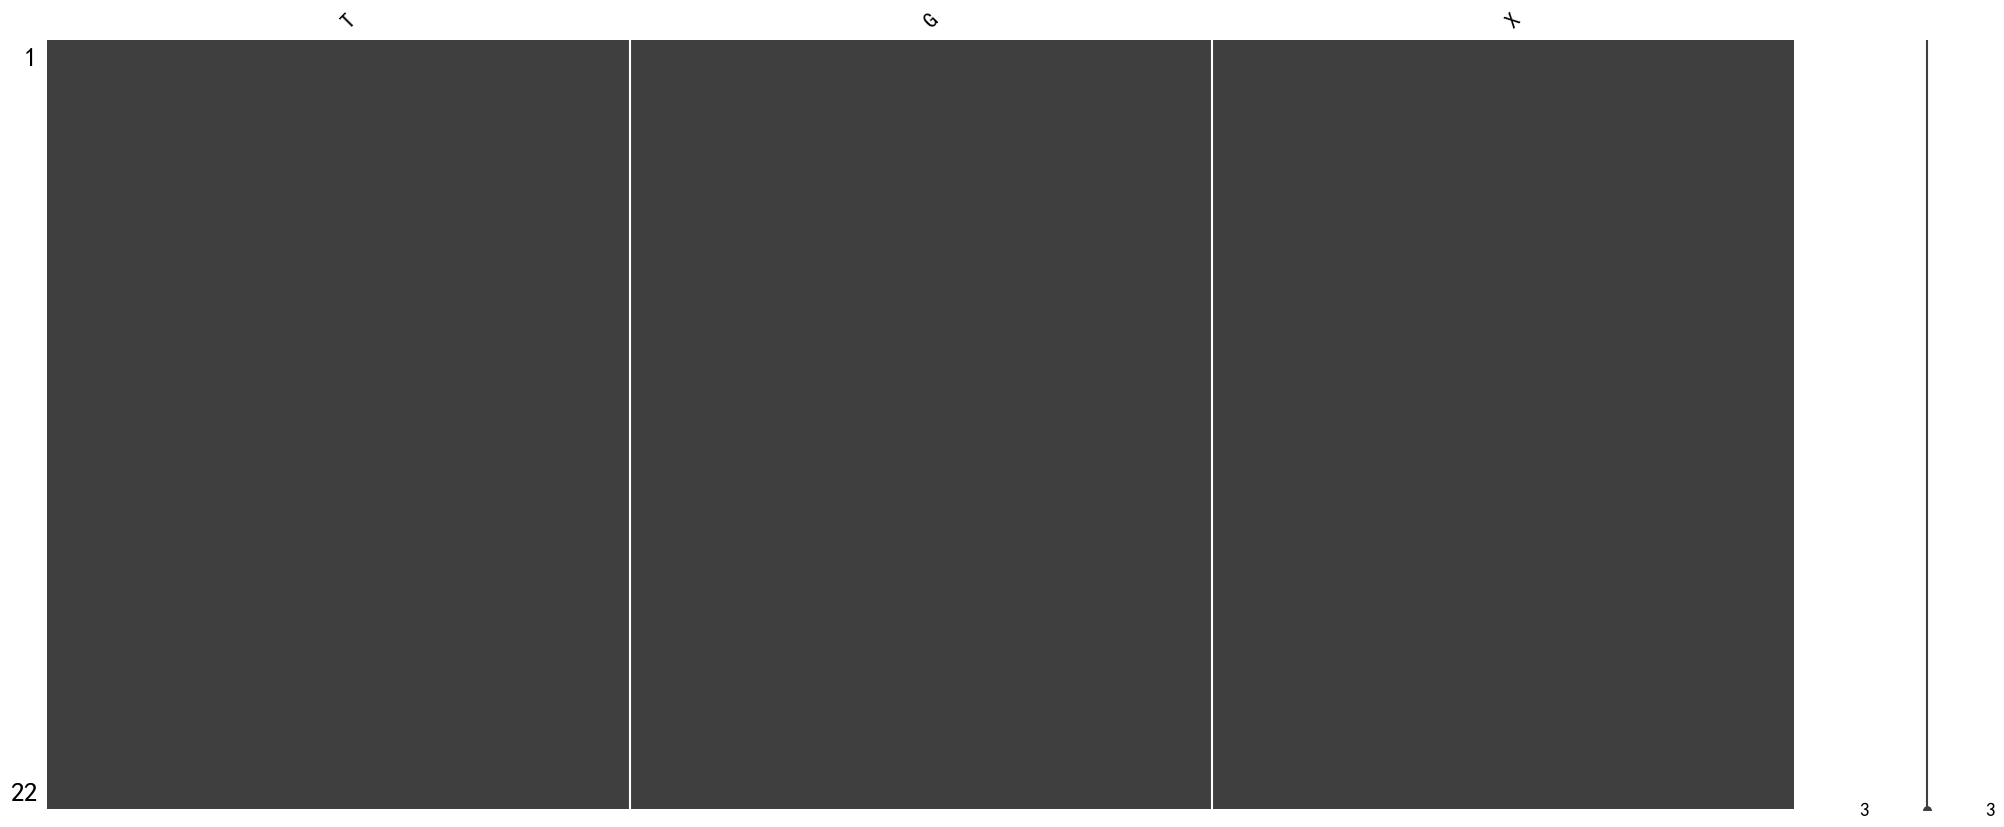

<Figure size 640x480 with 0 Axes>

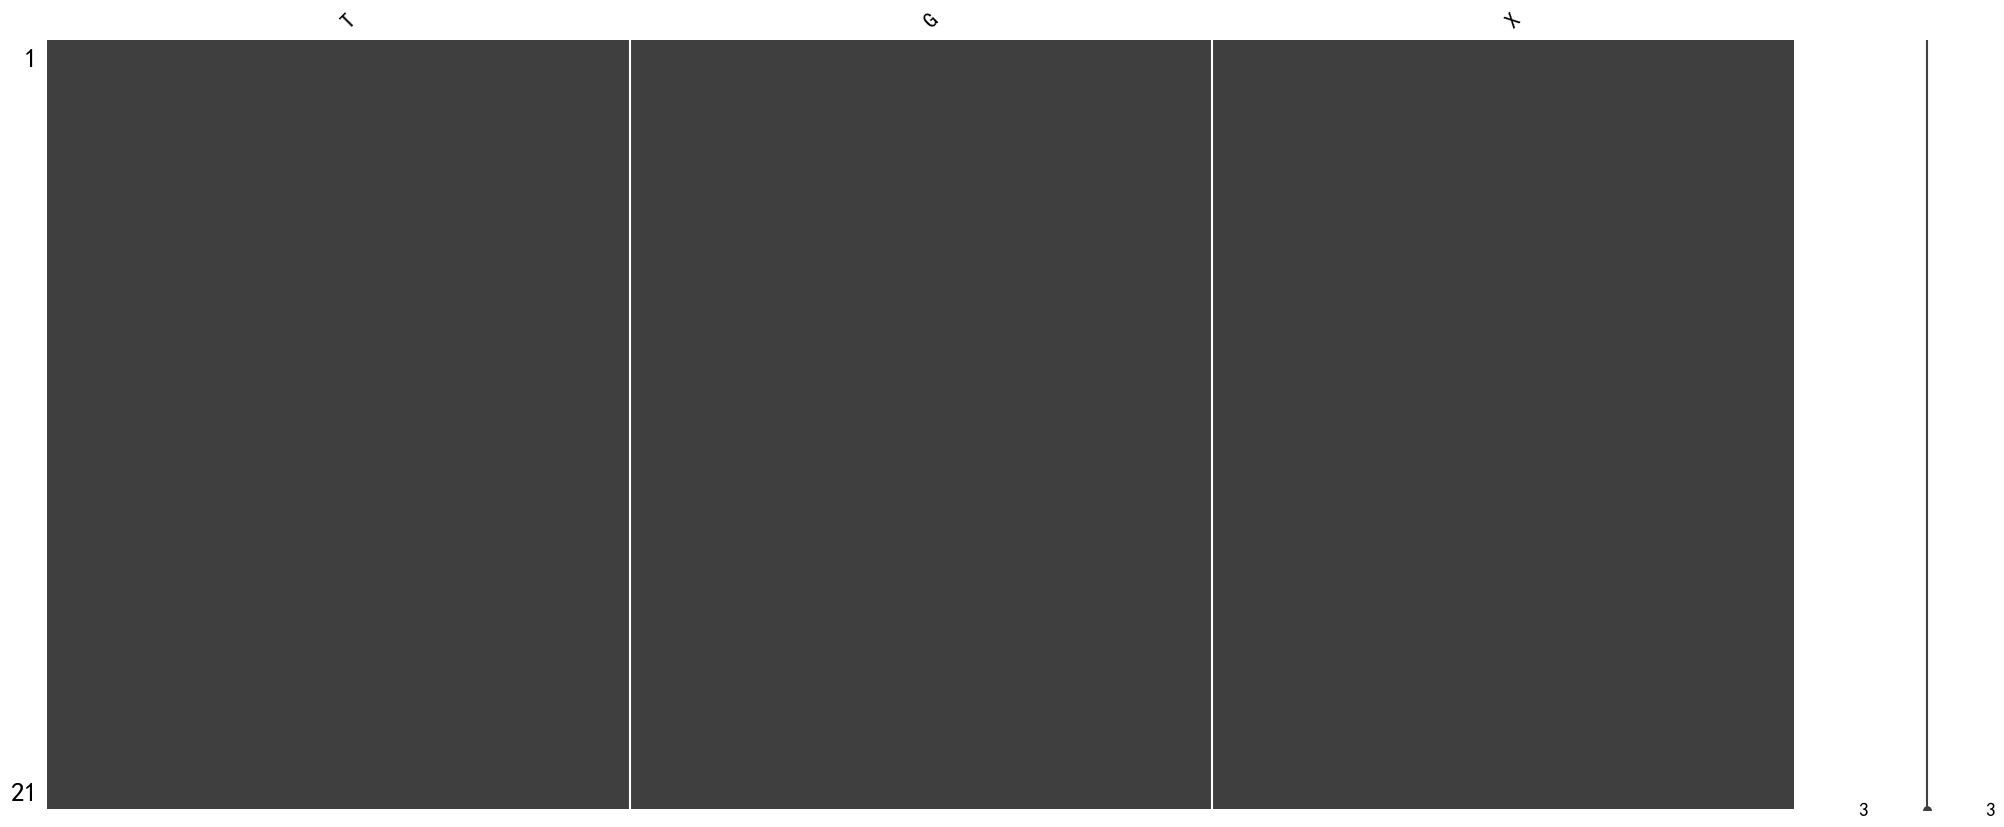

<Figure size 640x480 with 0 Axes>

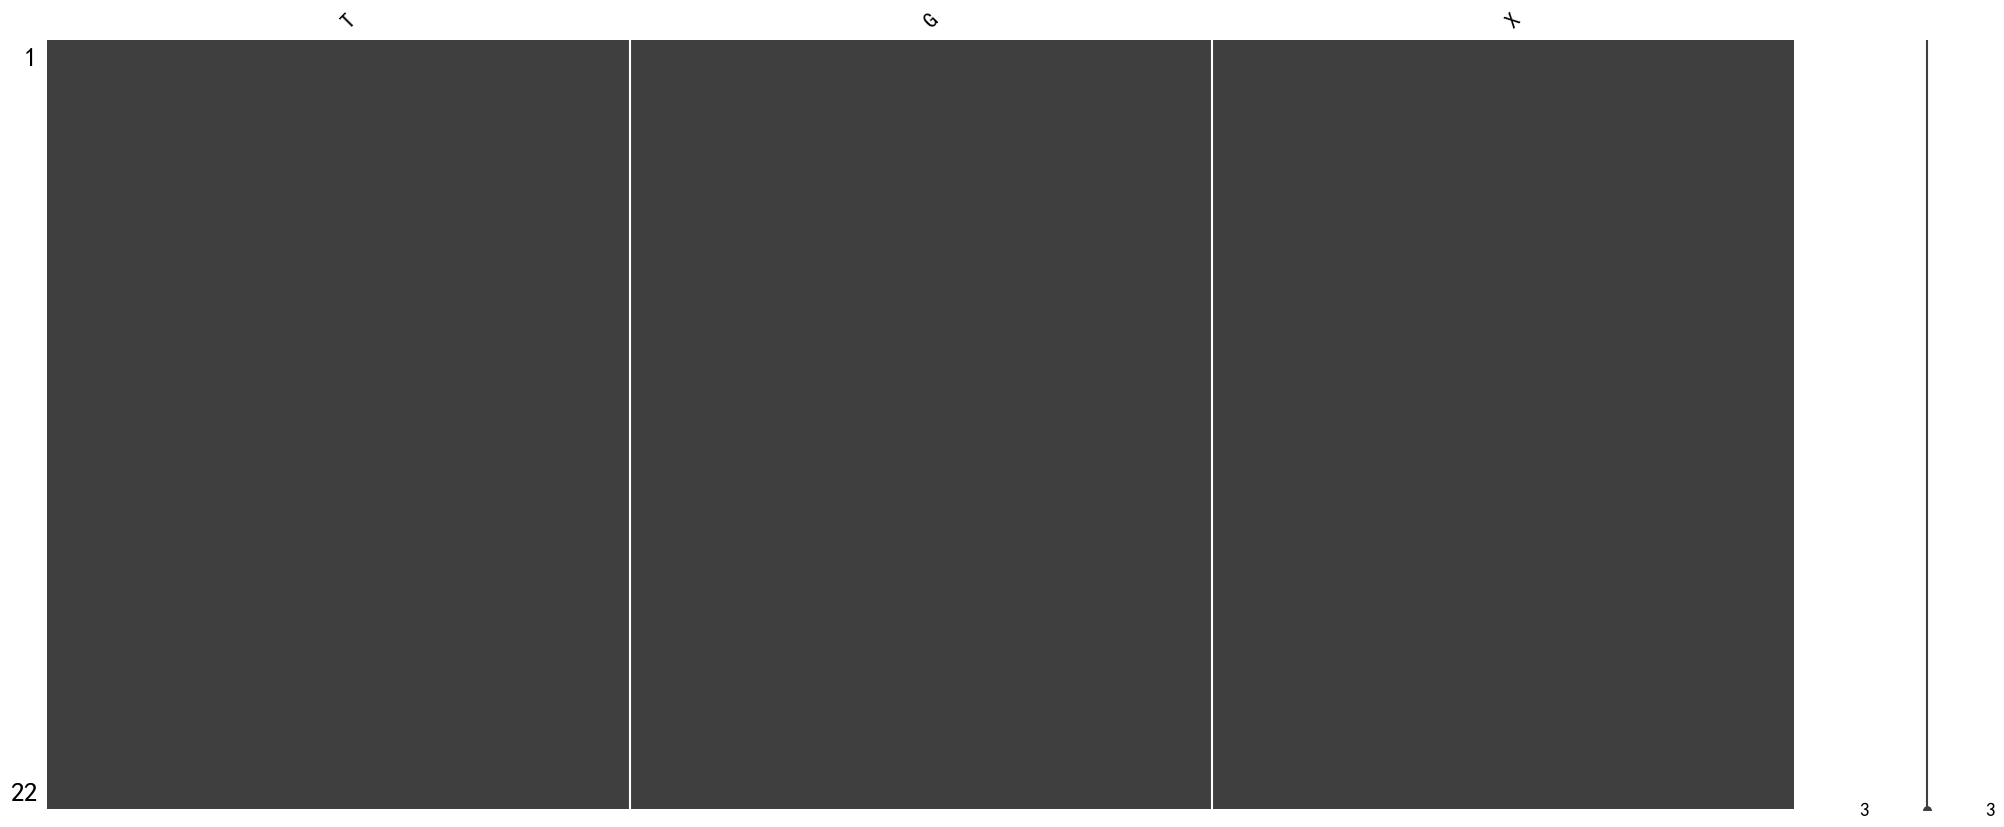

<Figure size 640x480 with 0 Axes>

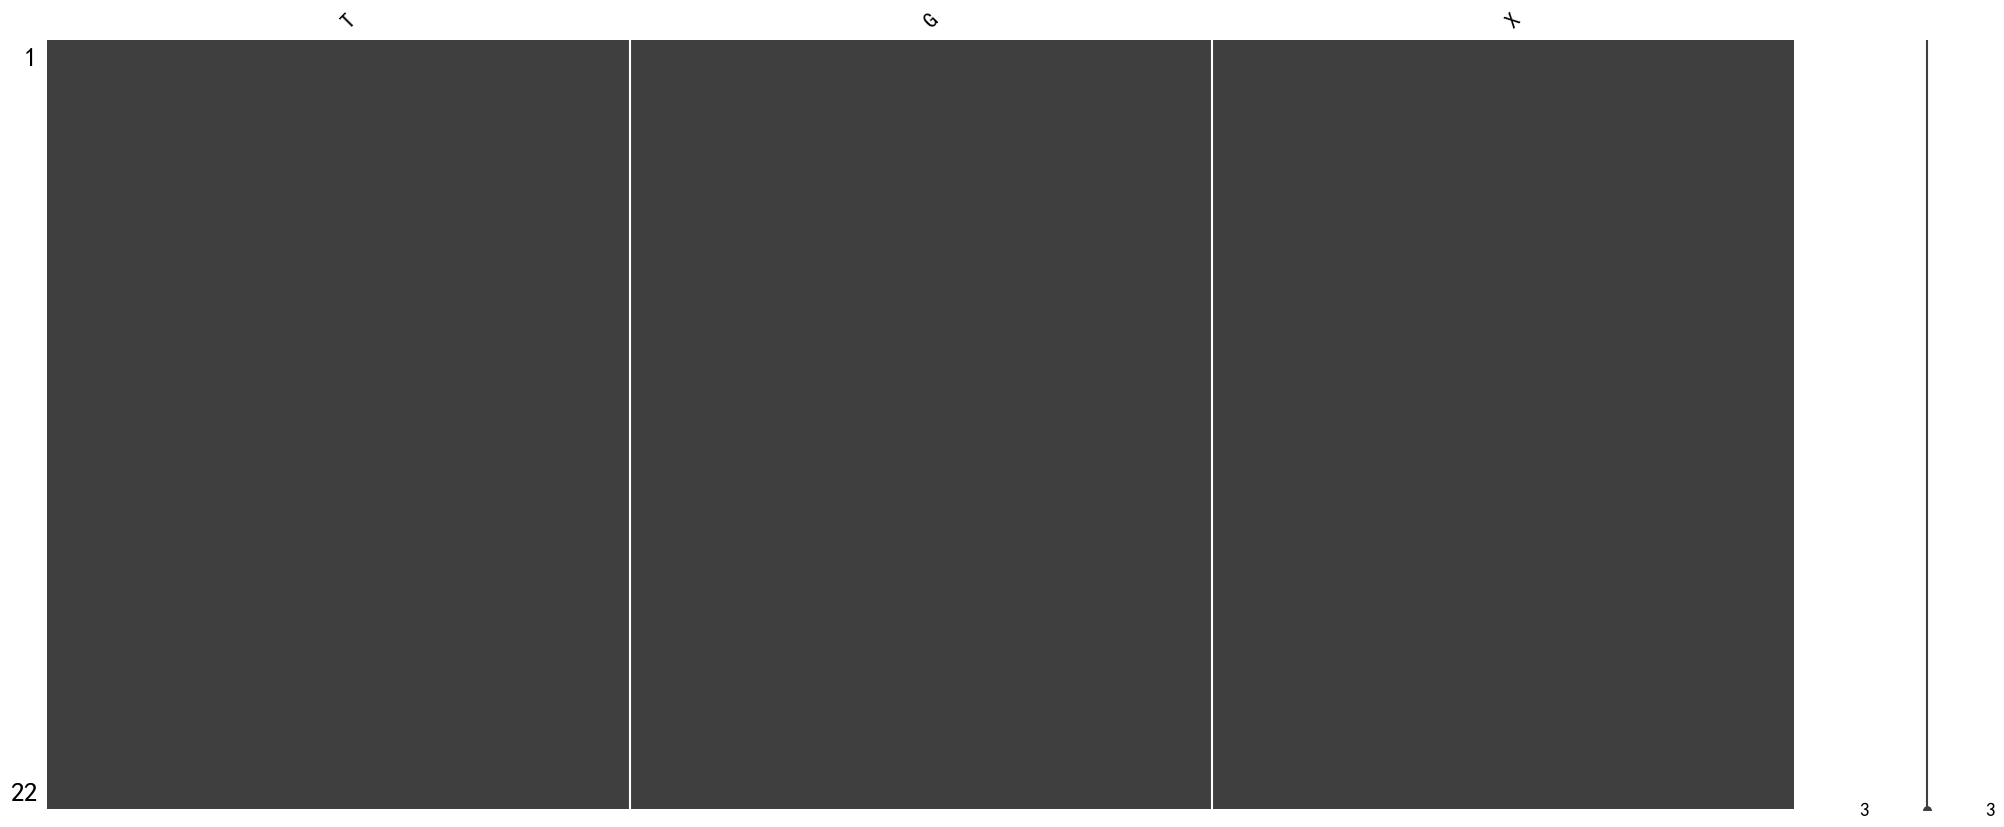

In [3]:
RETRAIN = True
# RETRAIN = False
tangnaihai = pd.read_csv('../data/tangnaihai_monthly_flow.csv',index_col=['date'], parse_dates=['date'])
guide = pd.read_csv('../data/guide_monthly_flow.csv',index_col=['date'], parse_dates=['date'])
xunhua = pd.read_csv('../data/xunhua_monthly_flow.csv',index_col=['date'], parse_dates=['date'])
tangnaihai.columns=['T']
guide.columns=['G']
xunhua.columns=['X']
df = pd.concat([tangnaihai,guide,xunhua],axis=1)
df.to_csv('../data/all_temp.csv')

df = df.loc[:'1985-12-31']
# df.index.name = 'ID'
# STCD = df.pop('STCD')
# STNM = df.pop('STNM')

model_path = '../models/extension/xgboost/'
if not os.path.exists(model_path):
    os.makedirs(model_path)

df_raw = df.copy()

fig = px.line(df, labels={'time': '时间', 'value': '值'},)
fig.update_layout(
    template=plot_template,legend=dict(orientation='h',x=0,y=1.5))
fig.show()


plt.figure()
msno.matrix(df)
plt.figure()
msno.matrix(df.iloc[:int(df.shape[0]*0.05),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.05):int(df.shape[0]*0.1),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.1):int(df.shape[0]*0.15),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.15):int(df.shape[0]*0.2),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.2):int(df.shape[0]*0.25),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.25):int(df.shape[0]*0.3),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.3):int(df.shape[0]*0.35),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.35):int(df.shape[0]*0.4),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.4):int(df.shape[0]*0.45),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.45):int(df.shape[0]*0.5),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.5):int(df.shape[0]*0.55),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.55):int(df.shape[0]*0.6),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.6):int(df.shape[0]*0.65),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.65):int(df.shape[0]*0.7),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.7):int(df.shape[0]*0.75),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.75):int(df.shape[0]*0.8),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.8):int(df.shape[0]*0.85),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.85):int(df.shape[0]*0.9),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.9):int(df.shape[0]*0.95),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.95):,:])

[I 2024-05-21 23:02:24,578] A new study created in memory with name: no-name-c5035696-984d-4432-8e15-f0c1a219ed50


Index(['T', 'G'], dtype='object')
2024-05-21 23:02:24.578383


[I 2024-05-21 23:02:25,618] Trial 0 finished with value: 525.5083202617458 and parameters: {'n_estimators': 400, 'max_depth': 26, 'min_child_weight': 8, 'learning_rate': 5.3814007267693083e-08, 'subsample': 0.8436042545800571, 'colsample_bytree': 0.6436624997117287, 'reg_alpha': 6.614635053980963, 'reg_lambda': 6.4688517168380555, 'gamma': 0.7}. Best is trial 0 with value: 525.5083202617458.
[I 2024-05-21 23:02:25,730] Trial 1 finished with value: 479.7470287140355 and parameters: {'n_estimators': 50, 'max_depth': 17, 'min_child_weight': 8, 'learning_rate': 0.0018469415489193624, 'subsample': 0.7727952470741652, 'colsample_bytree': 0.1562080459744147, 'reg_alpha': 4.795625709817577, 'reg_lambda': 1.9632716697595862, 'gamma': 0.8999999999999999}. Best is trial 1 with value: 479.7470287140355.
[I 2024-05-21 23:02:26,575] Trial 2 finished with value: 59.732857981926195 and parameters: {'n_estimators': 350, 'max_depth': 18, 'min_child_weight': 8, 'learning_rate': 0.023207095384274876, 'sub

Time taken: 0 hours 2 minutes and 52.62 seconds.
train nse: 0.9678540853396945
val nse: 0.9890638108678556


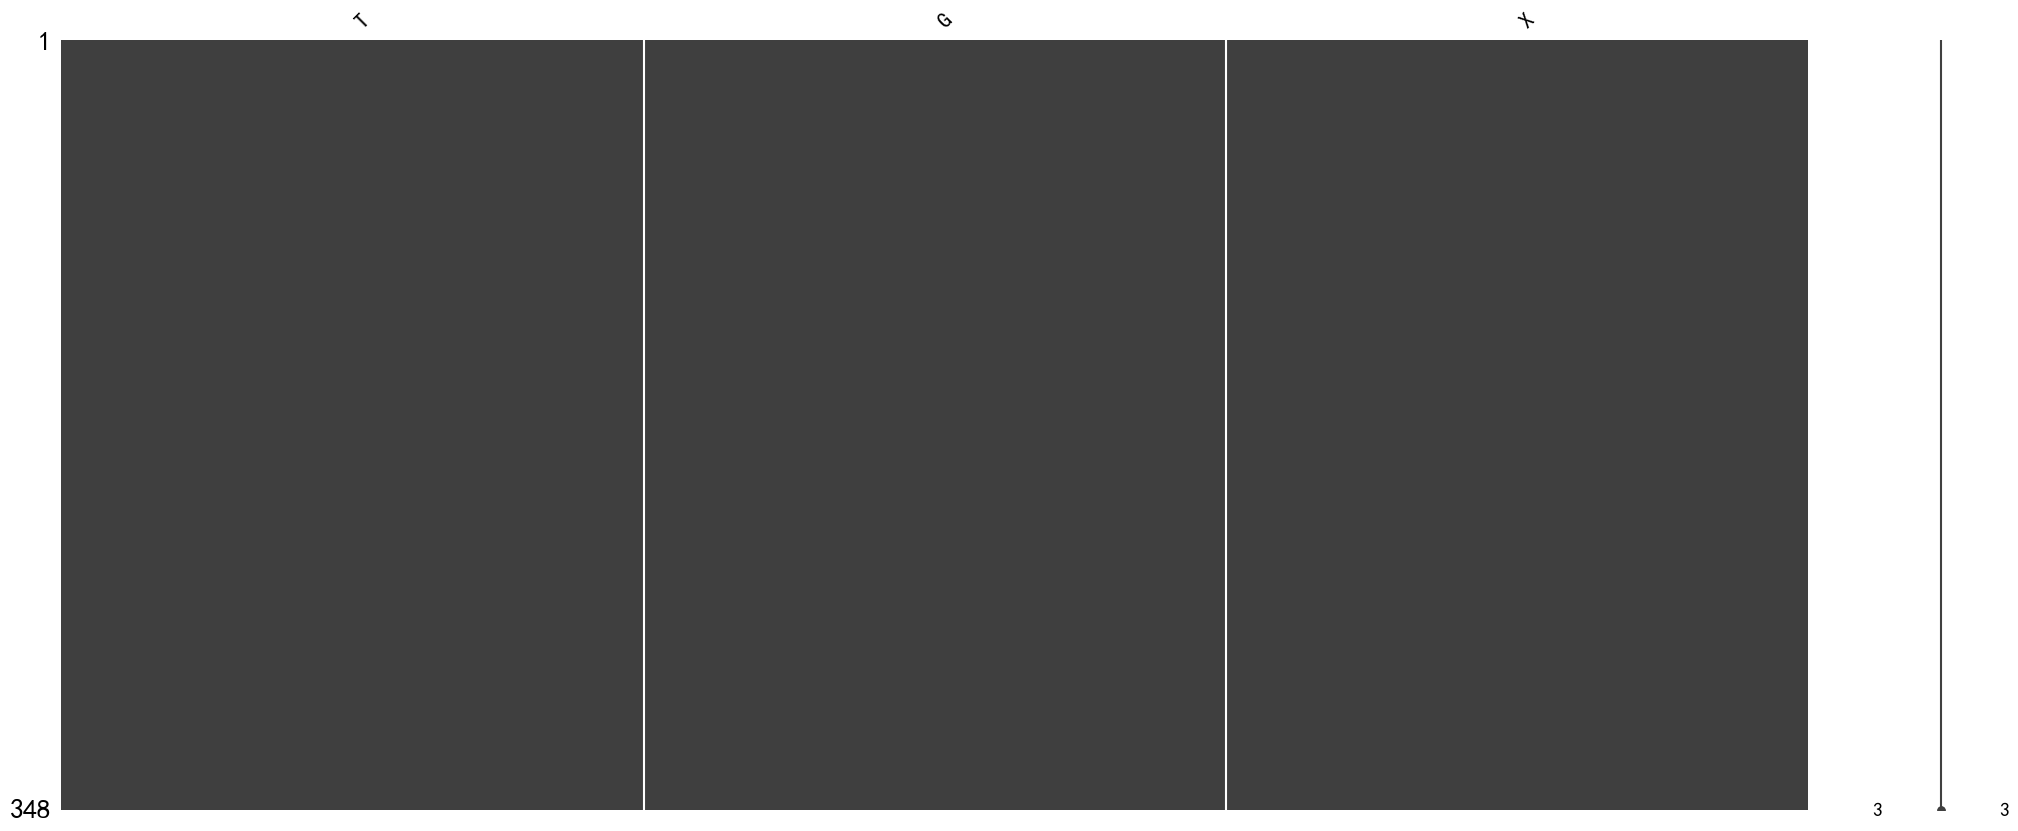

In [4]:
df_zf_model = df.copy()

df_zf_model = df_zf_model.dropna(axis=0, how='any')
msno.matrix(df_zf_model)

y = df_zf_model.pop('X')
X = df_zf_model
print(X.columns)


model_name = 'model0'
if RETRAIN:
    # split data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2023,shuffle=True)
    start_time = timer(None)
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: tuner(trial, x_train,y_train,x_test,y_test), n_trials=100)
    timer(start_time)
    model,train_nse,val_nse = rebuild(study, x_train,y_train,x_test,y_test)
    result = {}
    result['model'] = model
    result['train_nse'] = train_nse
    result['val_nse'] = val_nse
    dump(result, model_path+'{}.pkl'.format(model_name))
else:
    result = load(model_path+'{}.pkl'.format(model_name))
    model = result['model']
    print('train_nse:',result['train_nse'])
    print('val_nse:',result['val_nse'])

<Axes: >

<Figure size 640x480 with 0 Axes>

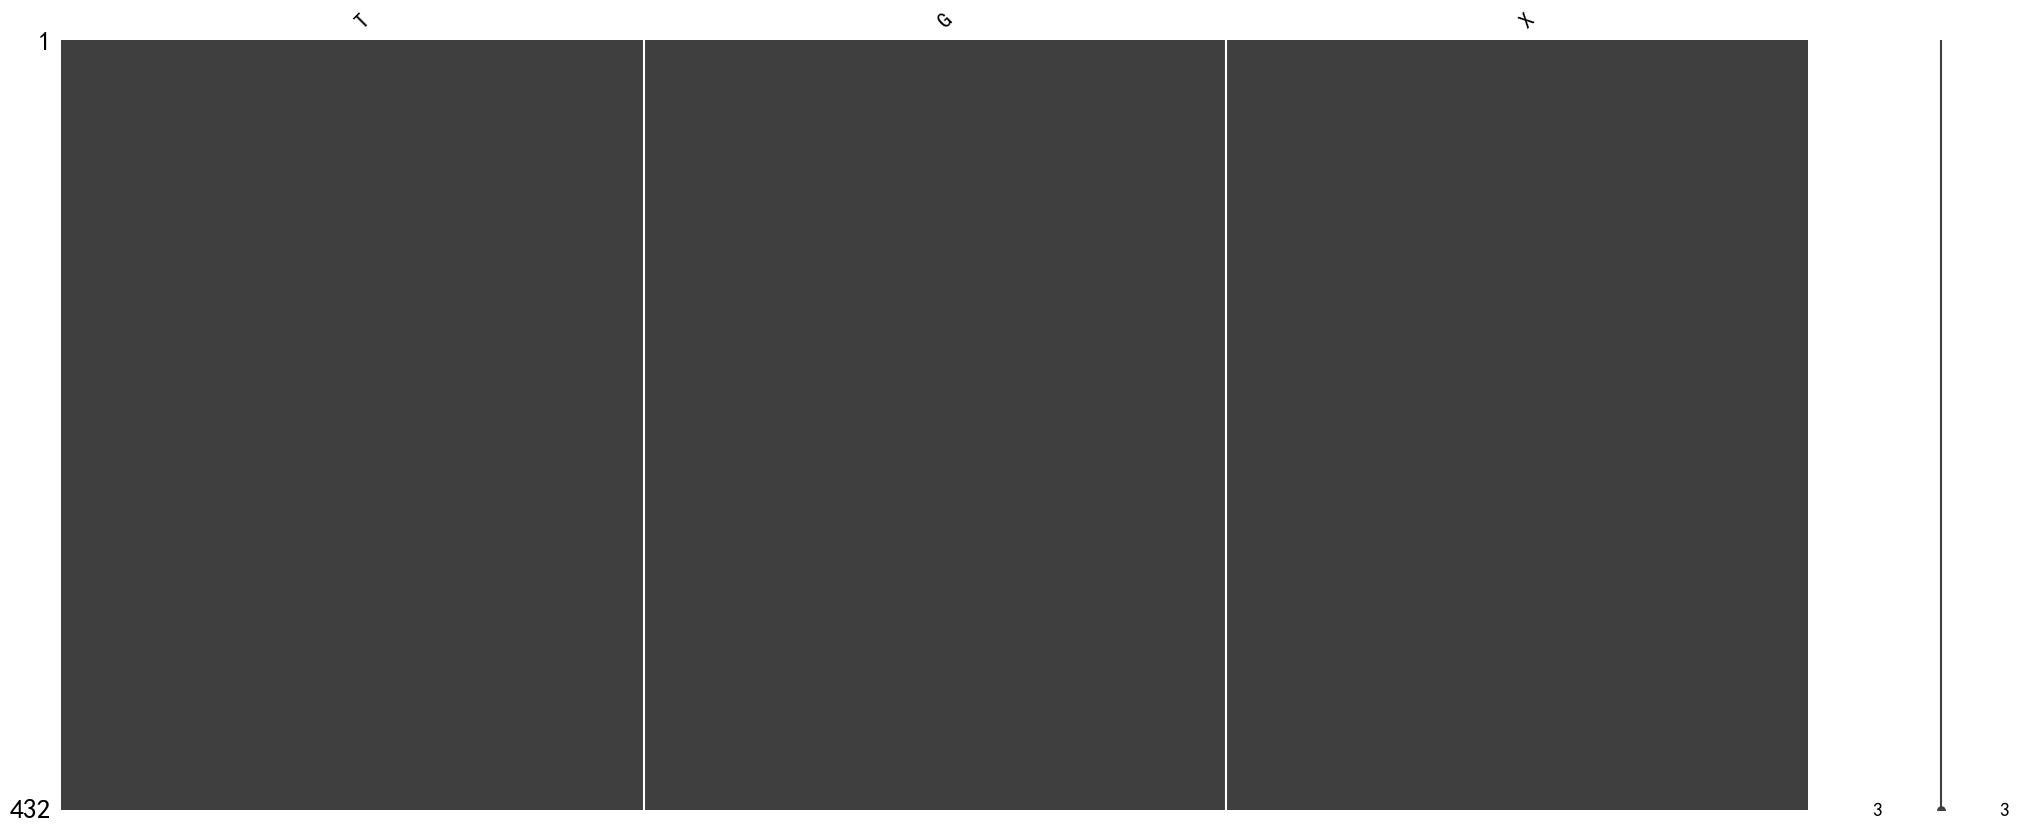

<Figure size 640x480 with 0 Axes>

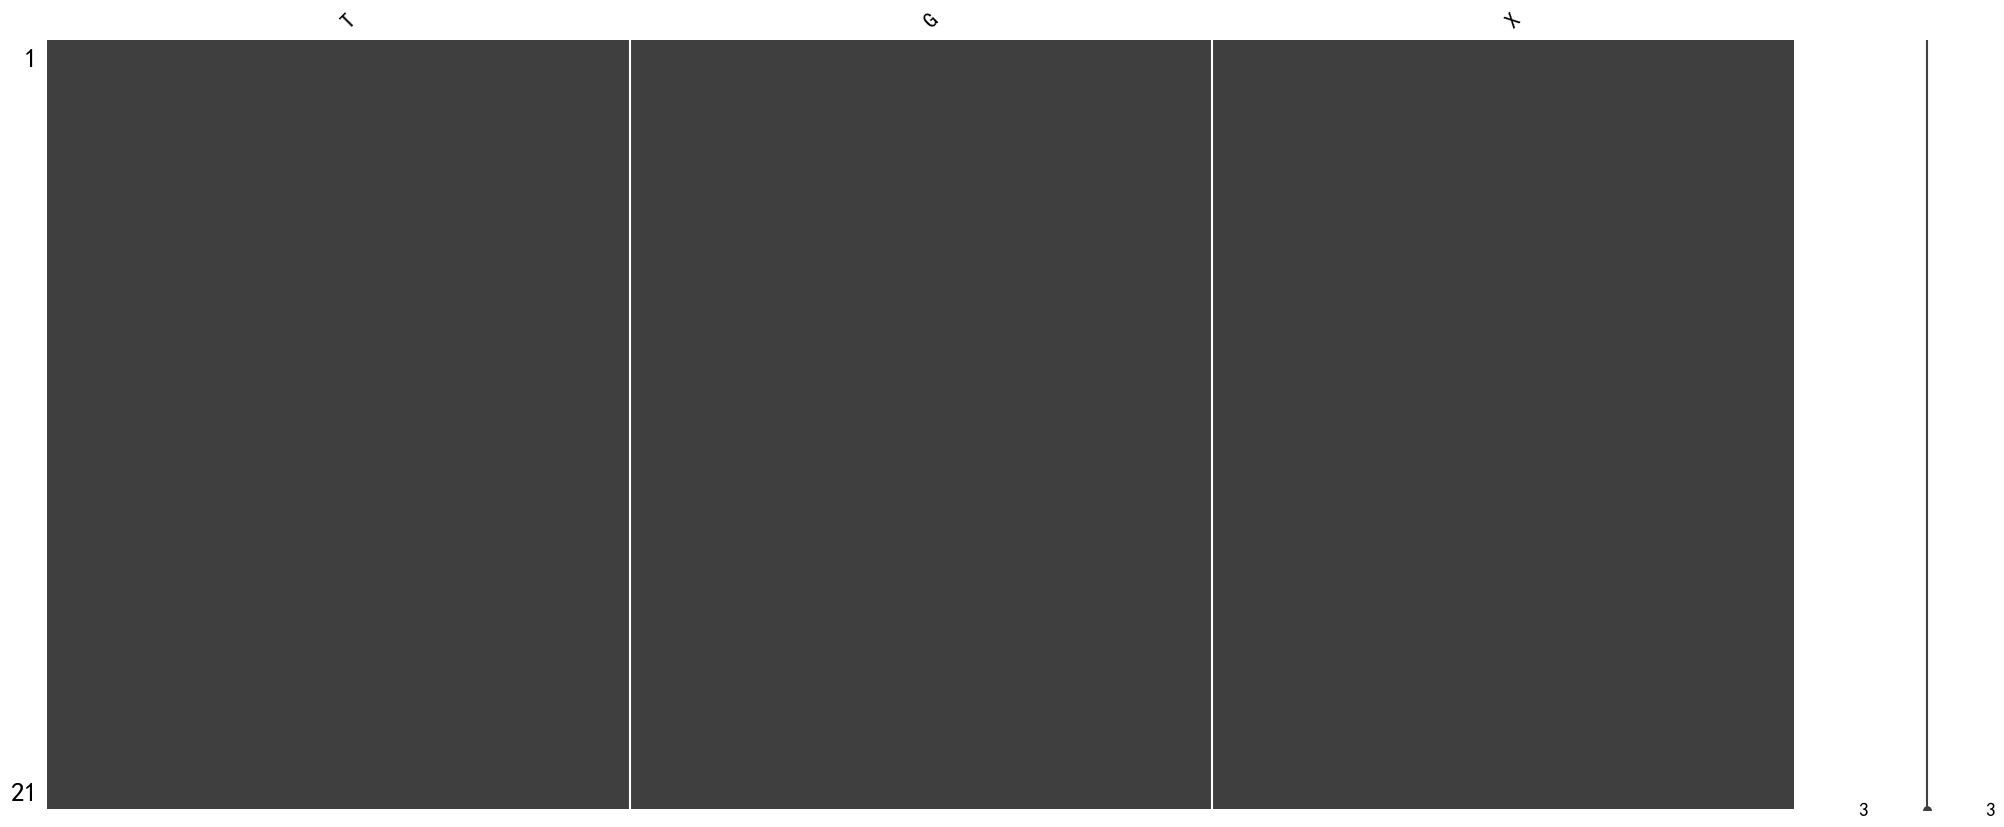

<Figure size 640x480 with 0 Axes>

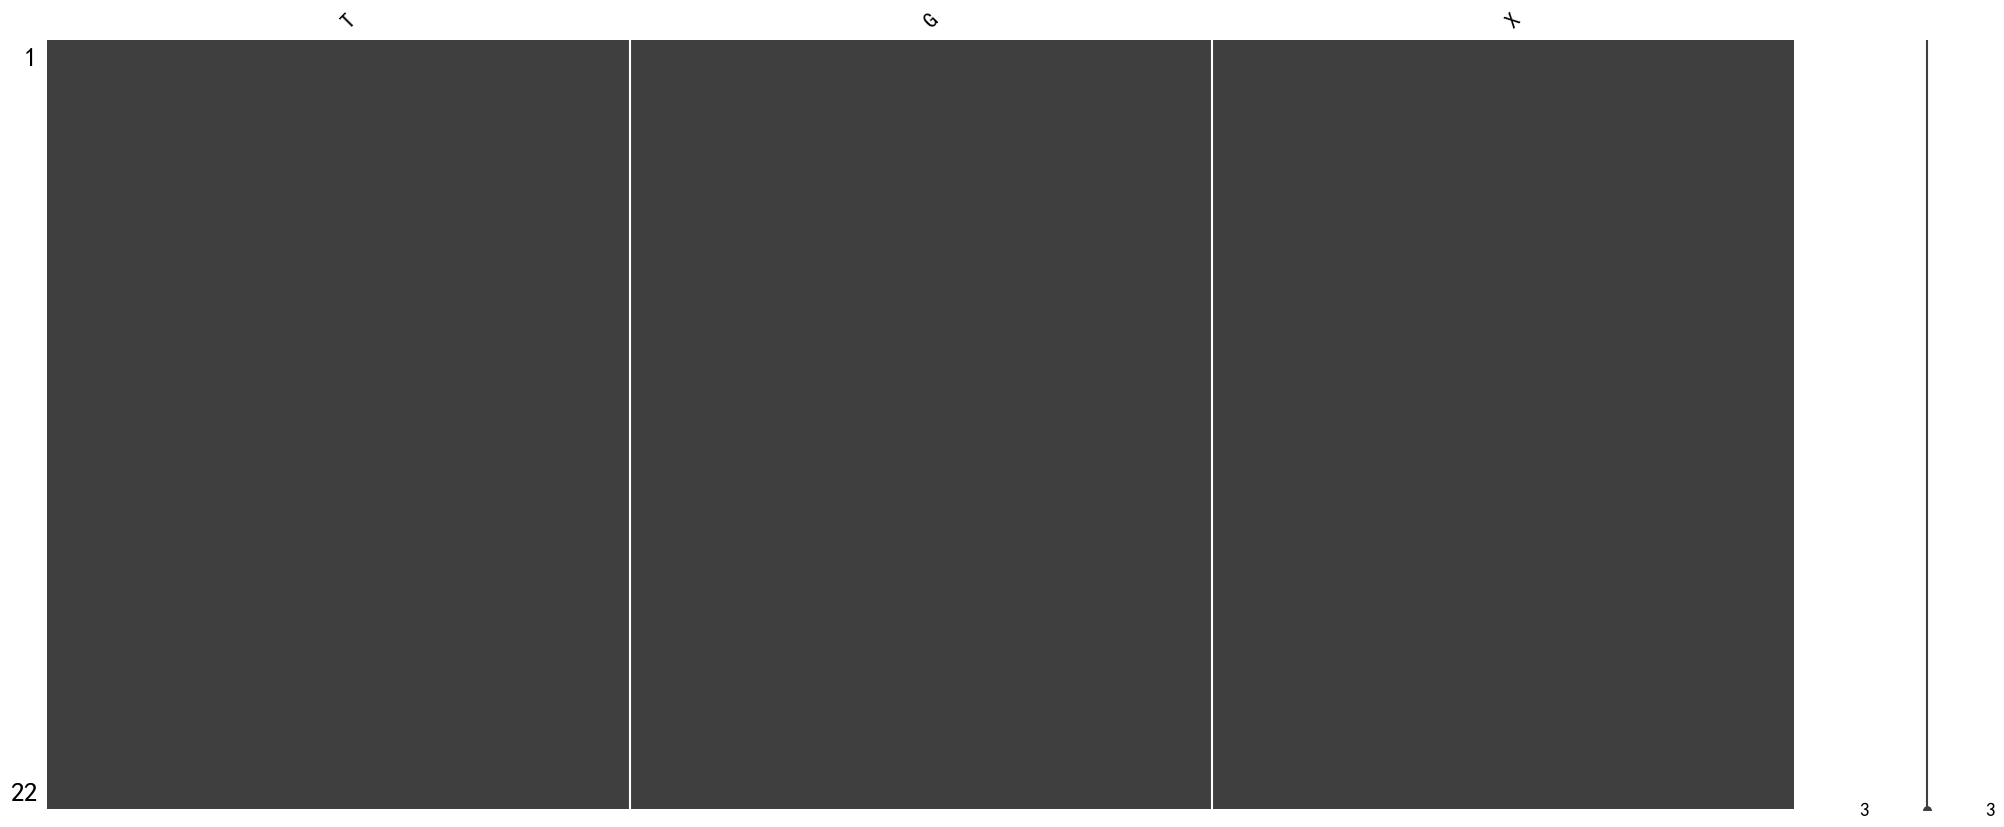

<Figure size 640x480 with 0 Axes>

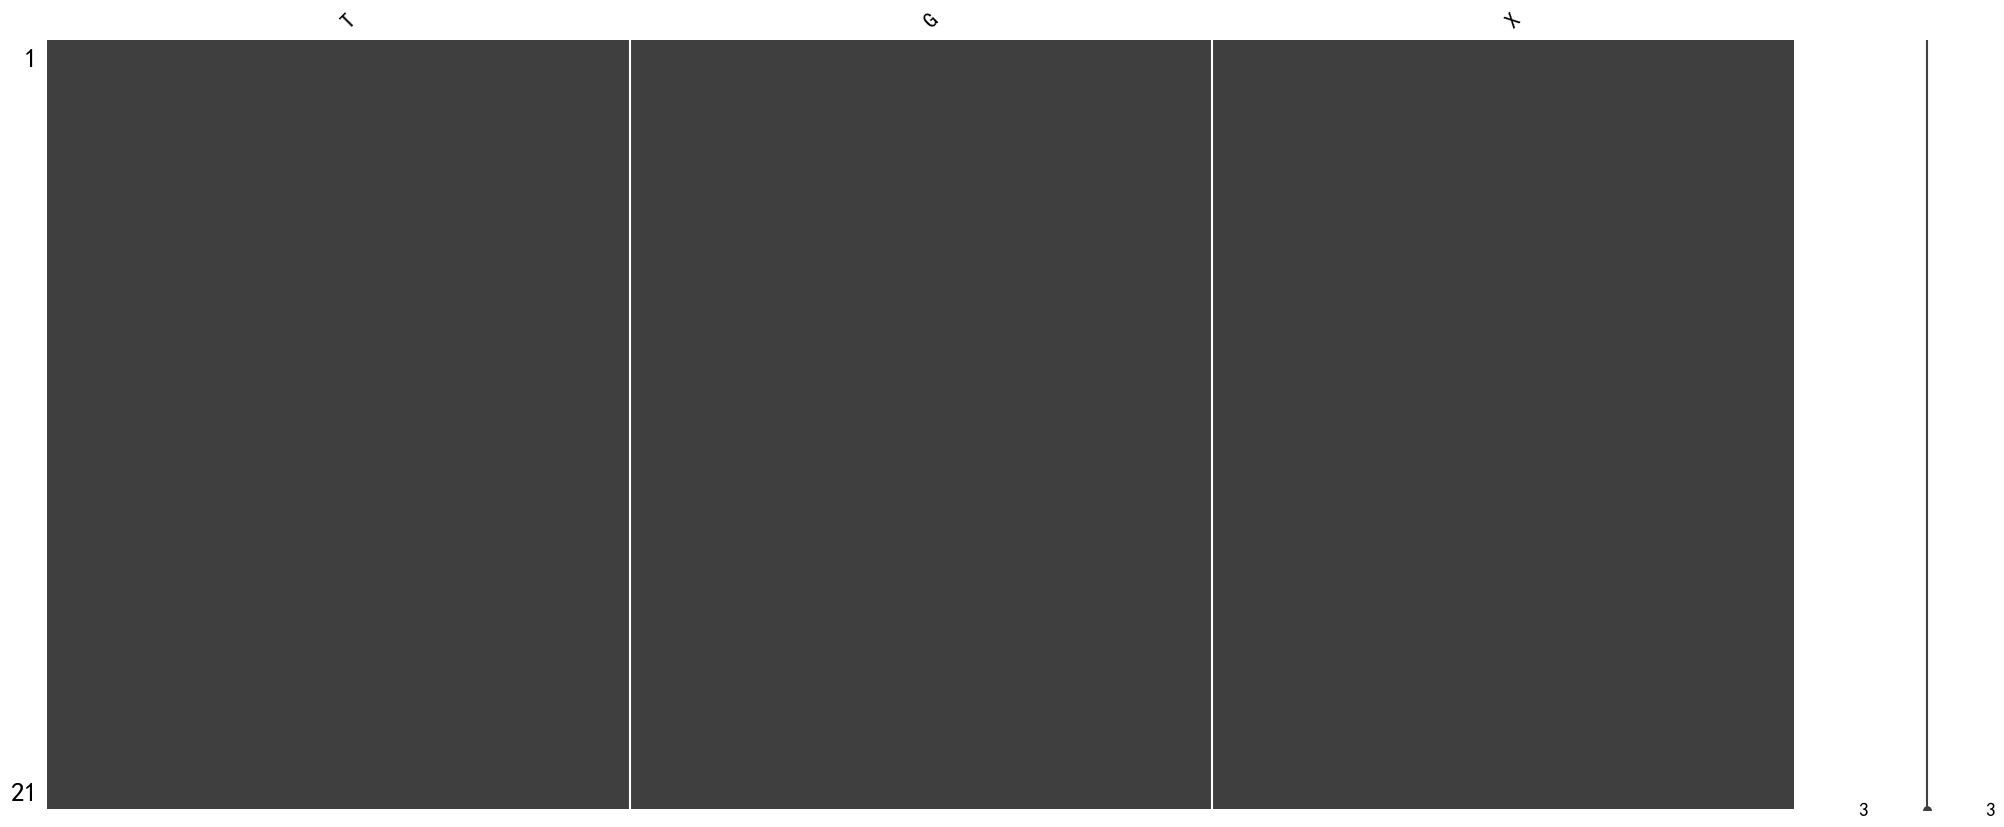

<Figure size 640x480 with 0 Axes>

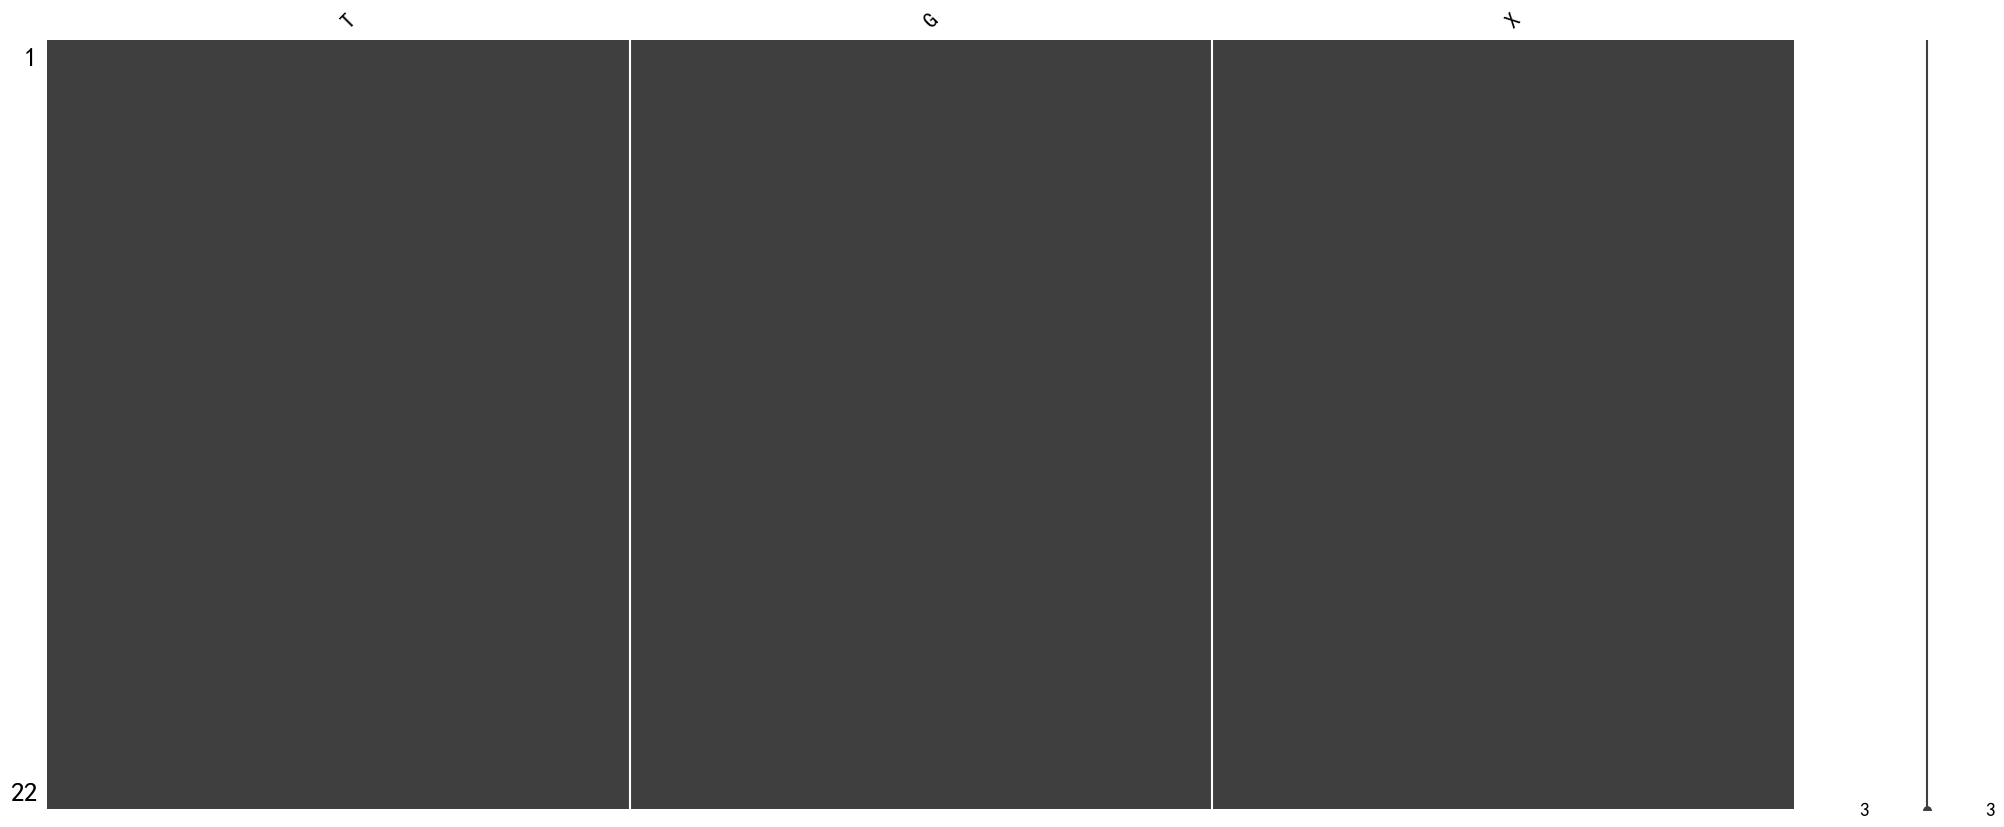

<Figure size 640x480 with 0 Axes>

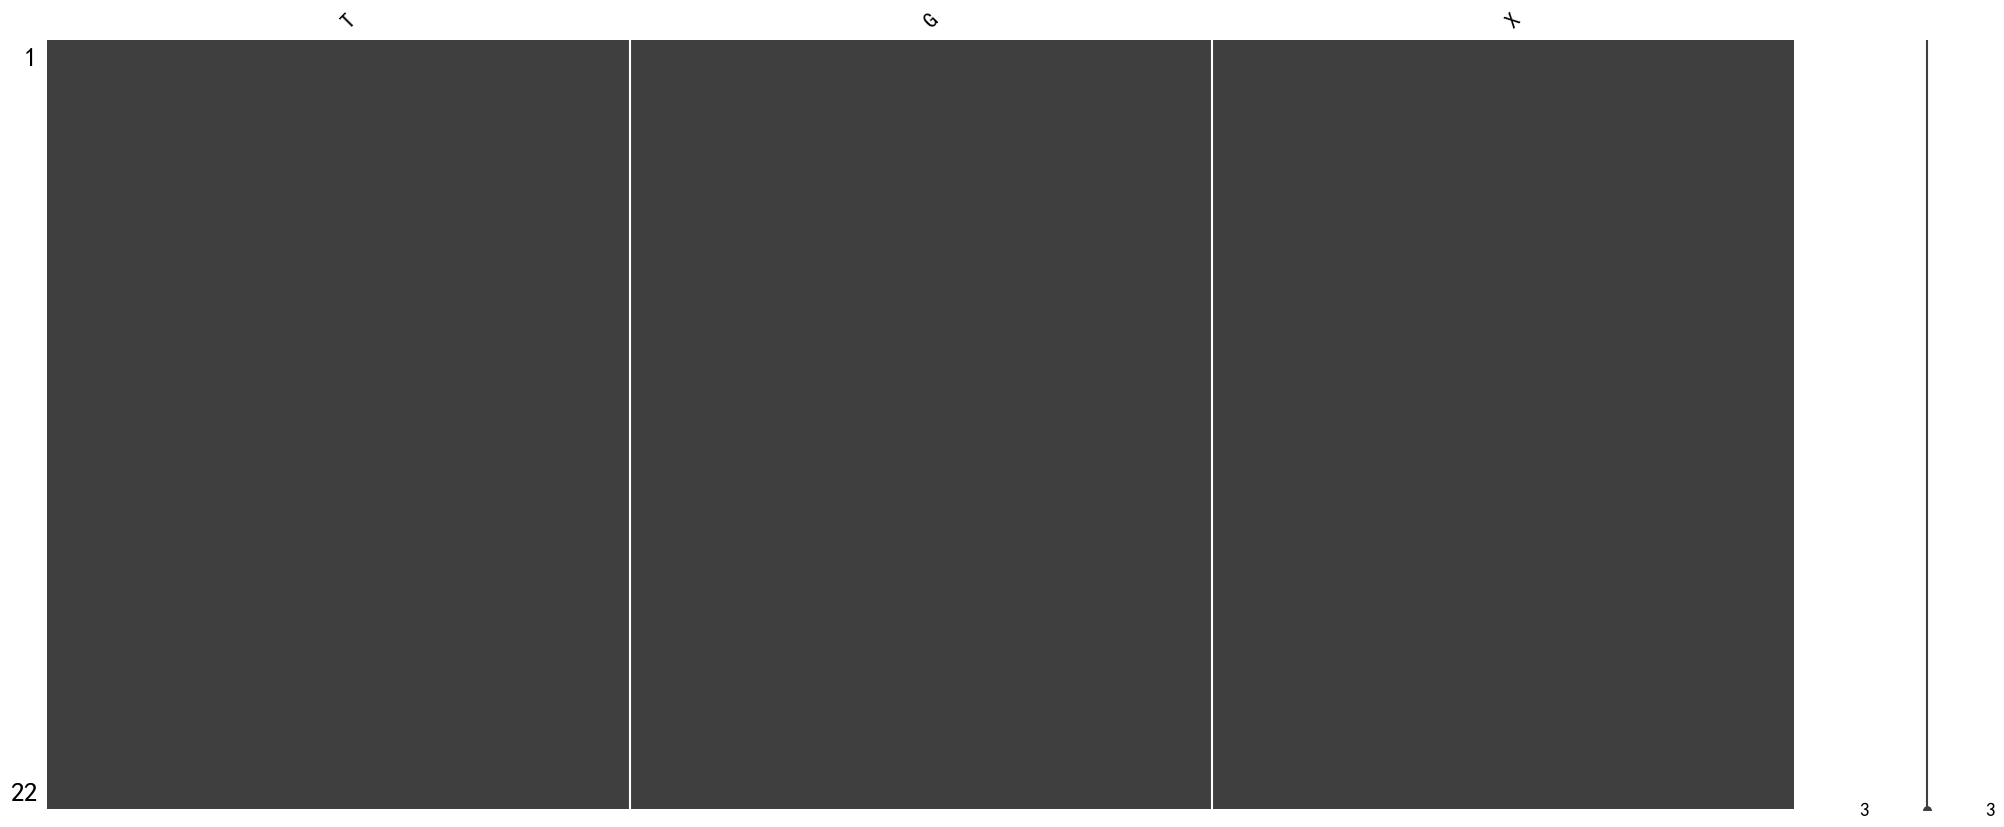

<Figure size 640x480 with 0 Axes>

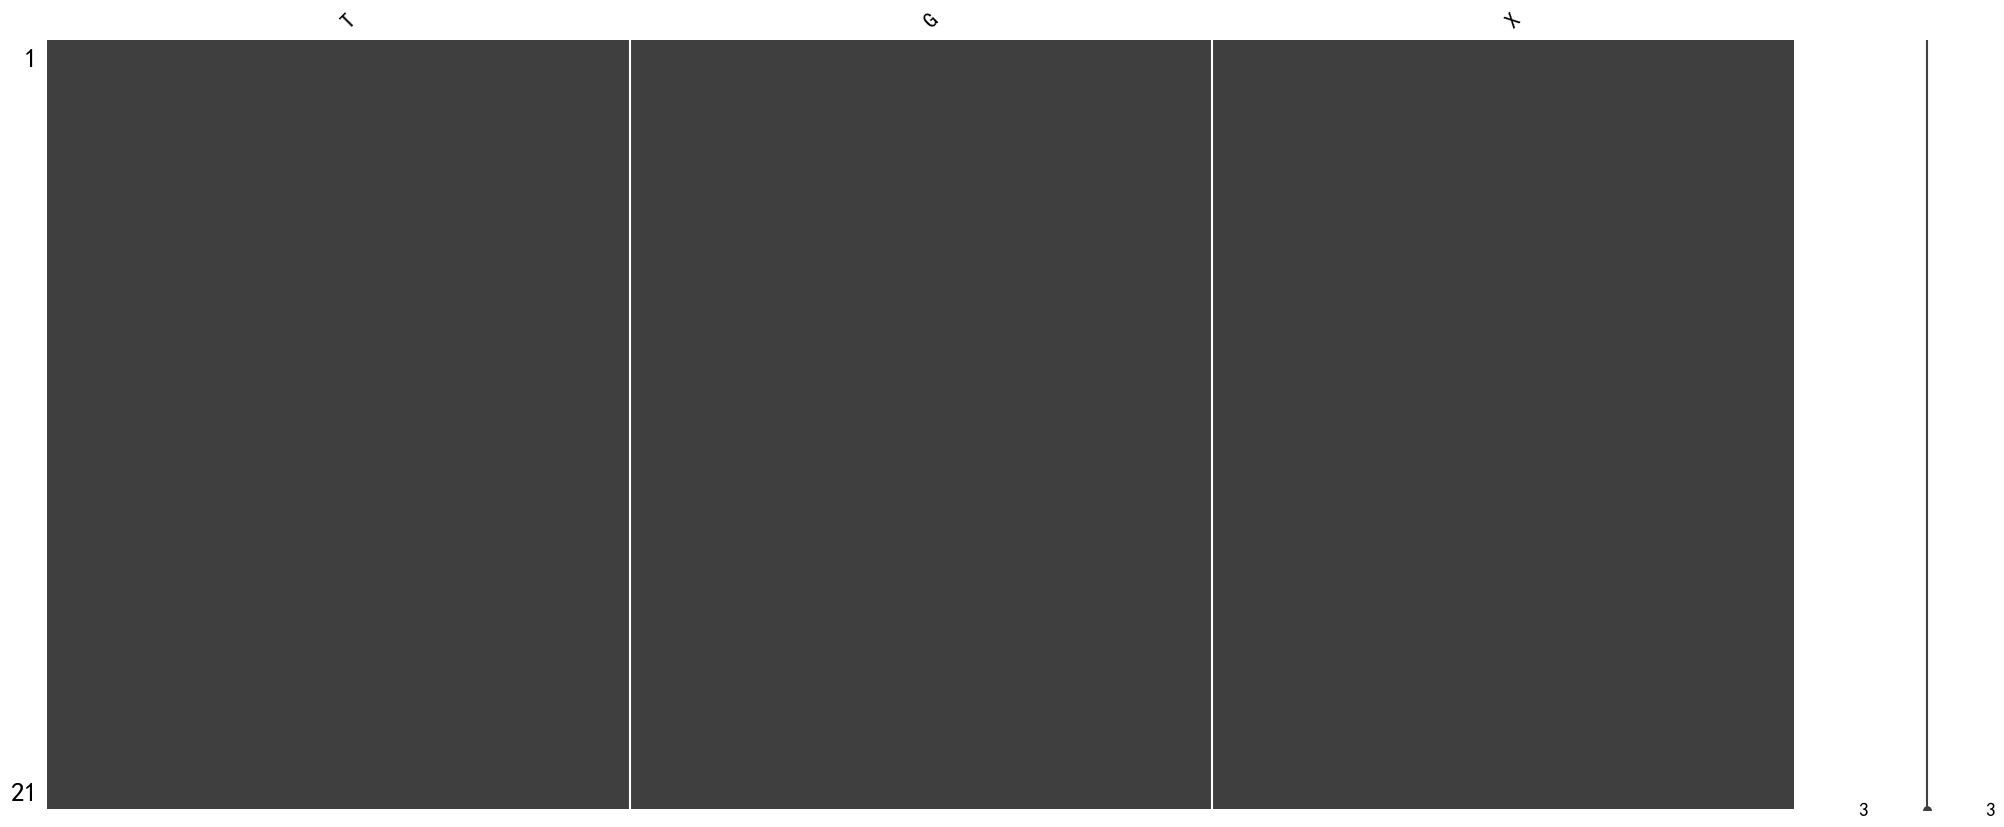

<Figure size 640x480 with 0 Axes>

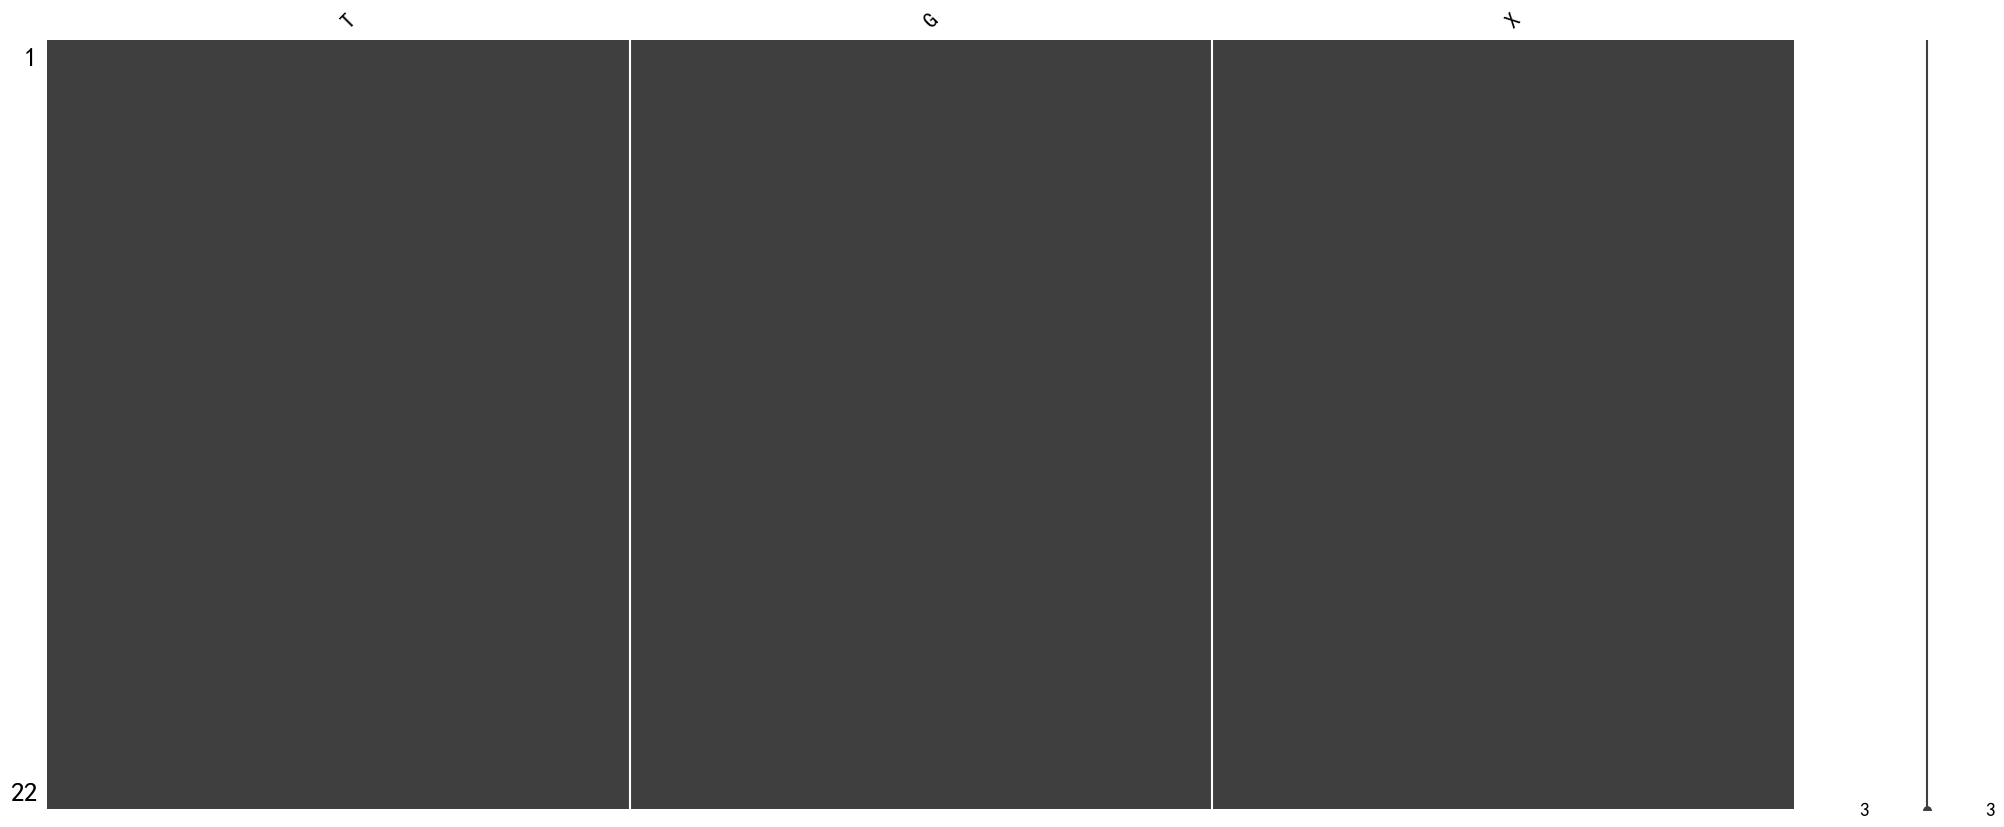

<Figure size 640x480 with 0 Axes>

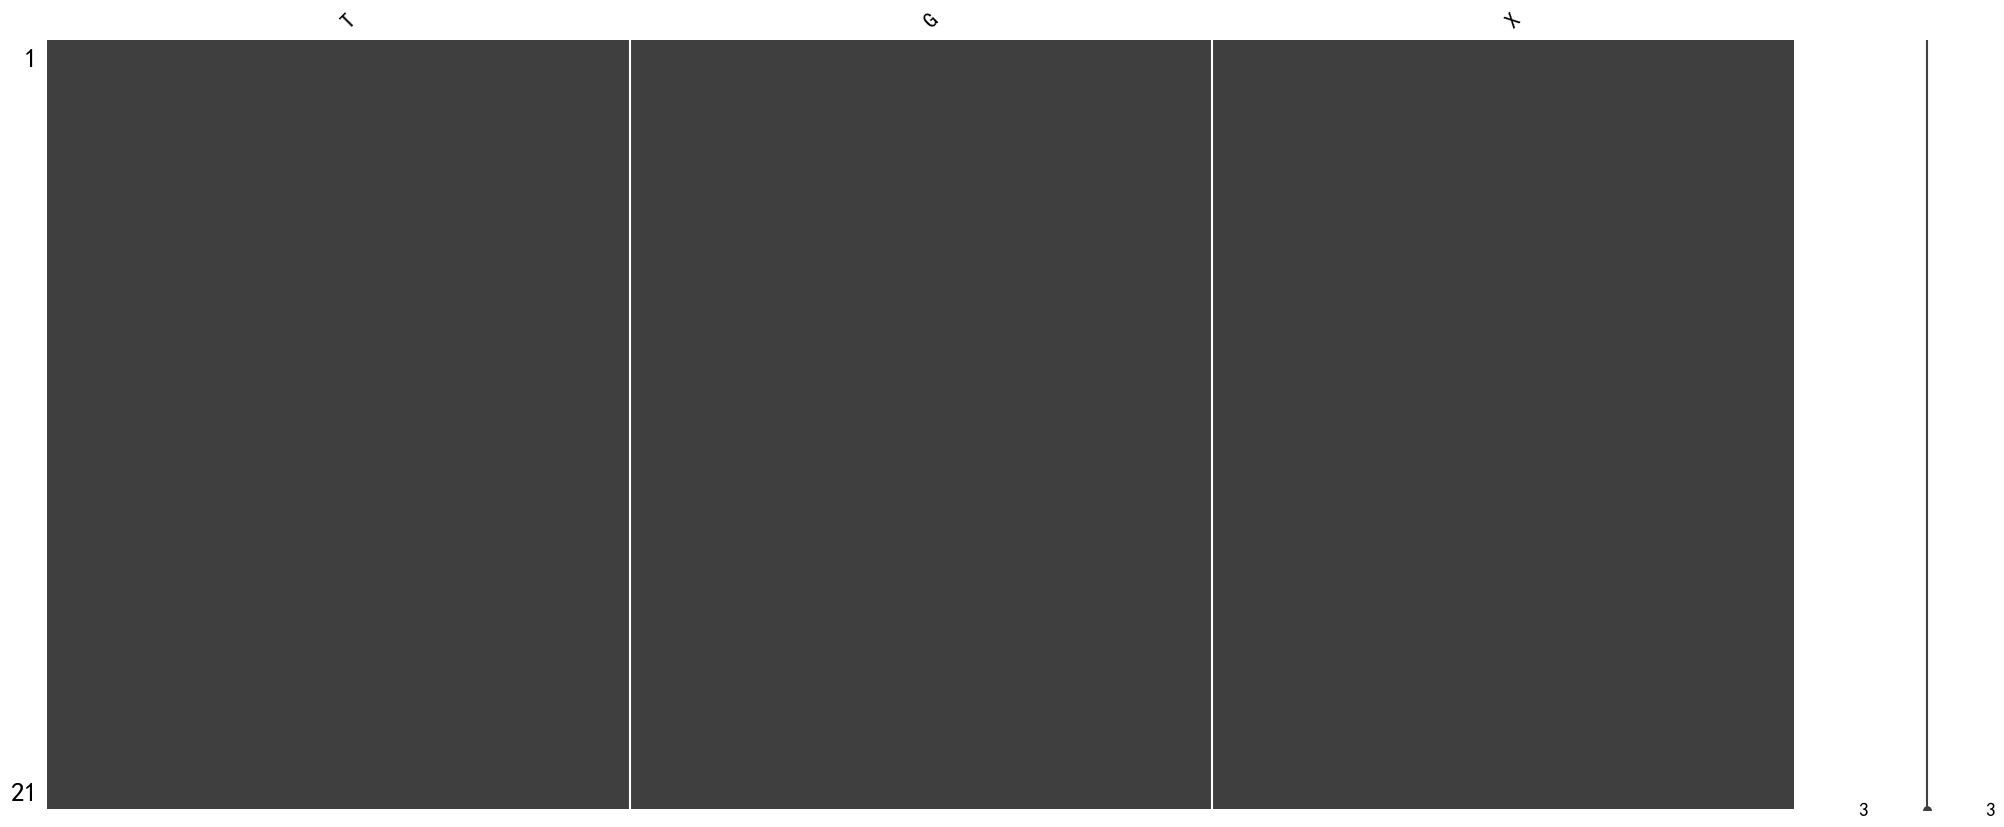

<Figure size 640x480 with 0 Axes>

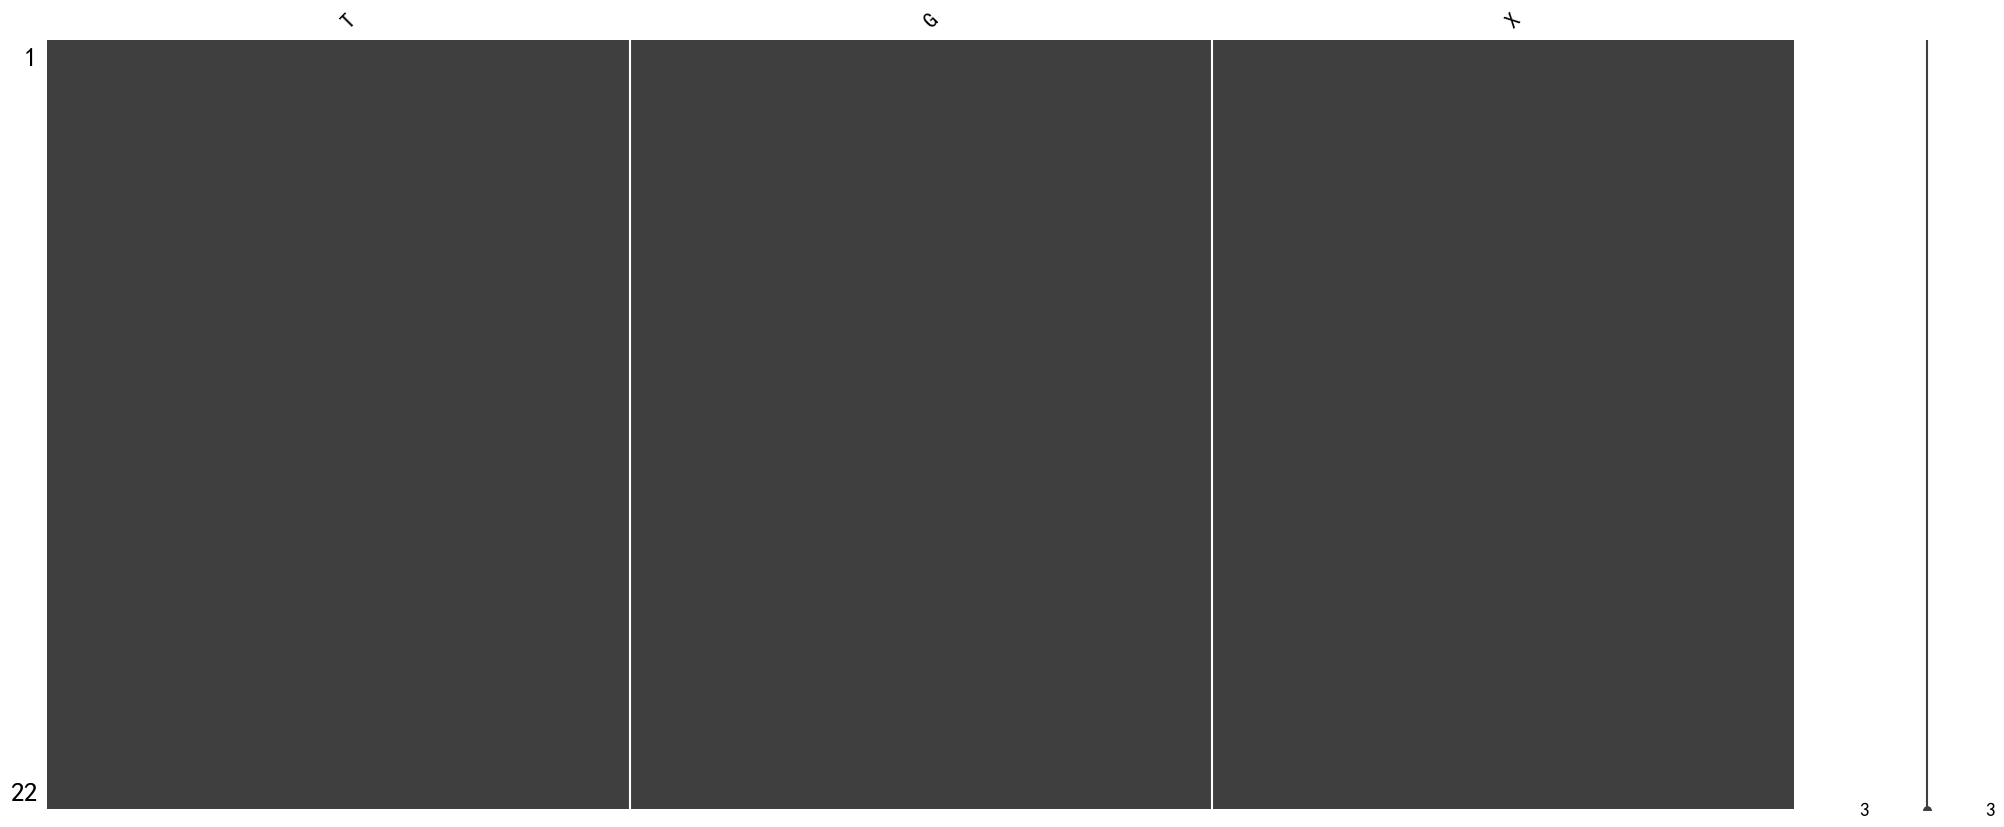

<Figure size 640x480 with 0 Axes>

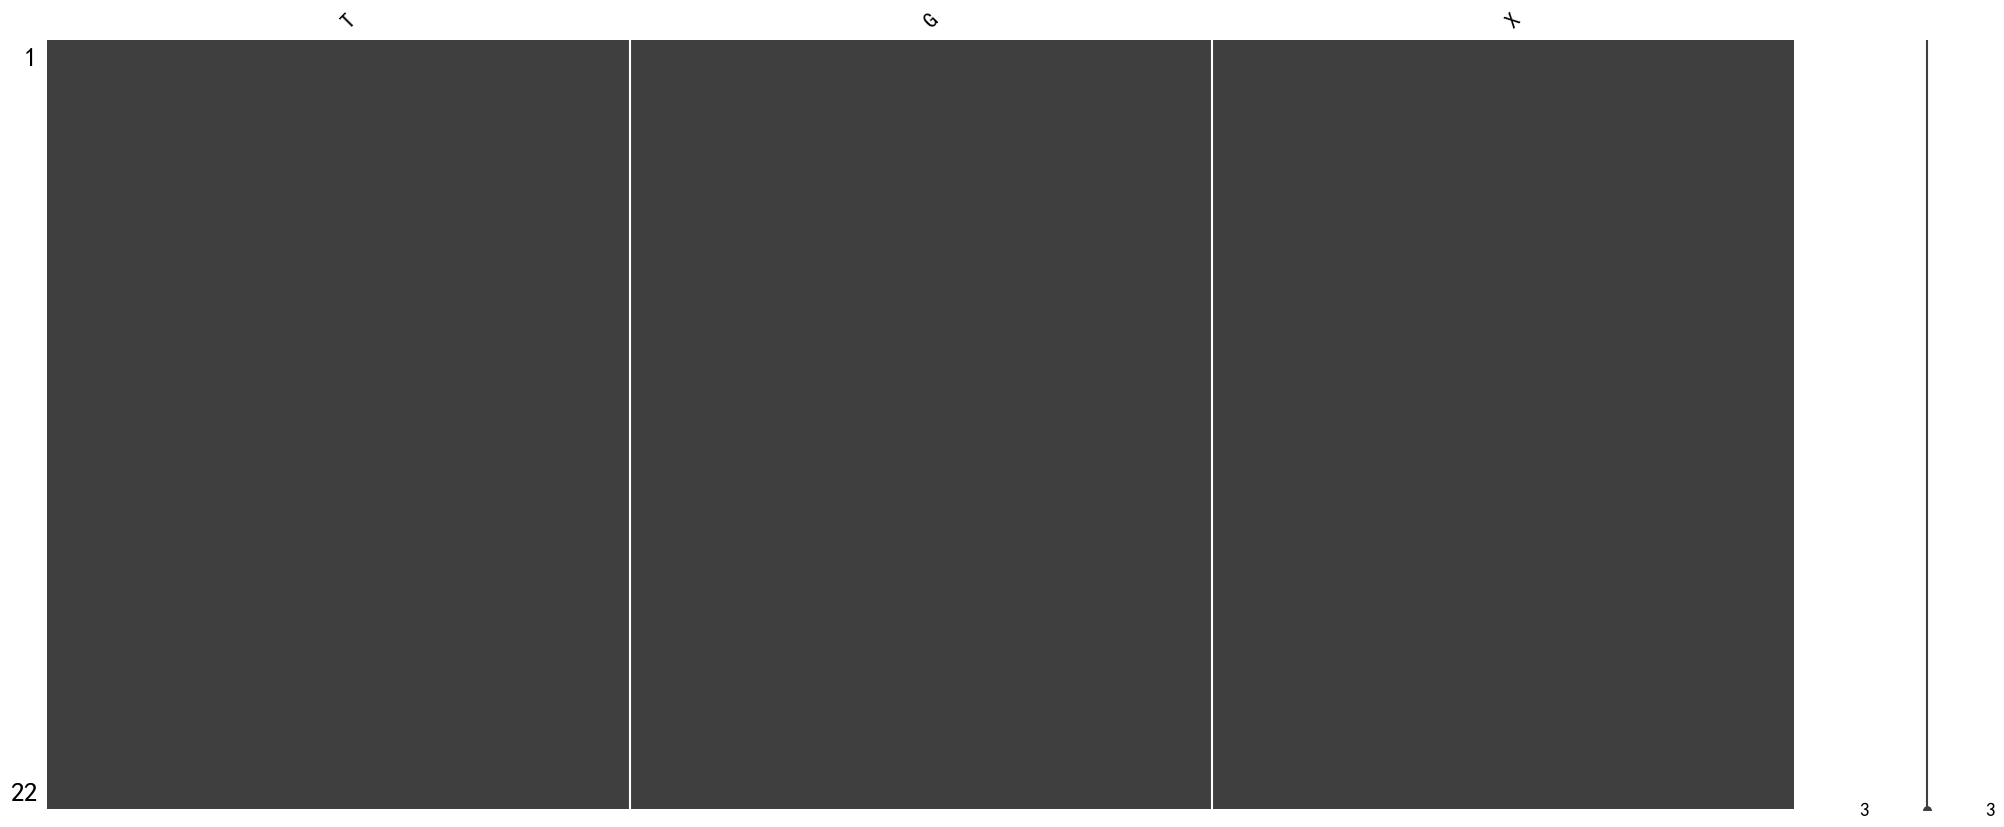

<Figure size 640x480 with 0 Axes>

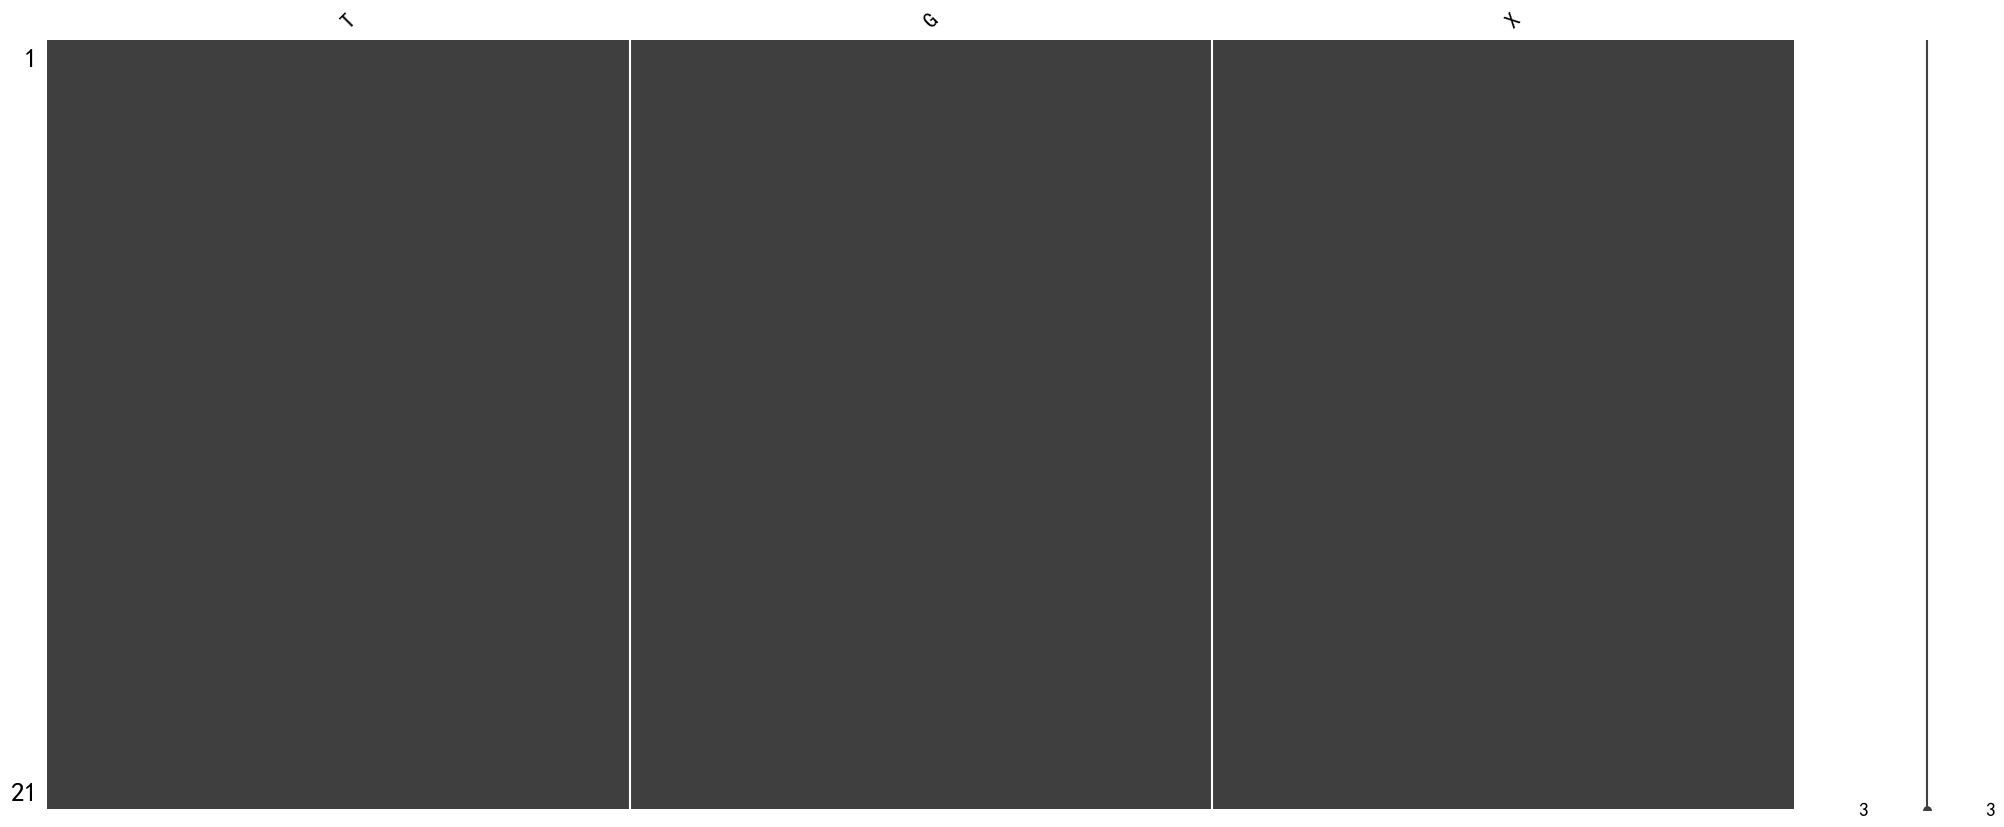

<Figure size 640x480 with 0 Axes>

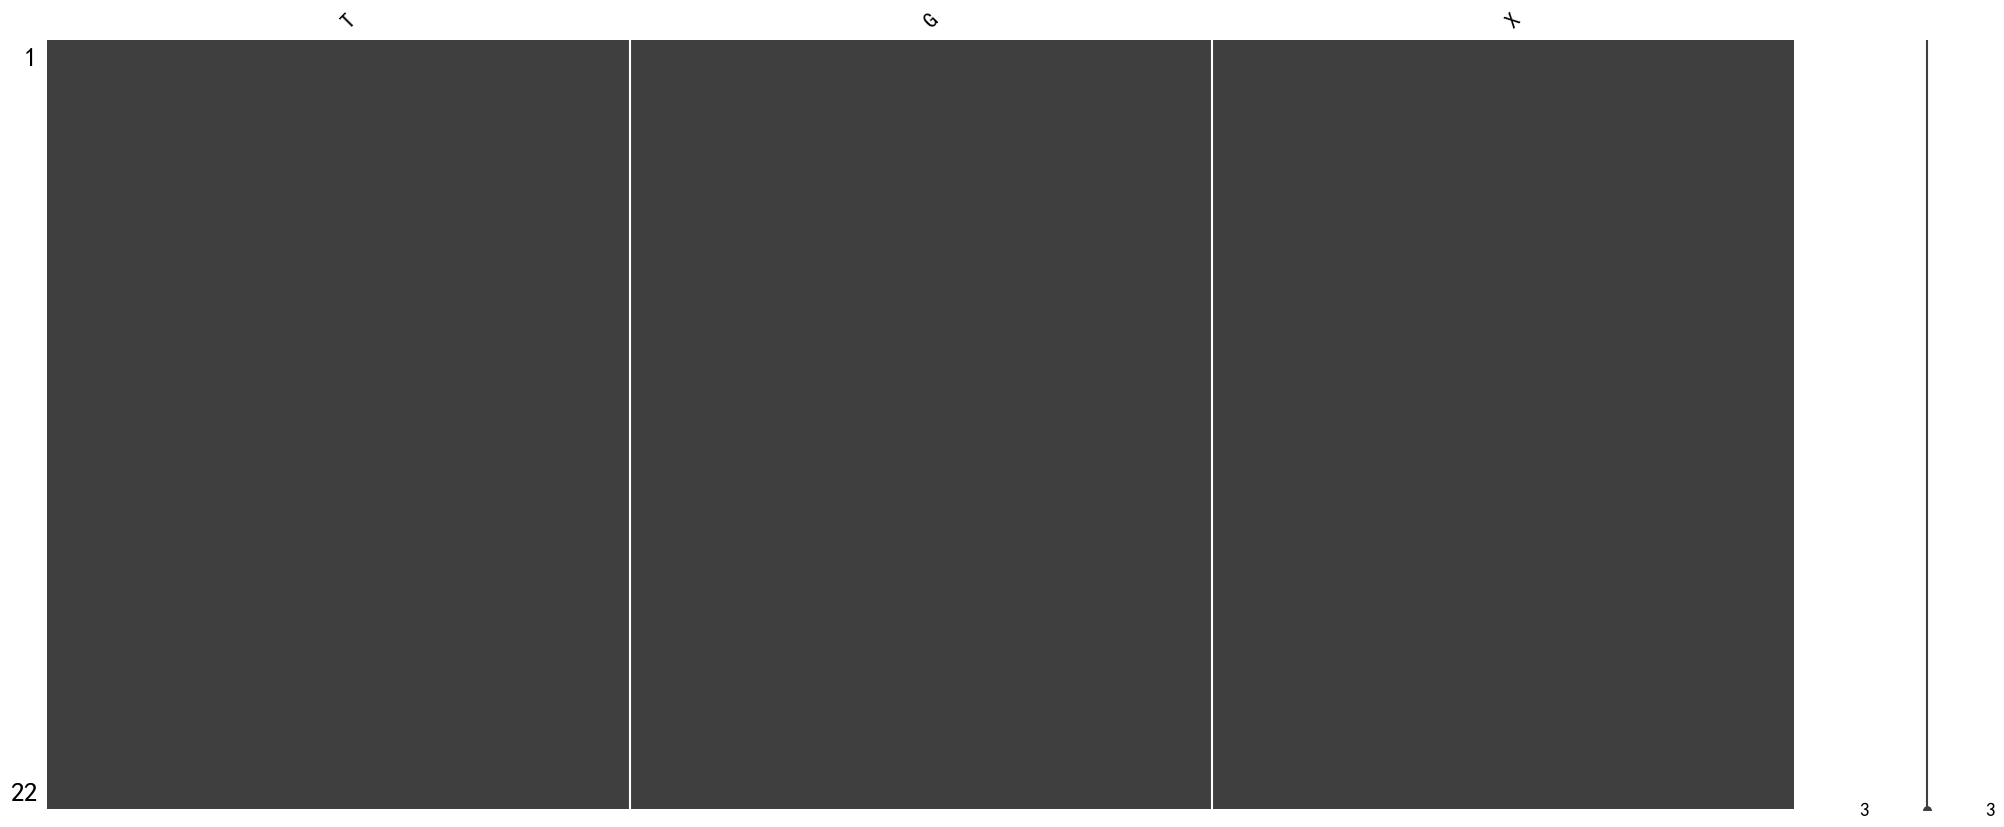

<Figure size 640x480 with 0 Axes>

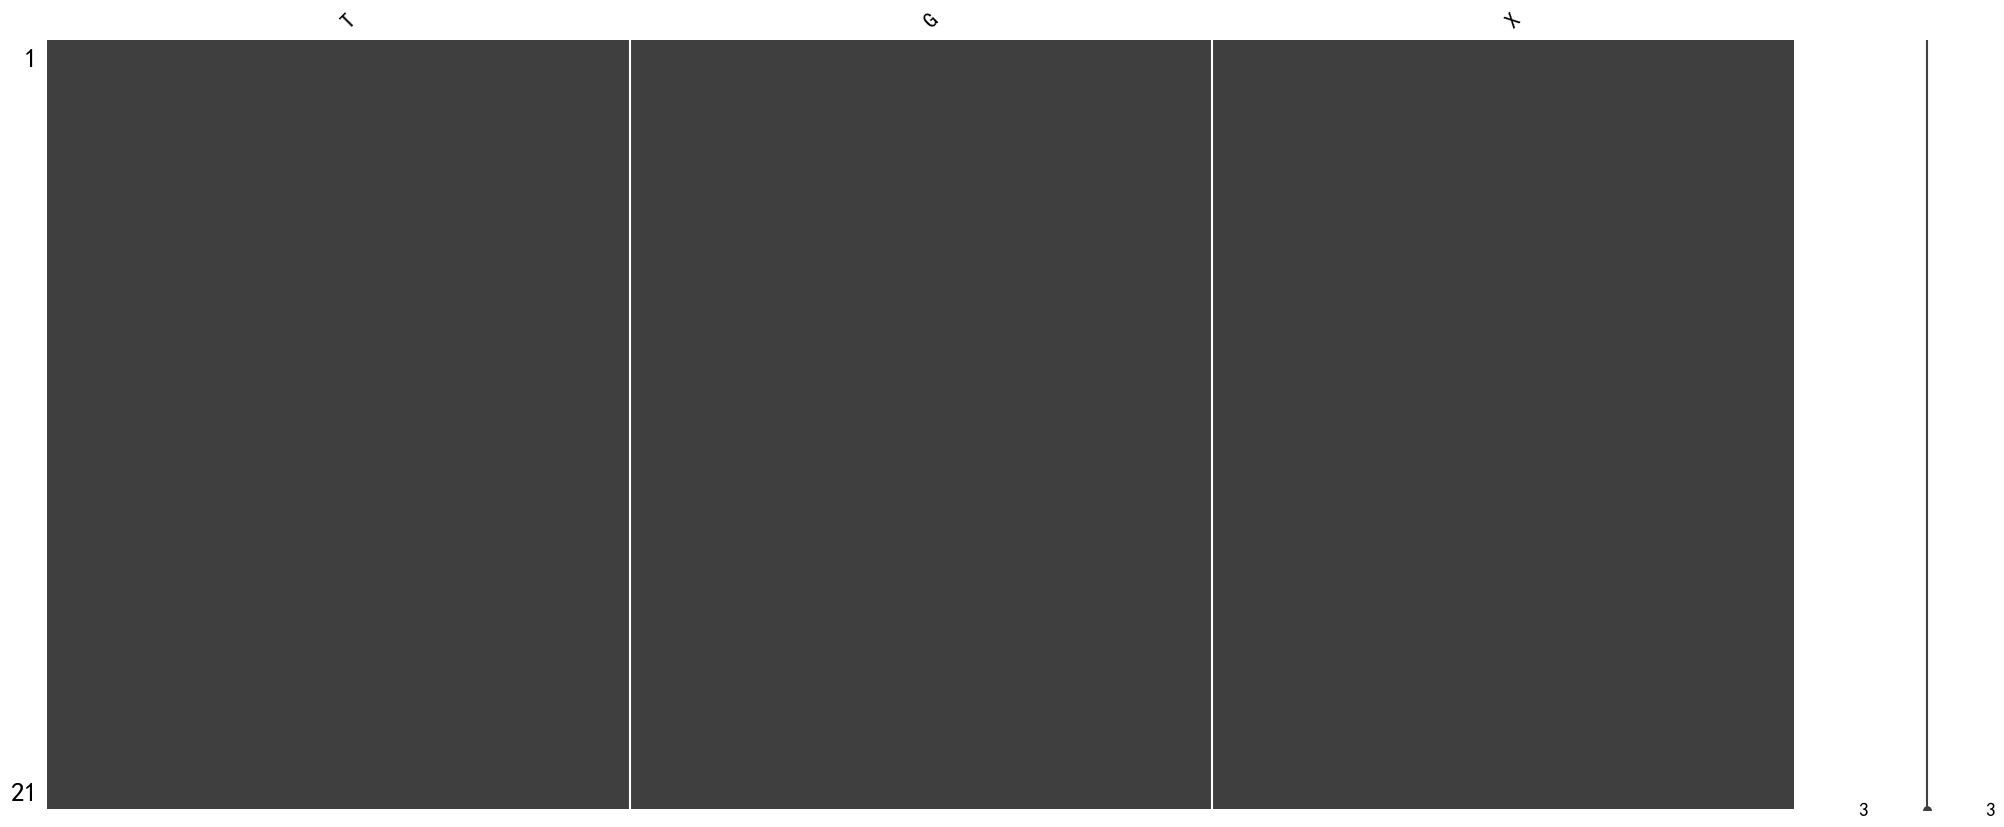

<Figure size 640x480 with 0 Axes>

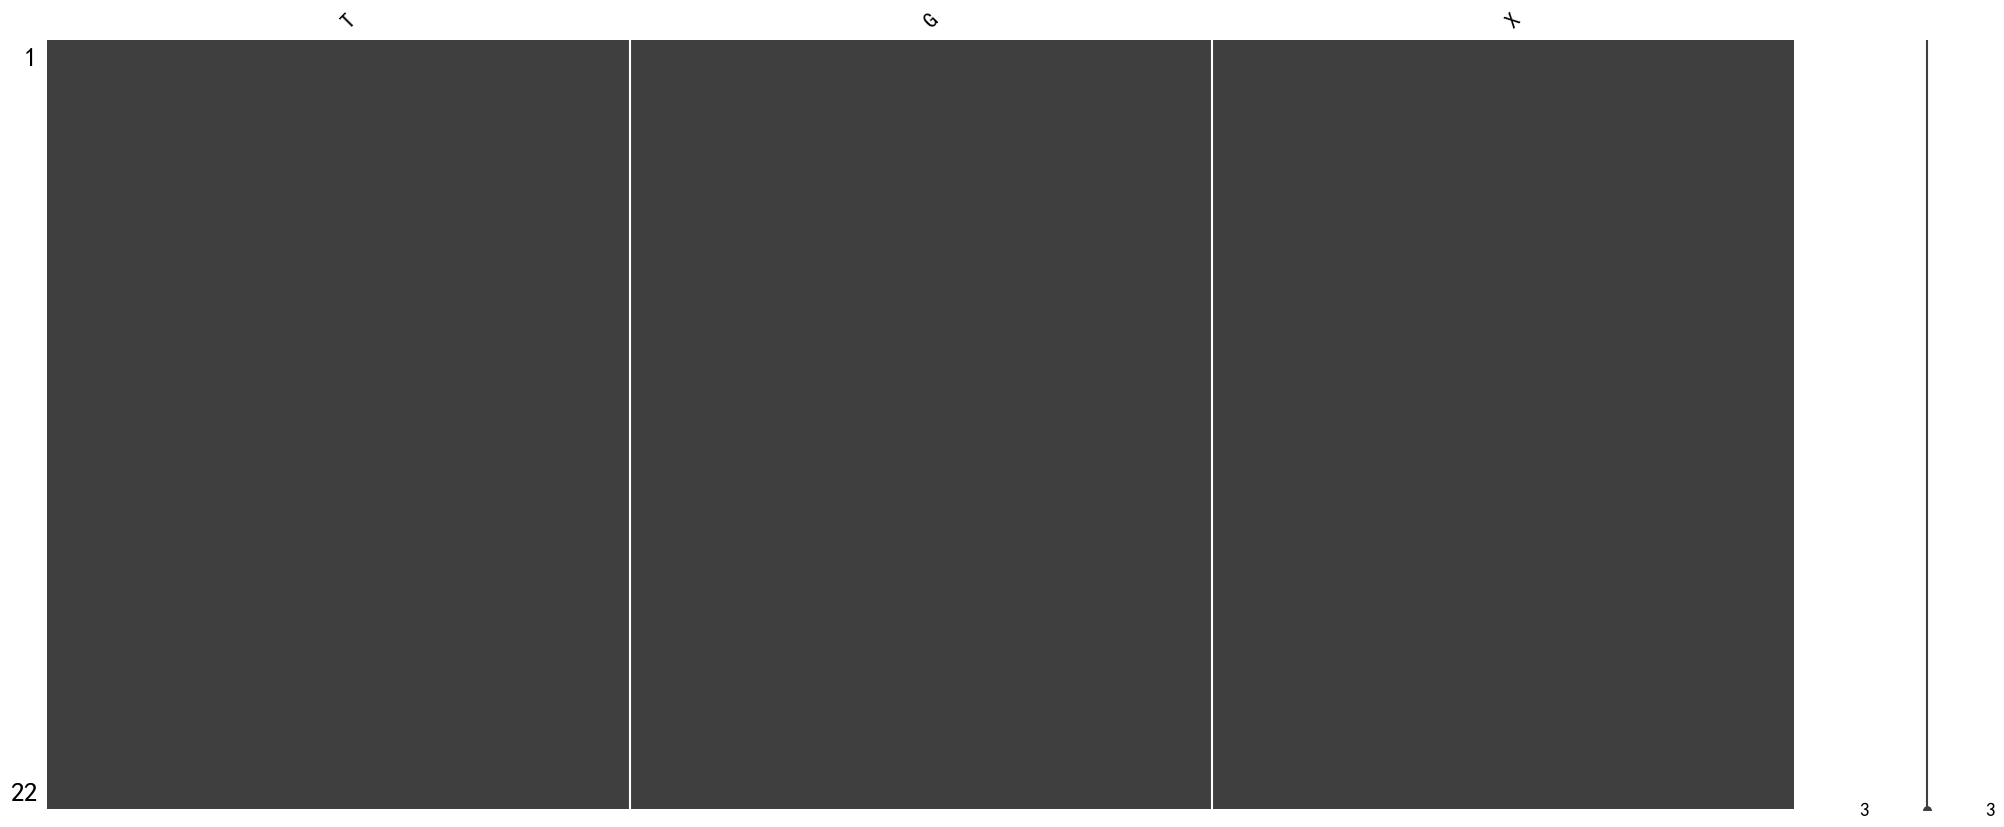

<Figure size 640x480 with 0 Axes>

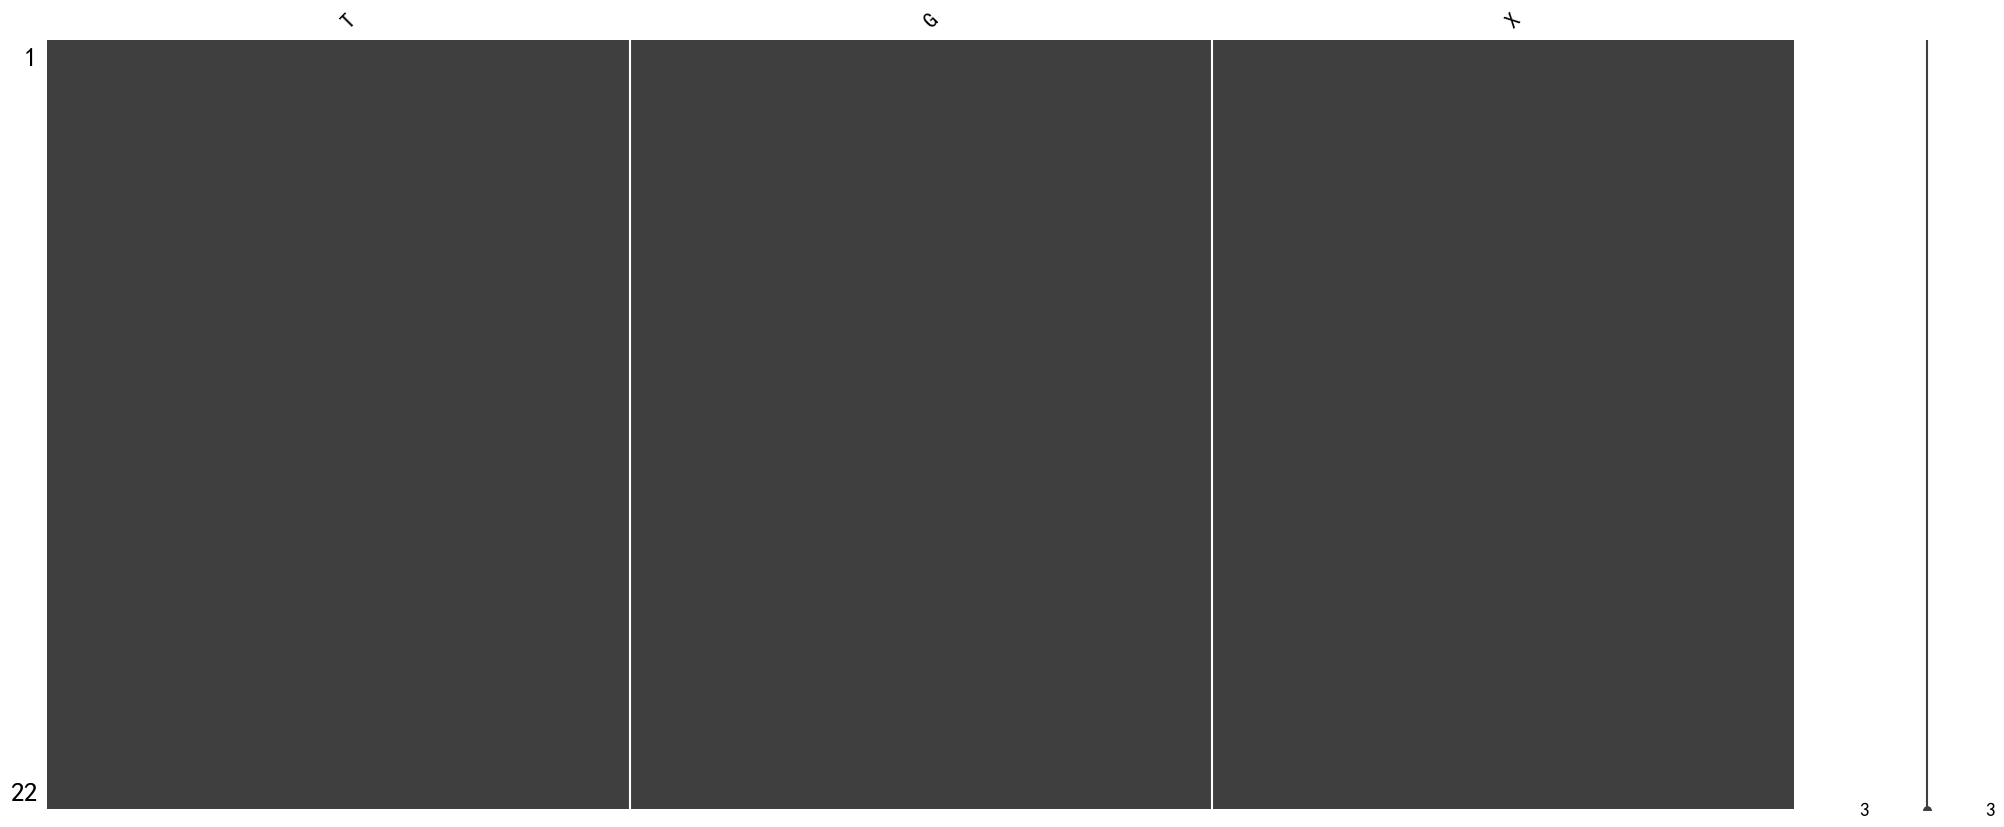

<Figure size 640x480 with 0 Axes>

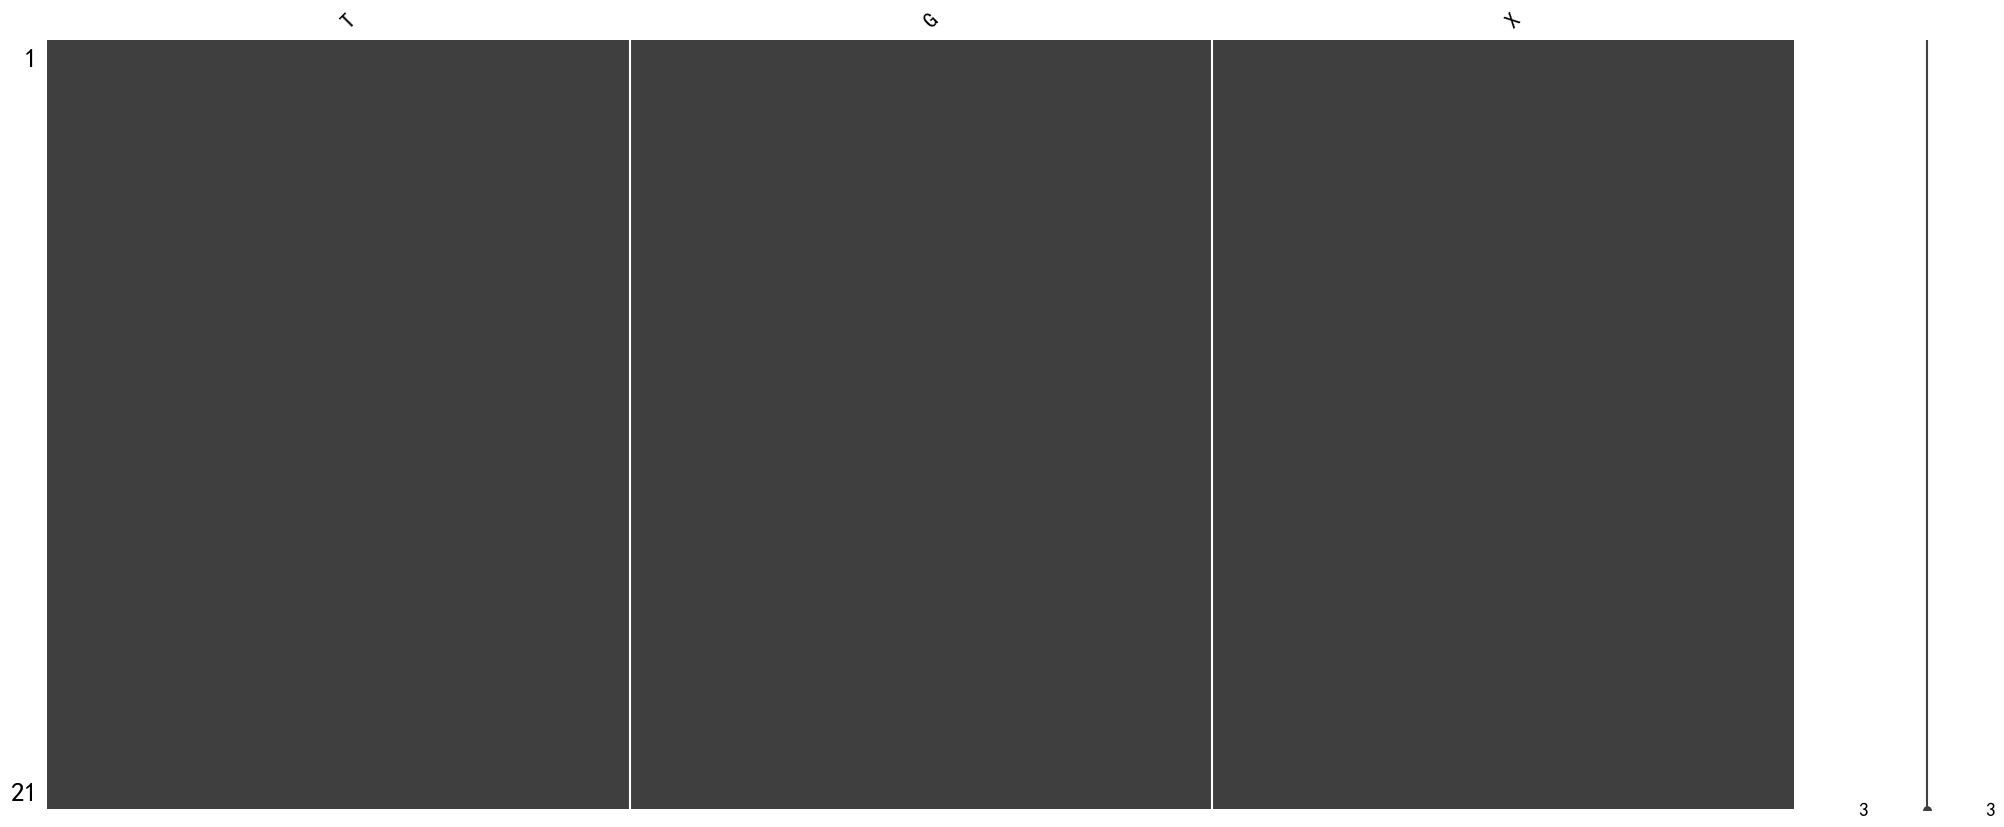

<Figure size 640x480 with 0 Axes>

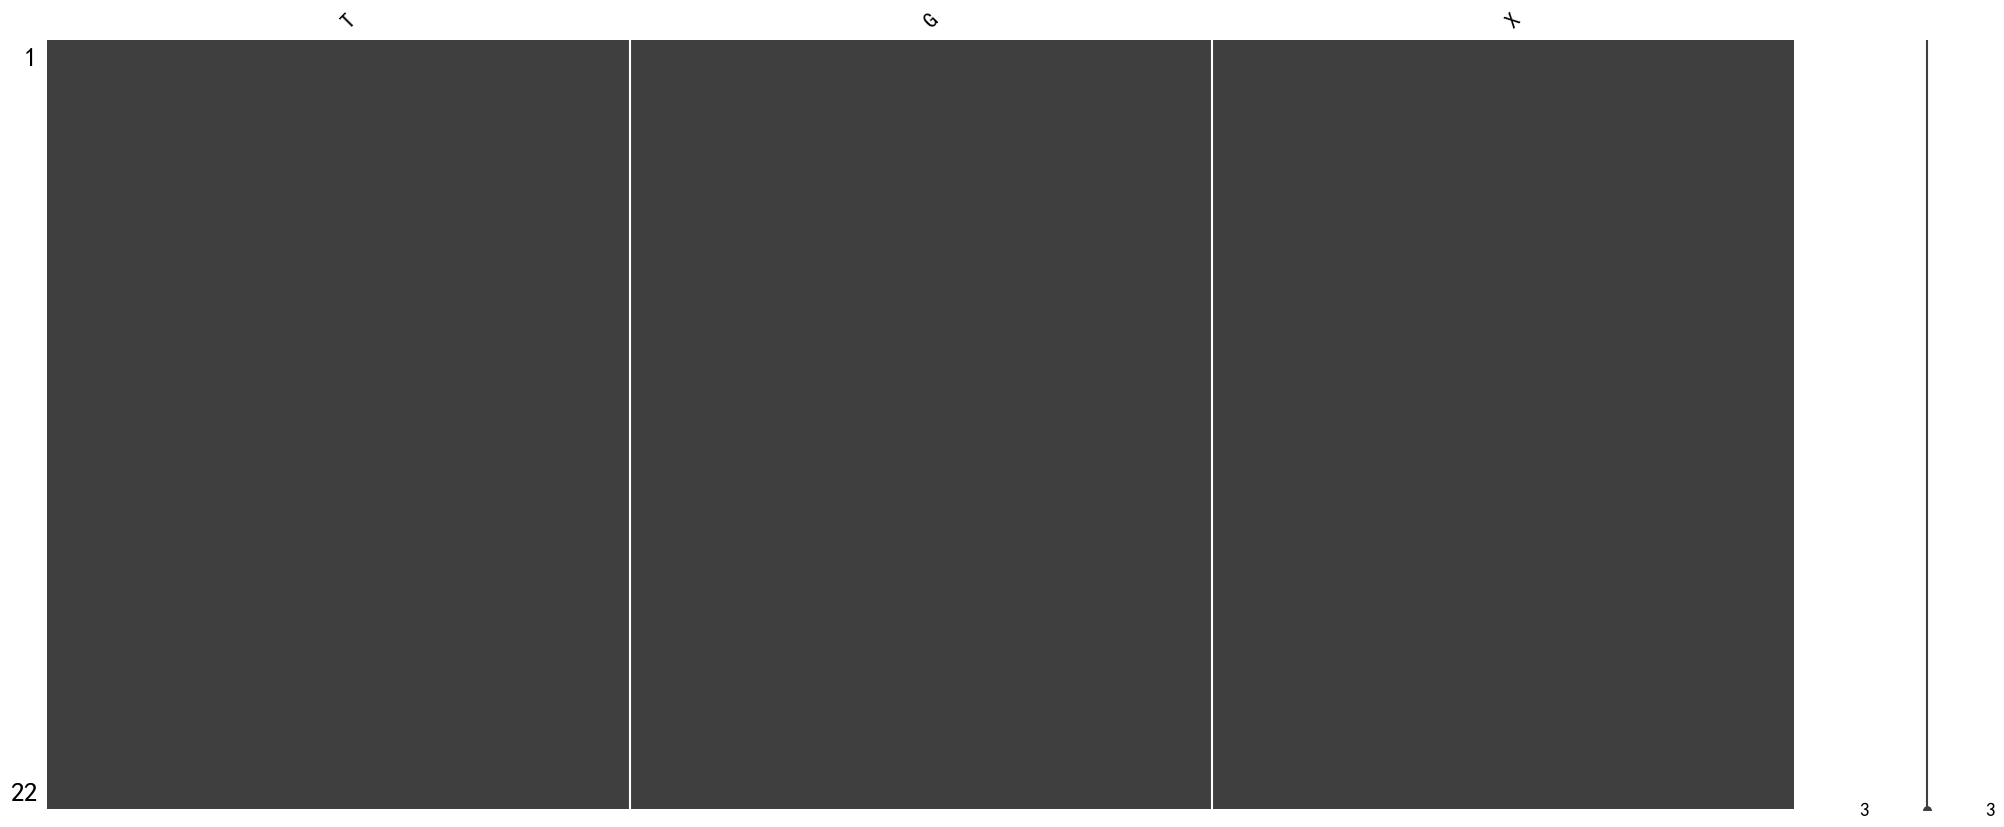

<Figure size 640x480 with 0 Axes>

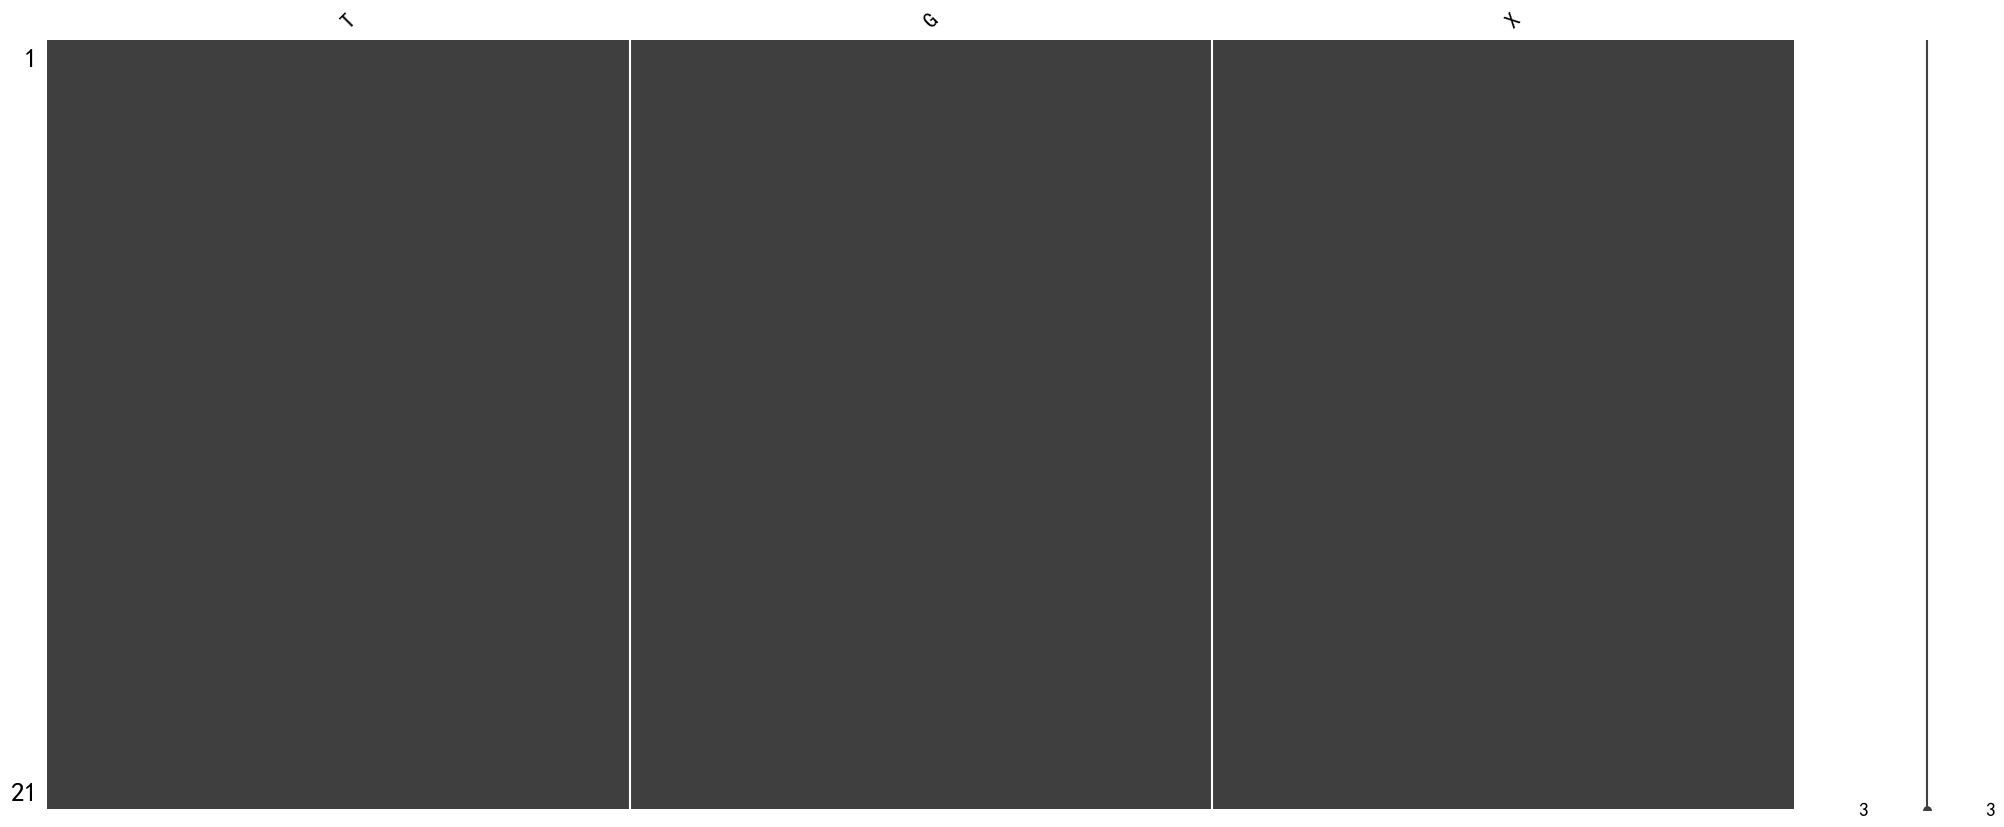

<Figure size 640x480 with 0 Axes>

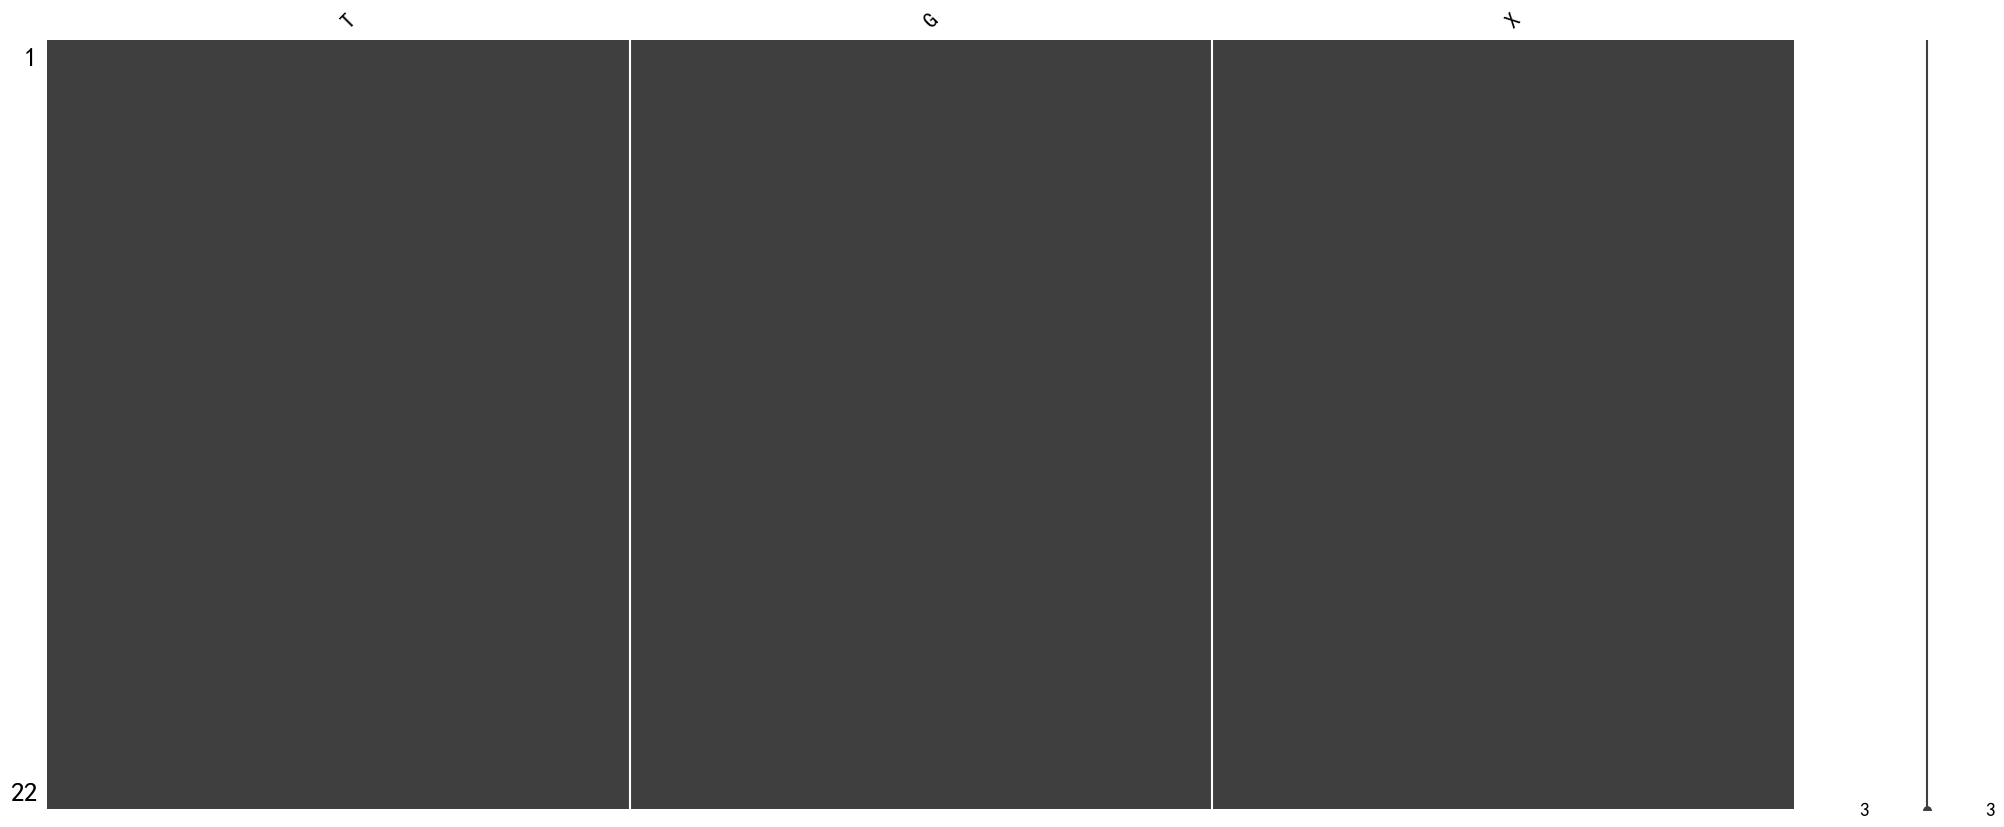

<Figure size 640x480 with 0 Axes>

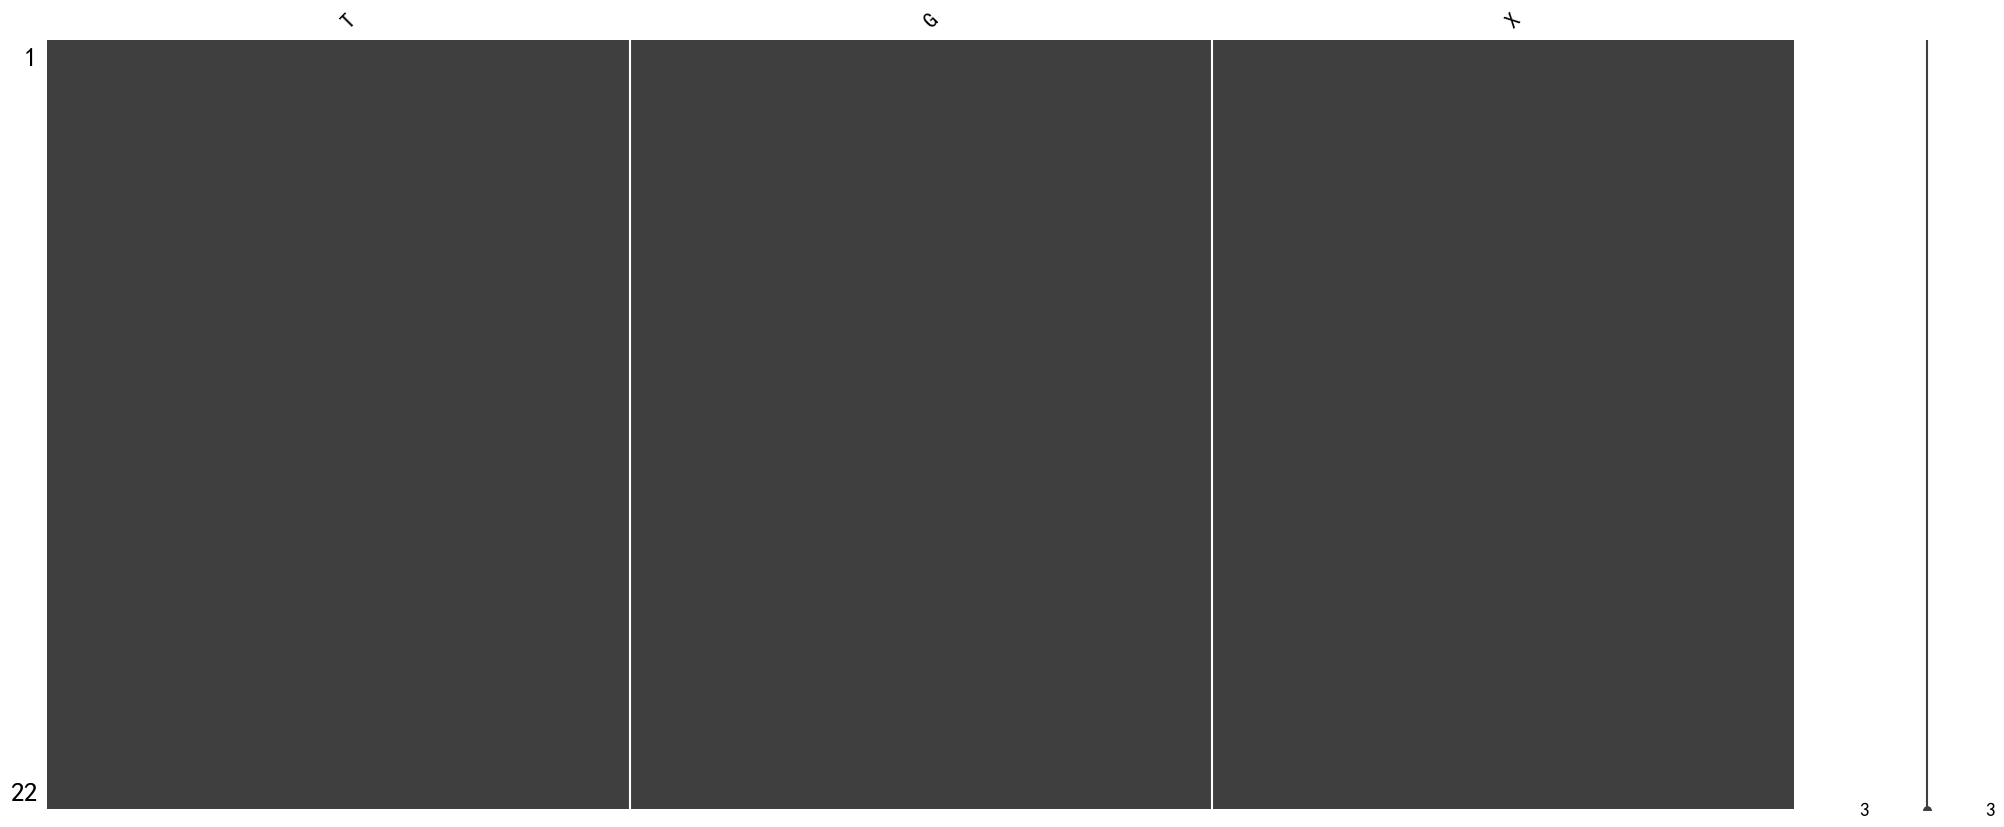

In [5]:
for time in df.index:
    predictors = df.loc[time,X.columns]
    if pd.isnull(df.loc[time,y.name]) and not pd.isnull(predictors).any():
        df.loc[time,y.name] = model.predict(
            df.loc[time,X.columns].values.reshape(1,-1))
        
fig = px.line(pd.DataFrame({
    'pred': df[y.name].values,
    'real': df_raw[y.name].values,
},index=df.index), labels={'time': '时间', 'value': '值'}, title='{}插补前后对比'.format(y.name))
fig.update_layout(
    template=plot_template,legend=dict(orientation='h',x=0,y=1.1))
fig.show()

plt.figure()
msno.matrix(df)
plt.figure()
msno.matrix(df.iloc[:int(df.shape[0]*0.05),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.05):int(df.shape[0]*0.1),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.1):int(df.shape[0]*0.15),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.15):int(df.shape[0]*0.2),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.2):int(df.shape[0]*0.25),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.25):int(df.shape[0]*0.3),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.3):int(df.shape[0]*0.35),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.35):int(df.shape[0]*0.4),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.4):int(df.shape[0]*0.45),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.45):int(df.shape[0]*0.5),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.5):int(df.shape[0]*0.55),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.55):int(df.shape[0]*0.6),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.6):int(df.shape[0]*0.65),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.65):int(df.shape[0]*0.7),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.7):int(df.shape[0]*0.75),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.75):int(df.shape[0]*0.8),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.8):int(df.shape[0]*0.85),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.85):int(df.shape[0]*0.9),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.9):int(df.shape[0]*0.95),:])
plt.figure()
msno.matrix(df.iloc[int(df.shape[0]*0.95):,:])

In [6]:
fig = px.line(df, labels={'time': '时间', 'value': '值'},)
fig.update_layout(
    template=plot_template,legend=dict(orientation='h',x=0,y=1.5))
fig.show()

In [10]:
import calendar
def Get_days_from_month(date):
    # print(type(date))
    year = date.year
    month = date.month
    # year, month, day = map(int, date.split('-'))

    # 获取该月的天数
    days_in_month = calendar.monthrange(year, month)[1]

    return days_in_month

In [12]:
# xunhua = df['X']
# xunhua.columns=['flow(m^3/s)']
# xunhua.to_csv('../data/xunhua_monthly_flow_extended.csv')

xunhua_monthly_flow = pd.read_csv('../data/xunhua_monthly_flow_extended.csv')
# convert date to datetime
xunhua_monthly_flow['date']=pd.to_datetime(xunhua_monthly_flow['date'])
xunhua_monthly_flow['days'] = xunhua_monthly_flow['date'].apply(Get_days_from_month)
xunhua_monthly_flow['runoff(10^8m^3)'] = xunhua_monthly_flow['flow(m^3/s)']*xunhua_monthly_flow['days']*24*3600/100000000
xunhua_annual_runoff = xunhua_monthly_flow.loc[:,['date','runoff(10^8m^3)']]
xunhua_annual_runoff['date']=pd.to_datetime(xunhua_annual_runoff['date'])
xunhua_annual_runoff.set_index('date',inplace=True)
xunhua_annual_runoff = xunhua_annual_runoff.resample('YE').sum()
xunhua_annual_runoff.to_csv('../data/xunhua_annual_runoff_extended.csv')

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim